In [ ]:
!pip install optuna

     |████████████████████████████████| 296kB 8.3MB/s 
     |████████████████████████████████| 163kB 14.6MB/s 
     |████████████████████████████████| 81kB 8.5MB/s 
     |████████████████████████████████| 81kB 9.0MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 143kB 16.2MB/s 
     |████████████████████████████████| 112kB 17.2MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=df3244054331c4e53fbcbc64acad26767898cf60b6e5a2a17a5794de4e4c1c3e
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [ ]:
from glob import glob
from keras import optimizers
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, models
import cv2
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import optuna
import os

In [ ]:
path = glob("tomii/*/")
data = []
label = []
total = 0
x = 32
y = 18

def append_data(directory, total):
  files = os.listdir(directory)
  print(files)
  for image in files:
    if image.endswith(".jpg"):
      image = cv2.imread(directory + image)
      image = cv2.resize(image, (x, y))
      image_gs = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      image_gs = image_gs.flatten()
      data.append(image_gs)
      label.append(total)

for i in path:
    append_data(i, total)
    total += 1

['kyogoku_010.jpg', 'kyogoku_011.jpg', 'kaibara_137.jpg', 'kaibara_138.jpg', 'kaibara_139.jpg', 'kyogoku_012.jpg', 'kyogoku_014.jpg', 'kyogoku_015.jpg', 'kyogoku_016.jpg', 'kyogoku_017.jpg', 'kaibara_140.jpg', 'kaibara_141.jpg', 'kyogoku_018.jpg', 'kyogoku_019.jpg', 'kyogoku_020.jpg', 'kyogoku_021.jpg', 'kyogoku_022.jpg', 'kyogoku_023.jpg', 'kaibara_142.jpg', 'kyogoku_025.jpg', 'kyogoku_026.jpg', 'kyogoku_027.jpg', 'kyogoku_028.jpg', 'kaibara_143.jpg', 'kaibara_144.jpg', 'kaibara_145.jpg', 'kyogoku_029.jpg', 'kurita_160.jpg', 'kyogoku_030.jpg', 'tanimura_050.jpg', 'tanimura_052.jpg', 'ohhara_184.jpg', 'kurita_162.jpg', 'kaibara_146.jpg', 'kaibara_147.jpg', 'kaibara_148.jpg', 'kaibara_149.jpg', 'kaibara_150.jpg', 'kaibara_151.jpg', 'kaibara_152.jpg', 'kaibara_153.jpg', 'kaibara_154.jpg', 'ohhara_187.jpg', 'ohhara_188.jpg', 'ohhara_189.jpg', 'kaibara_155.jpg', 'kaibara_156.jpg', 'kaibara_157.jpg', 'kaibara_158.jpg', 'kaibara_159.jpg', 'kaibara_160.jpg', 'kaibara_161.jpg', 'kaibara_162.jp

In [ ]:
data = np.array(data, dtype=np.float64)
label = np.array(label, dtype=np.float64)

train_data, test_data, train_label, test_label = train_test_split(data, label, random_state=1, stratify=label, test_size=0.1)

train_data = train_data.reshape((len(train_data)), x, y, 1)
test_data = test_data.reshape((len(test_data)), x, y, 1)

train_data /= 255
test_data /= 255

train_label = to_categorical(train_label, num_classes=2)
test_label = to_categorical(test_label, num_classes=2)
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(1152, 32, 18, 1)
(1152, 2)
(129, 32, 18, 1)
(129, 2)


In [ ]:
model_list = []
result_list = []

def create_model(layer, filter_size, filters, activation, dropout_rate):
  model = model = models.Sequential()
  model.add(layers.Conv2D(16, (filter_size, filter_size), activation="relu", padding="same", input_shape=(x, y, 1)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2), strides=(1, 1)))
  model.add(layers.Flatten())
  for i in range(layer):
    model.add(layers.Dense(filters, activation=activation))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate=dropout_rate))
  model.add(layers.Dense(2, activation="softmax"))
  return model

def optimisation(choice):
  K.clear_session()
  layer = choice.suggest_int("layer", 1, 8)
  filter_size = choice.suggest_int("filter_size", 3, 7, 2)
  filters = choice.suggest_int("filters", 32, 256, 32)
  optimizer = choice.suggest_categorical("optimizer", ["SGD", "RMSprop", "Adagrad", "Adadelta", "Adam", "Adamax", "Nadam"])
  activation = choice.suggest_categorical("activation", ["softmax", "elu", "selu", "softplus", "softsign", "relu", "tanh", "sigmoid", "hard_sigmoid", "linear"])
  dropout_rate = choice.suggest_uniform("dropout_rate", 0.25, 0.5)
  model = create_model(layer, filter_size, filters, activation, dropout_rate)
  model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  result = model.fit(train_data, train_label, batch_size=batchsize, epochs=epoch, verbose=2, validation_data=(test_data, test_label))
  model_list.append(model)
  result_list.append(result)
  return 1 - result.history["val_accuracy"][-1]

In [ ]:
batchsize = train_data.shape[0] // 64
print(batchsize)
epoch = 16
study = optuna.create_study()
study.optimize(optimisation, n_trials=256)

[I 2021-03-17 06:10:03,410] A new study created in memory with name: no-name-86e5bae1-30c4-46ee-a3b1-80f46930ff2f


18
Epoch 1/16
64/64 - 33s - loss: 0.9046 - accuracy: 0.6016 - val_loss: 0.4280 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.6011 - accuracy: 0.7248 - val_loss: 0.3979 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4491 - accuracy: 0.7856 - val_loss: 0.4608 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4479 - accuracy: 0.8108 - val_loss: 0.3854 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4124 - accuracy: 0.8142 - val_loss: 0.3954 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3712 - accuracy: 0.8351 - val_loss: 0.4660 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3417 - accuracy: 0.8533 - val_loss: 0.3317 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.3569 - accuracy: 0.8516 - val_loss: 0.3226 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.3171 - accuracy: 0.8724 - val_loss: 0.3034 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.3074 - accuracy: 0.8698 - val_loss: 0.3051 - val_accuracy: 0.8915
Epoch 11/16
64/

[I 2021-03-17 06:10:46,110] Trial 0 finished with value: 0.13953489065170288 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 224, 'optimizer': 'SGD', 'activation': 'selu', 'dropout_rate': 0.3664045545253828}. Best is trial 0 with value: 0.13953489065170288.


Epoch 1/16
64/64 - 2s - loss: 0.8515 - accuracy: 0.5747 - val_loss: 0.5185 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6027 - accuracy: 0.7023 - val_loss: 0.4748 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5309 - accuracy: 0.7674 - val_loss: 0.4272 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4890 - accuracy: 0.7943 - val_loss: 0.4162 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4893 - accuracy: 0.8082 - val_loss: 0.4248 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4718 - accuracy: 0.8108 - val_loss: 0.4116 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4643 - accuracy: 0.8342 - val_loss: 0.4250 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4560 - accuracy: 0.8351 - val_loss: 0.4442 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4505 - accuracy: 0.8377 - val_loss: 0.4535 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4588 - accuracy: 0.8420 - val_loss: 0.4231 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:10:53,737] Trial 1 finished with value: 0.1550387740135193 and parameters: {'layer': 8, 'filter_size': 3, 'filters': 32, 'optimizer': 'SGD', 'activation': 'softsign', 'dropout_rate': 0.28572811122023756}. Best is trial 0 with value: 0.13953489065170288.


Epoch 1/16
64/64 - 2s - loss: 0.6061 - accuracy: 0.8168 - val_loss: 0.5360 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4655 - accuracy: 0.8533 - val_loss: 0.4556 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3935 - accuracy: 0.8576 - val_loss: 0.4340 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3498 - accuracy: 0.8672 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3421 - accuracy: 0.8741 - val_loss: 0.4327 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2995 - accuracy: 0.8976 - val_loss: 0.4339 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2880 - accuracy: 0.9062 - val_loss: 0.4352 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2699 - accuracy: 0.9227 - val_loss: 0.4332 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2819 - accuracy: 0.9089 - val_loss: 0.4124 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2643 - accuracy: 0.9219 - val_loss: 0.3629 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:10:59,804] Trial 2 finished with value: 0.06976741552352905 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.41777702574787623}. Best is trial 2 with value: 0.06976741552352905.


Epoch 1/16
64/64 - 1s - loss: 0.9260 - accuracy: 0.6250 - val_loss: 0.4168 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7463 - accuracy: 0.6866 - val_loss: 0.5066 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6080 - accuracy: 0.7431 - val_loss: 0.6116 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5339 - accuracy: 0.7908 - val_loss: 0.6647 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4284 - accuracy: 0.8238 - val_loss: 0.6849 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4242 - accuracy: 0.8299 - val_loss: 0.6185 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3721 - accuracy: 0.8655 - val_loss: 0.6260 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3823 - accuracy: 0.8498 - val_loss: 0.4288 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3515 - accuracy: 0.8707 - val_loss: 0.3618 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.3419 - accuracy: 0.8767 - val_loss: 0.2818 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:11:04,905] Trial 3 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.4391866303031341}. Best is trial 2 with value: 0.06976741552352905.


Epoch 1/16
64/64 - 1s - loss: 0.8356 - accuracy: 0.6224 - val_loss: 0.6700 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6138 - accuracy: 0.7014 - val_loss: 0.4839 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5109 - accuracy: 0.7726 - val_loss: 0.4422 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4113 - accuracy: 0.8290 - val_loss: 0.4179 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4086 - accuracy: 0.8247 - val_loss: 0.3927 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3638 - accuracy: 0.8533 - val_loss: 0.3668 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3481 - accuracy: 0.8542 - val_loss: 0.2997 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.3432 - accuracy: 0.8585 - val_loss: 0.3113 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.3123 - accuracy: 0.8759 - val_loss: 0.2623 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2916 - accuracy: 0.8793 - val_loss: 0.2437 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:11:10,629] Trial 4 finished with value: 0.09302324056625366 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 256, 'optimizer': 'SGD', 'activation': 'hard_sigmoid', 'dropout_rate': 0.39237265820176587}. Best is trial 2 with value: 0.06976741552352905.


Epoch 1/16
64/64 - 2s - loss: 0.9203 - accuracy: 0.5816 - val_loss: 0.4563 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6996 - accuracy: 0.6858 - val_loss: 0.4374 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6083 - accuracy: 0.7196 - val_loss: 0.4326 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5437 - accuracy: 0.7717 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5110 - accuracy: 0.7986 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4933 - accuracy: 0.8168 - val_loss: 0.4309 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4903 - accuracy: 0.8238 - val_loss: 0.4296 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4746 - accuracy: 0.8290 - val_loss: 0.4246 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4539 - accuracy: 0.8316 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4614 - accuracy: 0.8394 - val_loss: 0.4274 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:11:17,357] Trial 5 finished with value: 0.1550387740135193 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 32, 'optimizer': 'SGD', 'activation': 'hard_sigmoid', 'dropout_rate': 0.45273183813243034}. Best is trial 2 with value: 0.06976741552352905.


Epoch 1/16
64/64 - 1s - loss: 0.8617 - accuracy: 0.5894 - val_loss: 0.4479 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6430 - accuracy: 0.7040 - val_loss: 0.4203 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5455 - accuracy: 0.7682 - val_loss: 0.4043 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5200 - accuracy: 0.7856 - val_loss: 0.4085 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5044 - accuracy: 0.7917 - val_loss: 0.4241 - val_accuracy: 0.8372
Epoch 6/16
64/64 - 0s - loss: 0.4784 - accuracy: 0.8177 - val_loss: 0.4530 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4932 - accuracy: 0.7969 - val_loss: 0.4578 - val_accuracy: 0.7829
Epoch 8/16
64/64 - 0s - loss: 0.4237 - accuracy: 0.8255 - val_loss: 0.4378 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4663 - accuracy: 0.8212 - val_loss: 0.5663 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4423 - accuracy: 0.8255 - val_loss: 0.5004 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:11:21,851] Trial 6 finished with value: 0.1550387740135193 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'tanh', 'dropout_rate': 0.44004468479319303}. Best is trial 2 with value: 0.06976741552352905.


Epoch 1/16
64/64 - 1s - loss: 0.7482 - accuracy: 0.6571 - val_loss: 0.4879 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4994 - accuracy: 0.7752 - val_loss: 0.5259 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4561 - accuracy: 0.8168 - val_loss: 0.7086 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3251 - accuracy: 0.8698 - val_loss: 0.7506 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3282 - accuracy: 0.8819 - val_loss: 0.6391 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2804 - accuracy: 0.8924 - val_loss: 0.5605 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2426 - accuracy: 0.9167 - val_loss: 0.3932 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2475 - accuracy: 0.9132 - val_loss: 0.2440 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2508 - accuracy: 0.9054 - val_loss: 0.2704 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.2241 - accuracy: 0.9201 - val_loss: 0.3000 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:11:26,452] Trial 7 finished with value: 0.08527129888534546 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.3940686586249148}. Best is trial 2 with value: 0.06976741552352905.


Epoch 1/16
64/64 - 1s - loss: 1.0221 - accuracy: 0.5556 - val_loss: 0.4292 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.8047 - accuracy: 0.6380 - val_loss: 0.4256 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6668 - accuracy: 0.6953 - val_loss: 0.4193 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5703 - accuracy: 0.7405 - val_loss: 0.4026 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5909 - accuracy: 0.7587 - val_loss: 0.3830 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5122 - accuracy: 0.7925 - val_loss: 0.3883 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5521 - accuracy: 0.7778 - val_loss: 0.4068 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4801 - accuracy: 0.8168 - val_loss: 0.3449 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4460 - accuracy: 0.8290 - val_loss: 0.3646 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4658 - accuracy: 0.8220 - val_loss: 0.3579 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 06:11:32,125] Trial 8 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4858939035154974}. Best is trial 2 with value: 0.06976741552352905.


Epoch 1/16
64/64 - 2s - loss: 0.8515 - accuracy: 0.6241 - val_loss: 0.4654 - val_accuracy: 0.8372
Epoch 2/16
64/64 - 0s - loss: 0.5697 - accuracy: 0.7500 - val_loss: 0.8483 - val_accuracy: 0.4109
Epoch 3/16
64/64 - 0s - loss: 0.5044 - accuracy: 0.8012 - val_loss: 0.4895 - val_accuracy: 0.7674
Epoch 4/16
64/64 - 0s - loss: 0.4921 - accuracy: 0.8125 - val_loss: 0.4927 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4754 - accuracy: 0.8090 - val_loss: 0.3417 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.4429 - accuracy: 0.8264 - val_loss: 0.3406 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4540 - accuracy: 0.8194 - val_loss: 0.4794 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4290 - accuracy: 0.8212 - val_loss: 0.3868 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3795 - accuracy: 0.8351 - val_loss: 0.3734 - val_accuracy: 0.8062
Epoch 10/16
64/64 - 0s - loss: 0.3556 - accuracy: 0.8464 - val_loss: 0.4295 - val_accuracy: 0.8295
Epoch 11/16
64/64 -

[I 2021-03-17 06:11:40,278] Trial 9 finished with value: 0.10852712392807007 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 256, 'optimizer': 'RMSprop', 'activation': 'tanh', 'dropout_rate': 0.2585573266313461}. Best is trial 2 with value: 0.06976741552352905.


Epoch 1/16
64/64 - 1s - loss: 0.7358 - accuracy: 0.5000 - val_loss: 0.6799 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7293 - accuracy: 0.5043 - val_loss: 0.6684 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.7151 - accuracy: 0.5295 - val_loss: 0.6560 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.7062 - accuracy: 0.5339 - val_loss: 0.6441 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.7210 - accuracy: 0.5078 - val_loss: 0.6358 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.6999 - accuracy: 0.5321 - val_loss: 0.6335 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.7002 - accuracy: 0.5078 - val_loss: 0.6370 - val_accuracy: 0.7674
Epoch 8/16
64/64 - 0s - loss: 0.6974 - accuracy: 0.5356 - val_loss: 0.6443 - val_accuracy: 0.6744
Epoch 9/16
64/64 - 0s - loss: 0.6944 - accuracy: 0.5304 - val_loss: 0.6553 - val_accuracy: 0.6357
Epoch 10/16
64/64 - 0s - loss: 0.6911 - accuracy: 0.5399 - val_loss: 0.6620 - val_accuracy: 0.5891
Epoch 11/16
64/64 -

[I 2021-03-17 06:11:43,776] Trial 10 finished with value: 0.4418604373931885 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adadelta', 'activation': 'softmax', 'dropout_rate': 0.3265169460413301}. Best is trial 2 with value: 0.06976741552352905.


Epoch 1/16
64/64 - 1s - loss: 1.1046 - accuracy: 0.5260 - val_loss: 0.4762 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.8780 - accuracy: 0.5842 - val_loss: 0.4181 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6942 - accuracy: 0.6675 - val_loss: 0.4130 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.7056 - accuracy: 0.6762 - val_loss: 0.4112 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5419 - accuracy: 0.7552 - val_loss: 0.4091 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5558 - accuracy: 0.7700 - val_loss: 0.3908 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5072 - accuracy: 0.7821 - val_loss: 0.3910 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4452 - accuracy: 0.8099 - val_loss: 0.3785 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4670 - accuracy: 0.8021 - val_loss: 0.3154 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.4278 - accuracy: 0.8264 - val_loss: 0.2980 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:11:49,592] Trial 11 finished with value: 0.11627906560897827 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.43896213999636463}. Best is trial 2 with value: 0.06976741552352905.


Epoch 1/16
64/64 - 2s - loss: 1.0496 - accuracy: 0.5608 - val_loss: 0.5029 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7705 - accuracy: 0.6476 - val_loss: 0.4562 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6738 - accuracy: 0.6797 - val_loss: 0.4234 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5987 - accuracy: 0.7170 - val_loss: 0.3943 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.6056 - accuracy: 0.7170 - val_loss: 0.3680 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5271 - accuracy: 0.7717 - val_loss: 0.3423 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4949 - accuracy: 0.7726 - val_loss: 0.3134 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.5120 - accuracy: 0.7943 - val_loss: 0.3233 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.4346 - accuracy: 0.8212 - val_loss: 0.3257 - val_accuracy: 0.8140
Epoch 10/16
64/64 - 0s - loss: 0.4588 - accuracy: 0.8151 - val_loss: 0.3232 - val_accuracy: 0.8295
Epoch 11/16
64/64 -

[I 2021-03-17 06:11:55,422] Trial 12 finished with value: 0.12403100728988647 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.4962828053281478}. Best is trial 2 with value: 0.06976741552352905.


Epoch 1/16
64/64 - 1s - loss: 0.9959 - accuracy: 0.5686 - val_loss: 0.5573 - val_accuracy: 0.8605
Epoch 2/16
64/64 - 0s - loss: 0.7942 - accuracy: 0.6319 - val_loss: 0.5079 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.7044 - accuracy: 0.6797 - val_loss: 0.5212 - val_accuracy: 0.7984
Epoch 4/16
64/64 - 0s - loss: 0.6812 - accuracy: 0.7031 - val_loss: 0.5790 - val_accuracy: 0.6357
Epoch 5/16
64/64 - 0s - loss: 0.6389 - accuracy: 0.7049 - val_loss: 0.3657 - val_accuracy: 0.8915
Epoch 6/16
64/64 - 0s - loss: 0.6448 - accuracy: 0.7109 - val_loss: 0.5886 - val_accuracy: 0.6744
Epoch 7/16
64/64 - 0s - loss: 0.5718 - accuracy: 0.7318 - val_loss: 0.6250 - val_accuracy: 0.6589
Epoch 8/16
64/64 - 0s - loss: 0.5502 - accuracy: 0.7509 - val_loss: 0.6119 - val_accuracy: 0.6899
Epoch 9/16
64/64 - 0s - loss: 0.5568 - accuracy: 0.7517 - val_loss: 0.7139 - val_accuracy: 0.6667
Epoch 10/16
64/64 - 0s - loss: 0.5286 - accuracy: 0.7587 - val_loss: 0.2647 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:11:59,064] Trial 13 finished with value: 0.25581395626068115 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 64, 'optimizer': 'Adagrad', 'activation': 'elu', 'dropout_rate': 0.41753195509439095}. Best is trial 2 with value: 0.06976741552352905.


Epoch 1/16
64/64 - 3s - loss: 0.5188 - accuracy: 0.8377 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 1s - loss: 0.4364 - accuracy: 0.8438 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.4342 - accuracy: 0.8438 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.4353 - accuracy: 0.8438 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.4361 - accuracy: 0.8438 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4342 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4342 - accuracy: 0.8438 - val_loss: 0.4329 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4320 - accuracy: 0.8438 - val_loss: 0.4328 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4271 - accuracy: 0.8438 - val_loss: 0.4309 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 1s - loss: 0.4226 - accuracy: 0.8438 - val_loss: 0.4286 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:12:10,318] Trial 14 finished with value: 0.1550387740135193 and parameters: {'layer': 6, 'filter_size': 7, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'softmax', 'dropout_rate': 0.34467556013892886}. Best is trial 2 with value: 0.06976741552352905.


Epoch 1/16
64/64 - 1s - loss: 1.1194 - accuracy: 0.5720 - val_loss: 0.4518 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.8246 - accuracy: 0.6493 - val_loss: 0.4311 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6240 - accuracy: 0.7222 - val_loss: 0.4599 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5751 - accuracy: 0.7517 - val_loss: 0.4509 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5112 - accuracy: 0.7830 - val_loss: 0.4505 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4965 - accuracy: 0.7908 - val_loss: 0.4771 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4112 - accuracy: 0.8429 - val_loss: 0.4764 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4113 - accuracy: 0.8403 - val_loss: 0.3963 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3694 - accuracy: 0.8602 - val_loss: 0.3286 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.3849 - accuracy: 0.8516 - val_loss: 0.2822 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:12:15,255] Trial 15 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.4745760074124024}. Best is trial 2 with value: 0.06976741552352905.


Epoch 1/16
64/64 - 1s - loss: 0.8680 - accuracy: 0.5981 - val_loss: 0.4714 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6675 - accuracy: 0.6875 - val_loss: 0.4164 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6070 - accuracy: 0.7214 - val_loss: 0.4541 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4941 - accuracy: 0.7778 - val_loss: 0.4615 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4390 - accuracy: 0.8299 - val_loss: 0.4337 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3848 - accuracy: 0.8403 - val_loss: 0.4636 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3808 - accuracy: 0.8299 - val_loss: 0.4006 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3637 - accuracy: 0.8524 - val_loss: 0.2922 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3397 - accuracy: 0.8628 - val_loss: 0.2757 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.3106 - accuracy: 0.8750 - val_loss: 0.2268 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:12:19,647] Trial 16 finished with value: 0.08527129888534546 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.4168088953431336}. Best is trial 2 with value: 0.06976741552352905.


Epoch 1/16
64/64 - 2s - loss: 0.8500 - accuracy: 0.5998 - val_loss: 0.4343 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6032 - accuracy: 0.7179 - val_loss: 0.5231 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5293 - accuracy: 0.7691 - val_loss: 0.5988 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4647 - accuracy: 0.8203 - val_loss: 0.7785 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4405 - accuracy: 0.8264 - val_loss: 0.4752 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3825 - accuracy: 0.8585 - val_loss: 0.3747 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3442 - accuracy: 0.8637 - val_loss: 0.3883 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3444 - accuracy: 0.8733 - val_loss: 0.4090 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3079 - accuracy: 0.8837 - val_loss: 0.3140 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.3005 - accuracy: 0.8863 - val_loss: 0.5145 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:12:27,761] Trial 17 finished with value: 0.11627906560897827 and parameters: {'layer': 6, 'filter_size': 7, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.46677963349808876}. Best is trial 2 with value: 0.06976741552352905.


Epoch 1/16
64/64 - 1s - loss: 0.5419 - accuracy: 0.8385 - val_loss: 0.4512 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4194 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3643 - accuracy: 0.8524 - val_loss: 0.4323 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3187 - accuracy: 0.8785 - val_loss: 0.4384 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3047 - accuracy: 0.8889 - val_loss: 0.4421 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2745 - accuracy: 0.8898 - val_loss: 0.4475 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2703 - accuracy: 0.8941 - val_loss: 0.4538 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2790 - accuracy: 0.8958 - val_loss: 0.4326 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2337 - accuracy: 0.9123 - val_loss: 0.4189 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2543 - accuracy: 0.9028 - val_loss: 0.3579 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:12:33,246] Trial 18 finished with value: 0.04651165008544922 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.41019676651132136}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.6575 - accuracy: 0.8385 - val_loss: 0.6286 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6141 - accuracy: 0.8438 - val_loss: 0.5961 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5848 - accuracy: 0.8438 - val_loss: 0.5723 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5652 - accuracy: 0.8438 - val_loss: 0.5538 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5470 - accuracy: 0.8438 - val_loss: 0.5384 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5332 - accuracy: 0.8438 - val_loss: 0.5254 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5209 - accuracy: 0.8438 - val_loss: 0.5142 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.5104 - accuracy: 0.8438 - val_loss: 0.5046 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.5017 - accuracy: 0.8438 - val_loss: 0.4961 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4931 - accuracy: 0.8438 - val_loss: 0.4887 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:12:39,614] Trial 19 finished with value: 0.1550387740135193 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adagrad', 'activation': 'softmax', 'dropout_rate': 0.36372750934010833}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 4s - loss: 0.5157 - accuracy: 0.8394 - val_loss: 0.4336 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 1s - loss: 0.4371 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4343 - accuracy: 0.8438 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4354 - accuracy: 0.8438 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4367 - accuracy: 0.8438 - val_loss: 0.4317 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 1s - loss: 0.4337 - accuracy: 0.8438 - val_loss: 0.4334 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4347 - accuracy: 0.8438 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 1s - loss: 0.4375 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 1s - loss: 0.4344 - accuracy: 0.8438 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 1s - loss: 0.4303 - accuracy: 0.8438 - val_loss: 0.4293 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:12:52,561] Trial 20 finished with value: 0.1550387740135193 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'softmax', 'dropout_rate': 0.4076858901814473}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5430 - accuracy: 0.8394 - val_loss: 0.4519 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4263 - accuracy: 0.8438 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3800 - accuracy: 0.8516 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3369 - accuracy: 0.8689 - val_loss: 0.4345 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3006 - accuracy: 0.8932 - val_loss: 0.4391 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3078 - accuracy: 0.8915 - val_loss: 0.4379 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2991 - accuracy: 0.9028 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2808 - accuracy: 0.9036 - val_loss: 0.4346 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2842 - accuracy: 0.9071 - val_loss: 0.3952 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2362 - accuracy: 0.9271 - val_loss: 0.3890 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:12:58,231] Trial 21 finished with value: 0.08527129888534546 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4329184742005841}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8411 - accuracy: 0.6554 - val_loss: 0.4344 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5620 - accuracy: 0.7682 - val_loss: 0.4196 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4382 - accuracy: 0.8108 - val_loss: 0.4749 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3796 - accuracy: 0.8359 - val_loss: 0.4869 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3254 - accuracy: 0.8767 - val_loss: 0.5552 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2631 - accuracy: 0.8950 - val_loss: 0.5533 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2673 - accuracy: 0.8967 - val_loss: 0.3394 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2481 - accuracy: 0.9097 - val_loss: 0.3724 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.2306 - accuracy: 0.9210 - val_loss: 0.3770 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.2029 - accuracy: 0.9184 - val_loss: 0.4345 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 06:13:02,441] Trial 22 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.3951951586105168}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 1.2975 - accuracy: 0.4783 - val_loss: 0.7011 - val_accuracy: 0.4806
Epoch 2/16
64/64 - 0s - loss: 1.3222 - accuracy: 0.4852 - val_loss: 0.6442 - val_accuracy: 0.7597
Epoch 3/16
64/64 - 0s - loss: 1.2833 - accuracy: 0.5061 - val_loss: 0.5964 - val_accuracy: 0.7907
Epoch 4/16
64/64 - 0s - loss: 1.2686 - accuracy: 0.4818 - val_loss: 0.5663 - val_accuracy: 0.8062
Epoch 5/16
64/64 - 0s - loss: 1.3048 - accuracy: 0.4878 - val_loss: 0.5511 - val_accuracy: 0.7829
Epoch 6/16
64/64 - 0s - loss: 1.1553 - accuracy: 0.5148 - val_loss: 0.5457 - val_accuracy: 0.7442
Epoch 7/16
64/64 - 0s - loss: 1.2810 - accuracy: 0.5104 - val_loss: 0.5722 - val_accuracy: 0.7364
Epoch 8/16
64/64 - 0s - loss: 1.2081 - accuracy: 0.5278 - val_loss: 0.6085 - val_accuracy: 0.6512
Epoch 9/16
64/64 - 0s - loss: 1.1569 - accuracy: 0.5243 - val_loss: 0.6346 - val_accuracy: 0.6124
Epoch 10/16
64/64 - 0s - loss: 1.2153 - accuracy: 0.5304 - val_loss: 0.6799 - val_accuracy: 0.6202
Epoch 11/16
64/64 -

[I 2021-03-17 06:13:07,536] Trial 23 finished with value: 0.40310078859329224 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adadelta', 'activation': 'linear', 'dropout_rate': 0.45249990848307425}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5282 - accuracy: 0.8403 - val_loss: 0.4409 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3914 - accuracy: 0.8438 - val_loss: 0.4320 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3089 - accuracy: 0.8837 - val_loss: 0.4407 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2974 - accuracy: 0.8793 - val_loss: 0.4466 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2722 - accuracy: 0.8976 - val_loss: 0.4532 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2320 - accuracy: 0.9158 - val_loss: 0.4609 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2443 - accuracy: 0.9167 - val_loss: 0.4525 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2396 - accuracy: 0.9062 - val_loss: 0.4446 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2318 - accuracy: 0.9115 - val_loss: 0.3974 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2318 - accuracy: 0.9175 - val_loss: 0.3988 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:13:12,924] Trial 24 finished with value: 0.07751935720443726 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.3781408682748863}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.9643 - accuracy: 0.5642 - val_loss: 0.4121 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6639 - accuracy: 0.6875 - val_loss: 0.4142 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5646 - accuracy: 0.7422 - val_loss: 0.4436 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5276 - accuracy: 0.7613 - val_loss: 0.5440 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4545 - accuracy: 0.7969 - val_loss: 0.5744 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4555 - accuracy: 0.7960 - val_loss: 0.4296 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4391 - accuracy: 0.8264 - val_loss: 0.3747 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4307 - accuracy: 0.8281 - val_loss: 0.4041 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3817 - accuracy: 0.8446 - val_loss: 0.3198 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.3589 - accuracy: 0.8498 - val_loss: 0.2799 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:13:18,628] Trial 25 finished with value: 0.10077518224716187 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.4194167910704381}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9644 - accuracy: 0.5616 - val_loss: 0.6312 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.8187 - accuracy: 0.6189 - val_loss: 0.4732 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6993 - accuracy: 0.6623 - val_loss: 0.4276 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6401 - accuracy: 0.7049 - val_loss: 0.4146 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5390 - accuracy: 0.7613 - val_loss: 0.4006 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5754 - accuracy: 0.7457 - val_loss: 0.3806 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4842 - accuracy: 0.8047 - val_loss: 0.3834 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4830 - accuracy: 0.7977 - val_loss: 0.3568 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4335 - accuracy: 0.8229 - val_loss: 0.3209 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4052 - accuracy: 0.8377 - val_loss: 0.2804 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:13:23,729] Trial 26 finished with value: 0.08527129888534546 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.4646798915065322}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8679 - accuracy: 0.5825 - val_loss: 0.5697 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.6273 - accuracy: 0.7179 - val_loss: 0.4440 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.5179 - accuracy: 0.7578 - val_loss: 0.3395 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4019 - accuracy: 0.8307 - val_loss: 0.2947 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.4292 - accuracy: 0.8177 - val_loss: 0.3051 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3454 - accuracy: 0.8620 - val_loss: 0.2749 - val_accuracy: 0.9302
Epoch 7/16
64/64 - 0s - loss: 0.3433 - accuracy: 0.8559 - val_loss: 0.4134 - val_accuracy: 0.7984
Epoch 8/16
64/64 - 0s - loss: 0.3304 - accuracy: 0.8750 - val_loss: 0.2980 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2807 - accuracy: 0.9002 - val_loss: 0.3270 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.3012 - accuracy: 0.8819 - val_loss: 0.2439 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:13:28,922] Trial 27 finished with value: 0.11627906560897827 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.33892619625269277}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7740 - accuracy: 0.6519 - val_loss: 0.4275 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5523 - accuracy: 0.7352 - val_loss: 0.4511 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5261 - accuracy: 0.7847 - val_loss: 0.4188 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4695 - accuracy: 0.8116 - val_loss: 0.4681 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4262 - accuracy: 0.8238 - val_loss: 0.6163 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4736 - accuracy: 0.8168 - val_loss: 0.6582 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4360 - accuracy: 0.8333 - val_loss: 1.4745 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4197 - accuracy: 0.8212 - val_loss: 0.9768 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4398 - accuracy: 0.8316 - val_loss: 1.1093 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4273 - accuracy: 0.8290 - val_loss: 0.6709 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:13:33,385] Trial 28 finished with value: 0.3720930218696594 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adam', 'activation': 'sigmoid', 'dropout_rate': 0.3803614512778666}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8278 - accuracy: 0.6111 - val_loss: 0.4606 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5704 - accuracy: 0.7361 - val_loss: 0.4415 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5118 - accuracy: 0.7682 - val_loss: 0.4676 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4460 - accuracy: 0.8082 - val_loss: 0.4805 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4118 - accuracy: 0.8238 - val_loss: 0.4426 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3904 - accuracy: 0.8385 - val_loss: 0.4497 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3188 - accuracy: 0.8698 - val_loss: 0.3591 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3201 - accuracy: 0.8750 - val_loss: 0.2881 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3000 - accuracy: 0.8785 - val_loss: 0.3552 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.2712 - accuracy: 0.8993 - val_loss: 0.2417 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:13:39,249] Trial 29 finished with value: 0.062015533447265625 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.355390272910479}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.8328 - accuracy: 0.6155 - val_loss: 0.4236 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5720 - accuracy: 0.7352 - val_loss: 0.5265 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4410 - accuracy: 0.8038 - val_loss: 0.4490 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3971 - accuracy: 0.8351 - val_loss: 0.4261 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3710 - accuracy: 0.8585 - val_loss: 0.7460 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3215 - accuracy: 0.8681 - val_loss: 0.4485 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2794 - accuracy: 0.8906 - val_loss: 0.5992 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2617 - accuracy: 0.9071 - val_loss: 0.3318 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2659 - accuracy: 0.9010 - val_loss: 0.3757 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2621 - accuracy: 0.9080 - val_loss: 0.2580 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:13:48,611] Trial 30 finished with value: 0.06976741552352905 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.36565937219862166}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.8788 - accuracy: 0.6128 - val_loss: 0.3749 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.5408 - accuracy: 0.7500 - val_loss: 0.4625 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4224 - accuracy: 0.8212 - val_loss: 0.5114 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4061 - accuracy: 0.8394 - val_loss: 0.7429 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.3305 - accuracy: 0.8620 - val_loss: 0.9047 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3154 - accuracy: 0.8785 - val_loss: 0.6752 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2956 - accuracy: 0.8811 - val_loss: 0.6110 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 1s - loss: 0.2737 - accuracy: 0.8958 - val_loss: 0.3639 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 1s - loss: 0.2554 - accuracy: 0.9010 - val_loss: 0.2635 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2252 - accuracy: 0.9227 - val_loss: 0.6371 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:13:58,725] Trial 31 finished with value: 0.09302324056625366 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.36036953621658274}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8922 - accuracy: 0.5938 - val_loss: 0.3942 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6240 - accuracy: 0.7057 - val_loss: 0.4697 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5392 - accuracy: 0.7561 - val_loss: 0.4780 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4646 - accuracy: 0.8003 - val_loss: 0.5170 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4022 - accuracy: 0.8290 - val_loss: 0.4627 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4011 - accuracy: 0.8333 - val_loss: 0.4957 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3377 - accuracy: 0.8698 - val_loss: 0.5654 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3670 - accuracy: 0.8568 - val_loss: 0.3601 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.3344 - accuracy: 0.8733 - val_loss: 0.2991 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.3115 - accuracy: 0.8819 - val_loss: 0.2519 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:14:05,266] Trial 32 finished with value: 0.08527129888534546 and parameters: {'layer': 6, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.3109951458377336}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.7914 - accuracy: 0.6354 - val_loss: 0.4078 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5461 - accuracy: 0.7700 - val_loss: 0.7499 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4365 - accuracy: 0.8177 - val_loss: 0.6688 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3903 - accuracy: 0.8359 - val_loss: 0.7315 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3470 - accuracy: 0.8698 - val_loss: 0.7581 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 1s - loss: 0.3152 - accuracy: 0.8880 - val_loss: 0.5935 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2671 - accuracy: 0.8993 - val_loss: 0.3848 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 1s - loss: 0.2796 - accuracy: 0.9028 - val_loss: 0.6116 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 1s - loss: 0.2728 - accuracy: 0.8984 - val_loss: 0.2891 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 1s - loss: 0.2433 - accuracy: 0.9080 - val_loss: 0.3266 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:14:16,072] Trial 33 finished with value: 0.062015533447265625 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.34634258644681853}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 4s - loss: 0.8349 - accuracy: 0.6189 - val_loss: 0.3911 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 1s - loss: 0.5218 - accuracy: 0.7639 - val_loss: 0.4442 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4533 - accuracy: 0.8186 - val_loss: 0.4912 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.3702 - accuracy: 0.8568 - val_loss: 0.7480 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.3286 - accuracy: 0.8802 - val_loss: 0.8188 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3357 - accuracy: 0.8828 - val_loss: 0.8053 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2687 - accuracy: 0.9002 - val_loss: 0.7638 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2512 - accuracy: 0.9071 - val_loss: 0.3668 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 1s - loss: 0.2695 - accuracy: 0.9071 - val_loss: 0.2674 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 1s - loss: 0.2415 - accuracy: 0.9123 - val_loss: 0.4327 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:14:28,624] Trial 34 finished with value: 0.10852712392807007 and parameters: {'layer': 7, 'filter_size': 7, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.3065339697862832}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8814 - accuracy: 0.5929 - val_loss: 0.4755 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.5984 - accuracy: 0.6962 - val_loss: 0.3622 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5239 - accuracy: 0.7569 - val_loss: 0.3519 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4409 - accuracy: 0.8038 - val_loss: 0.3515 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.4226 - accuracy: 0.8186 - val_loss: 0.3451 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3910 - accuracy: 0.8411 - val_loss: 0.2913 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.3264 - accuracy: 0.8750 - val_loss: 0.3636 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3249 - accuracy: 0.8733 - val_loss: 0.3849 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.3523 - accuracy: 0.8637 - val_loss: 0.2497 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.3097 - accuracy: 0.8837 - val_loss: 0.2330 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:14:34,194] Trial 35 finished with value: 0.10077518224716187 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 192, 'optimizer': 'SGD', 'activation': 'selu', 'dropout_rate': 0.34855712707876263}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.8155 - accuracy: 0.6363 - val_loss: 0.5018 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 1s - loss: 0.5020 - accuracy: 0.7786 - val_loss: 0.7920 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.4267 - accuracy: 0.8281 - val_loss: 0.8952 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.3599 - accuracy: 0.8594 - val_loss: 0.7980 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3068 - accuracy: 0.8898 - val_loss: 0.8074 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3056 - accuracy: 0.8845 - val_loss: 0.8991 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2822 - accuracy: 0.8950 - val_loss: 0.8109 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2525 - accuracy: 0.9158 - val_loss: 0.4541 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 1s - loss: 0.2233 - accuracy: 0.9115 - val_loss: 0.2843 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 1s - loss: 0.2204 - accuracy: 0.9141 - val_loss: 0.2457 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:14:44,308] Trial 36 finished with value: 0.3333333134651184 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.32127599184857875}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 1.1958 - accuracy: 0.4592 - val_loss: 0.7350 - val_accuracy: 0.3333
Epoch 2/16
64/64 - 0s - loss: 1.1570 - accuracy: 0.4983 - val_loss: 0.8461 - val_accuracy: 0.2326
Epoch 3/16
64/64 - 0s - loss: 1.1540 - accuracy: 0.4905 - val_loss: 0.9281 - val_accuracy: 0.2171
Epoch 4/16
64/64 - 0s - loss: 1.1084 - accuracy: 0.5208 - val_loss: 0.9604 - val_accuracy: 0.2868
Epoch 5/16
64/64 - 0s - loss: 1.1460 - accuracy: 0.4931 - val_loss: 0.9450 - val_accuracy: 0.3566
Epoch 6/16
64/64 - 0s - loss: 1.1331 - accuracy: 0.4957 - val_loss: 0.9199 - val_accuracy: 0.4729
Epoch 7/16
64/64 - 0s - loss: 1.1748 - accuracy: 0.4818 - val_loss: 0.8908 - val_accuracy: 0.4884
Epoch 8/16
64/64 - 0s - loss: 1.1569 - accuracy: 0.4948 - val_loss: 0.8542 - val_accuracy: 0.5039
Epoch 9/16
64/64 - 0s - loss: 1.0724 - accuracy: 0.5217 - val_loss: 0.8156 - val_accuracy: 0.5194
Epoch 10/16
64/64 - 0s - loss: 1.1113 - accuracy: 0.4913 - val_loss: 0.8054 - val_accuracy: 0.5349
Epoch 11/16
64/64 -

[I 2021-03-17 06:14:50,910] Trial 37 finished with value: 0.42635661363601685 and parameters: {'layer': 6, 'filter_size': 7, 'filters': 32, 'optimizer': 'Adadelta', 'activation': 'softsign', 'dropout_rate': 0.27970288723464526}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.4912 - accuracy: 0.8385 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4353 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4351 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.4373 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.4357 - accuracy: 0.8438 - val_loss: 0.4320 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 1s - loss: 0.4381 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 1s - loss: 0.4360 - accuracy: 0.8438 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4374 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4362 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4368 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:15:01,589] Trial 38 finished with value: 0.1550387740135193 and parameters: {'layer': 8, 'filter_size': 7, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'softmax', 'dropout_rate': 0.40163078953034}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8258 - accuracy: 0.6319 - val_loss: 0.4723 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5233 - accuracy: 0.7700 - val_loss: 0.5470 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3770 - accuracy: 0.8446 - val_loss: 0.6416 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3337 - accuracy: 0.8611 - val_loss: 0.6114 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3122 - accuracy: 0.8828 - val_loss: 0.6402 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2864 - accuracy: 0.8854 - val_loss: 0.7920 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2766 - accuracy: 0.9002 - val_loss: 0.7173 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2526 - accuracy: 0.9002 - val_loss: 0.4189 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2059 - accuracy: 0.9253 - val_loss: 0.7954 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2217 - accuracy: 0.9201 - val_loss: 0.3293 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:15:09,854] Trial 39 finished with value: 0.08527129888534546 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.3693722678012063}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.9455 - accuracy: 0.5634 - val_loss: 0.8005 - val_accuracy: 0.1938
Epoch 2/16
64/64 - 0s - loss: 0.6524 - accuracy: 0.6536 - val_loss: 0.5515 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5842 - accuracy: 0.7274 - val_loss: 0.3953 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5292 - accuracy: 0.7682 - val_loss: 0.4961 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5131 - accuracy: 0.7891 - val_loss: 0.3858 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5016 - accuracy: 0.7986 - val_loss: 0.4313 - val_accuracy: 0.7597
Epoch 7/16
64/64 - 0s - loss: 0.4715 - accuracy: 0.8212 - val_loss: 0.4984 - val_accuracy: 0.7054
Epoch 8/16
64/64 - 0s - loss: 0.4704 - accuracy: 0.8186 - val_loss: 0.3487 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4576 - accuracy: 0.8168 - val_loss: 0.3390 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4513 - accuracy: 0.8255 - val_loss: 0.4105 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:15:16,056] Trial 40 finished with value: 0.25581395626068115 and parameters: {'layer': 6, 'filter_size': 7, 'filters': 256, 'optimizer': 'SGD', 'activation': 'tanh', 'dropout_rate': 0.38519483179985714}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.7589 - accuracy: 0.6484 - val_loss: 0.5267 - val_accuracy: 0.7519
Epoch 2/16
64/64 - 1s - loss: 0.5148 - accuracy: 0.7743 - val_loss: 0.4822 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.4448 - accuracy: 0.8047 - val_loss: 0.6349 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.3729 - accuracy: 0.8446 - val_loss: 0.7348 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3666 - accuracy: 0.8620 - val_loss: 0.6045 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3143 - accuracy: 0.8776 - val_loss: 0.7669 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2874 - accuracy: 0.8950 - val_loss: 0.5575 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2918 - accuracy: 0.8932 - val_loss: 0.2870 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2512 - accuracy: 0.9106 - val_loss: 0.7453 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2382 - accuracy: 0.9149 - val_loss: 0.3507 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:15:25,691] Trial 41 finished with value: 0.1705426573753357 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.354825111213817}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8725 - accuracy: 0.6120 - val_loss: 0.4683 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6455 - accuracy: 0.7092 - val_loss: 0.4221 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5564 - accuracy: 0.7526 - val_loss: 0.4083 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4875 - accuracy: 0.7908 - val_loss: 0.3836 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4517 - accuracy: 0.8099 - val_loss: 0.3491 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4118 - accuracy: 0.8325 - val_loss: 0.3244 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3368 - accuracy: 0.8620 - val_loss: 0.2786 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.3856 - accuracy: 0.8498 - val_loss: 0.2877 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.3408 - accuracy: 0.8672 - val_loss: 0.2802 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.3137 - accuracy: 0.8767 - val_loss: 0.2534 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 06:15:30,991] Trial 42 finished with value: 0.08527129888534546 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.43150113050876215}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 1.0294 - accuracy: 0.5851 - val_loss: 0.4347 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7128 - accuracy: 0.6762 - val_loss: 0.4095 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6272 - accuracy: 0.7274 - val_loss: 0.4792 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6130 - accuracy: 0.7604 - val_loss: 0.4698 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5451 - accuracy: 0.7821 - val_loss: 0.4842 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4917 - accuracy: 0.7977 - val_loss: 0.4391 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4745 - accuracy: 0.8030 - val_loss: 0.3590 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4899 - accuracy: 0.7977 - val_loss: 0.3157 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.4096 - accuracy: 0.8351 - val_loss: 0.2769 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.4004 - accuracy: 0.8507 - val_loss: 0.2638 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:15:36,560] Trial 43 finished with value: 0.10077518224716187 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.45060173703090994}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8224 - accuracy: 0.6510 - val_loss: 0.4240 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5108 - accuracy: 0.7925 - val_loss: 0.4664 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4266 - accuracy: 0.8351 - val_loss: 0.5782 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3583 - accuracy: 0.8628 - val_loss: 0.6157 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3098 - accuracy: 0.8785 - val_loss: 0.6853 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3029 - accuracy: 0.8880 - val_loss: 0.7149 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2817 - accuracy: 0.8976 - val_loss: 0.6160 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2164 - accuracy: 0.9288 - val_loss: 0.6860 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1984 - accuracy: 0.9280 - val_loss: 0.4352 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.2038 - accuracy: 0.9288 - val_loss: 0.5486 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:15:42,271] Trial 44 finished with value: 0.10077518224716187 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.33244999670480485}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5570 - accuracy: 0.8359 - val_loss: 0.4610 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4350 - accuracy: 0.8438 - val_loss: 0.4320 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3731 - accuracy: 0.8524 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3128 - accuracy: 0.8785 - val_loss: 0.4394 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2882 - accuracy: 0.8906 - val_loss: 0.4475 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2514 - accuracy: 0.9123 - val_loss: 0.4552 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2629 - accuracy: 0.9054 - val_loss: 0.4601 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2620 - accuracy: 0.9097 - val_loss: 0.4528 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2270 - accuracy: 0.9210 - val_loss: 0.4464 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2270 - accuracy: 0.9219 - val_loss: 0.4046 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:15:48,721] Trial 45 finished with value: 0.06976741552352905 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.42447336793862606}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5558 - accuracy: 0.8420 - val_loss: 0.4601 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4248 - accuracy: 0.8438 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3473 - accuracy: 0.8576 - val_loss: 0.4329 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3087 - accuracy: 0.8785 - val_loss: 0.4428 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2879 - accuracy: 0.8958 - val_loss: 0.4455 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2899 - accuracy: 0.8932 - val_loss: 0.4525 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2541 - accuracy: 0.9115 - val_loss: 0.4556 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2359 - accuracy: 0.9141 - val_loss: 0.4595 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2260 - accuracy: 0.9236 - val_loss: 0.4410 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2100 - accuracy: 0.9245 - val_loss: 0.4000 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:15:54,927] Trial 46 finished with value: 0.07751935720443726 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.3892913717952558}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.8527 - accuracy: 0.6120 - val_loss: 0.5154 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6346 - accuracy: 0.7214 - val_loss: 0.4324 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.4953 - accuracy: 0.7847 - val_loss: 0.5988 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.4415 - accuracy: 0.8212 - val_loss: 0.7692 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.4024 - accuracy: 0.8377 - val_loss: 0.5931 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 1s - loss: 0.3853 - accuracy: 0.8411 - val_loss: 0.7320 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 1s - loss: 0.3414 - accuracy: 0.8689 - val_loss: 0.8244 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3172 - accuracy: 0.8681 - val_loss: 0.8730 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3281 - accuracy: 0.8819 - val_loss: 0.2539 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.3092 - accuracy: 0.8872 - val_loss: 0.2631 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:16:06,034] Trial 47 finished with value: 0.10077518224716187 and parameters: {'layer': 6, 'filter_size': 7, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.40783846558975545}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.6585 - accuracy: 0.8394 - val_loss: 0.6323 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6179 - accuracy: 0.8438 - val_loss: 0.6017 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5918 - accuracy: 0.8438 - val_loss: 0.5795 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5719 - accuracy: 0.8438 - val_loss: 0.5619 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5553 - accuracy: 0.8438 - val_loss: 0.5472 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5417 - accuracy: 0.8438 - val_loss: 0.5347 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5293 - accuracy: 0.8438 - val_loss: 0.5238 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.5212 - accuracy: 0.8438 - val_loss: 0.5143 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.5116 - accuracy: 0.8438 - val_loss: 0.5059 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.5036 - accuracy: 0.8438 - val_loss: 0.4984 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:16:11,963] Trial 48 finished with value: 0.1550387740135193 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adagrad', 'activation': 'softmax', 'dropout_rate': 0.4251889368288171}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9472 - accuracy: 0.5920 - val_loss: 0.5170 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7488 - accuracy: 0.6536 - val_loss: 0.4442 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5884 - accuracy: 0.7448 - val_loss: 0.4365 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5079 - accuracy: 0.7795 - val_loss: 0.4776 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4963 - accuracy: 0.7891 - val_loss: 0.4697 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4358 - accuracy: 0.8177 - val_loss: 0.4676 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4204 - accuracy: 0.8333 - val_loss: 0.3799 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4294 - accuracy: 0.8203 - val_loss: 0.3381 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3762 - accuracy: 0.8550 - val_loss: 0.3185 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.3466 - accuracy: 0.8672 - val_loss: 0.3332 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 06:16:17,062] Trial 49 finished with value: 0.09302324056625366 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.4451664394653293}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9932 - accuracy: 0.5747 - val_loss: 0.5114 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6060 - accuracy: 0.7153 - val_loss: 0.4358 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4745 - accuracy: 0.7960 - val_loss: 0.4157 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4284 - accuracy: 0.8125 - val_loss: 0.3794 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4045 - accuracy: 0.8377 - val_loss: 0.3689 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3916 - accuracy: 0.8516 - val_loss: 0.3344 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3590 - accuracy: 0.8672 - val_loss: 0.2501 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.3317 - accuracy: 0.8845 - val_loss: 0.2369 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3076 - accuracy: 0.8663 - val_loss: 0.2557 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2967 - accuracy: 0.8915 - val_loss: 0.2613 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:16:22,940] Trial 50 finished with value: 0.06976741552352905 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.3996808402316264}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.9344 - accuracy: 0.5851 - val_loss: 0.5562 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6278 - accuracy: 0.7170 - val_loss: 0.4426 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5011 - accuracy: 0.7804 - val_loss: 0.4078 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4572 - accuracy: 0.8125 - val_loss: 0.3691 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4196 - accuracy: 0.8299 - val_loss: 0.3253 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.4021 - accuracy: 0.8368 - val_loss: 0.2820 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.3874 - accuracy: 0.8681 - val_loss: 0.4342 - val_accuracy: 0.8140
Epoch 8/16
64/64 - 0s - loss: 0.3454 - accuracy: 0.8681 - val_loss: 0.2419 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.3609 - accuracy: 0.8707 - val_loss: 0.2821 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.3059 - accuracy: 0.8863 - val_loss: 0.2079 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:16:28,812] Trial 51 finished with value: 0.06976741552352905 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.40551876721079533}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.8535 - accuracy: 0.5903 - val_loss: 0.4336 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5993 - accuracy: 0.7196 - val_loss: 0.4455 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5475 - accuracy: 0.7665 - val_loss: 0.4445 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5139 - accuracy: 0.7943 - val_loss: 0.4206 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.4982 - accuracy: 0.7891 - val_loss: 0.4529 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5024 - accuracy: 0.7917 - val_loss: 0.4497 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 1s - loss: 0.4639 - accuracy: 0.8247 - val_loss: 0.3876 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 1s - loss: 0.4756 - accuracy: 0.7969 - val_loss: 0.4065 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 1s - loss: 0.4379 - accuracy: 0.8264 - val_loss: 0.3733 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4111 - accuracy: 0.8307 - val_loss: 0.3410 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:16:38,945] Trial 52 finished with value: 0.1550387740135193 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'sigmoid', 'dropout_rate': 0.37318096044301907}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.9350 - accuracy: 0.5998 - val_loss: 0.5672 - val_accuracy: 0.7364
Epoch 2/16
64/64 - 0s - loss: 0.6050 - accuracy: 0.7396 - val_loss: 0.4527 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4694 - accuracy: 0.8030 - val_loss: 0.5415 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.3793 - accuracy: 0.8325 - val_loss: 0.4109 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3553 - accuracy: 0.8602 - val_loss: 0.6173 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3455 - accuracy: 0.8663 - val_loss: 0.7110 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2989 - accuracy: 0.8828 - val_loss: 0.4370 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2437 - accuracy: 0.9036 - val_loss: 0.5379 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2150 - accuracy: 0.9253 - val_loss: 0.3297 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 1s - loss: 0.1902 - accuracy: 0.9427 - val_loss: 0.2301 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:16:48,211] Trial 53 finished with value: 0.09302324056625366 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.3968947630703168}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9147 - accuracy: 0.6120 - val_loss: 0.6438 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6315 - accuracy: 0.7135 - val_loss: 0.4540 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5463 - accuracy: 0.7613 - val_loss: 0.3999 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4421 - accuracy: 0.8273 - val_loss: 0.3667 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4290 - accuracy: 0.8203 - val_loss: 0.3114 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.3405 - accuracy: 0.8715 - val_loss: 0.2676 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.3188 - accuracy: 0.8802 - val_loss: 0.2313 - val_accuracy: 0.9380
Epoch 8/16
64/64 - 0s - loss: 0.2912 - accuracy: 0.8915 - val_loss: 0.2069 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.2746 - accuracy: 0.8958 - val_loss: 0.2566 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2580 - accuracy: 0.9028 - val_loss: 0.2595 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:16:53,349] Trial 54 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.43566141337269154}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9545 - accuracy: 0.5825 - val_loss: 0.7582 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.6924 - accuracy: 0.6849 - val_loss: 0.5244 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5349 - accuracy: 0.7682 - val_loss: 0.4270 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4475 - accuracy: 0.8142 - val_loss: 0.3702 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4196 - accuracy: 0.8377 - val_loss: 0.3169 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.4070 - accuracy: 0.8446 - val_loss: 0.2889 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.4068 - accuracy: 0.8472 - val_loss: 0.2937 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.3371 - accuracy: 0.8733 - val_loss: 0.2985 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.3436 - accuracy: 0.8802 - val_loss: 0.2506 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2826 - accuracy: 0.8889 - val_loss: 0.2462 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:16:58,733] Trial 55 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.41339462689423023}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8196 - accuracy: 0.6502 - val_loss: 0.4470 - val_accuracy: 0.8295
Epoch 2/16
64/64 - 0s - loss: 0.5220 - accuracy: 0.7665 - val_loss: 0.3787 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4014 - accuracy: 0.8411 - val_loss: 0.5153 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3585 - accuracy: 0.8594 - val_loss: 0.4953 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3827 - accuracy: 0.8542 - val_loss: 0.5821 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3000 - accuracy: 0.8837 - val_loss: 0.8179 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2564 - accuracy: 0.9002 - val_loss: 0.7500 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2639 - accuracy: 0.9054 - val_loss: 0.6989 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2358 - accuracy: 0.9193 - val_loss: 0.6194 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.2129 - accuracy: 0.9201 - val_loss: 0.9922 - val_accuracy: 0.7054
Epoch 11/16
64/64 -

[I 2021-03-17 06:17:07,126] Trial 56 finished with value: 0.07751935720443726 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'selu', 'dropout_rate': 0.3527094458465448}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8778 - accuracy: 0.6380 - val_loss: 0.4818 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.6136 - accuracy: 0.7309 - val_loss: 0.4087 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5358 - accuracy: 0.7604 - val_loss: 0.4524 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4462 - accuracy: 0.8247 - val_loss: 0.4124 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3836 - accuracy: 0.8490 - val_loss: 0.3535 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3697 - accuracy: 0.8663 - val_loss: 0.4149 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3281 - accuracy: 0.8733 - val_loss: 0.3331 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3199 - accuracy: 0.8750 - val_loss: 0.2732 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.2635 - accuracy: 0.9132 - val_loss: 0.2267 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.2377 - accuracy: 0.9193 - val_loss: 0.2726 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:17:11,538] Trial 57 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.48119628328120384}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 1.0360 - accuracy: 0.6181 - val_loss: 0.4240 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5068 - accuracy: 0.7743 - val_loss: 0.4020 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4215 - accuracy: 0.8142 - val_loss: 0.4258 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3309 - accuracy: 0.8585 - val_loss: 0.4489 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2700 - accuracy: 0.8958 - val_loss: 0.4861 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2370 - accuracy: 0.9080 - val_loss: 0.4413 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2113 - accuracy: 0.9210 - val_loss: 0.4336 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1558 - accuracy: 0.9488 - val_loss: 0.3601 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1522 - accuracy: 0.9453 - val_loss: 0.2785 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1219 - accuracy: 0.9644 - val_loss: 0.2211 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:17:16,163] Trial 58 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.49746578887861775}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9024 - accuracy: 0.5816 - val_loss: 0.5400 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7398 - accuracy: 0.6432 - val_loss: 0.5641 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.6891 - accuracy: 0.6623 - val_loss: 0.5092 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6170 - accuracy: 0.7231 - val_loss: 0.5166 - val_accuracy: 0.7752
Epoch 5/16
64/64 - 0s - loss: 0.5761 - accuracy: 0.7188 - val_loss: 0.3779 - val_accuracy: 0.9147
Epoch 6/16
64/64 - 0s - loss: 0.5592 - accuracy: 0.7405 - val_loss: 0.3794 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.5105 - accuracy: 0.7656 - val_loss: 0.4427 - val_accuracy: 0.8217
Epoch 8/16
64/64 - 0s - loss: 0.5147 - accuracy: 0.7526 - val_loss: 0.3327 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.5026 - accuracy: 0.7786 - val_loss: 0.5735 - val_accuracy: 0.7597
Epoch 10/16
64/64 - 0s - loss: 0.4355 - accuracy: 0.8012 - val_loss: 0.5402 - val_accuracy: 0.7752
Epoch 11/16
64/64 -

[I 2021-03-17 06:17:20,512] Trial 59 finished with value: 0.10852712392807007 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adagrad', 'activation': 'elu', 'dropout_rate': 0.3410431383260891}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 1.4767 - accuracy: 0.4887 - val_loss: 0.6278 - val_accuracy: 0.7674
Epoch 2/16
64/64 - 0s - loss: 1.3907 - accuracy: 0.5035 - val_loss: 0.6166 - val_accuracy: 0.7287
Epoch 3/16
64/64 - 0s - loss: 1.3380 - accuracy: 0.4957 - val_loss: 0.5957 - val_accuracy: 0.7209
Epoch 4/16
64/64 - 0s - loss: 1.3188 - accuracy: 0.4991 - val_loss: 0.5811 - val_accuracy: 0.7132
Epoch 5/16
64/64 - 0s - loss: 1.3278 - accuracy: 0.4896 - val_loss: 0.5664 - val_accuracy: 0.7132
Epoch 6/16
64/64 - 0s - loss: 1.2813 - accuracy: 0.5113 - val_loss: 0.5609 - val_accuracy: 0.7364
Epoch 7/16
64/64 - 0s - loss: 1.3049 - accuracy: 0.5148 - val_loss: 0.5658 - val_accuracy: 0.7209
Epoch 8/16
64/64 - 0s - loss: 1.2418 - accuracy: 0.5191 - val_loss: 0.5790 - val_accuracy: 0.7209
Epoch 9/16
64/64 - 0s - loss: 1.2247 - accuracy: 0.5347 - val_loss: 0.6130 - val_accuracy: 0.6977
Epoch 10/16
64/64 - 0s - loss: 1.2742 - accuracy: 0.5295 - val_loss: 0.6234 - val_accuracy: 0.6822
Epoch 11/16
64/64 -

[I 2021-03-17 06:17:24,919] Trial 60 finished with value: 0.317829430103302 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adadelta', 'activation': 'elu', 'dropout_rate': 0.48510489737088275}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.9499 - accuracy: 0.5729 - val_loss: 0.4350 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6390 - accuracy: 0.7005 - val_loss: 0.3920 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5419 - accuracy: 0.7700 - val_loss: 0.3991 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4692 - accuracy: 0.7969 - val_loss: 0.3940 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4573 - accuracy: 0.8021 - val_loss: 0.3915 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3983 - accuracy: 0.8368 - val_loss: 0.3709 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4068 - accuracy: 0.8238 - val_loss: 0.3173 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3556 - accuracy: 0.8550 - val_loss: 0.3035 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.3398 - accuracy: 0.8646 - val_loss: 0.3153 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.3242 - accuracy: 0.8854 - val_loss: 0.2401 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:17:31,413] Trial 61 finished with value: 0.11627906560897827 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.36576095031090966}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9618 - accuracy: 0.5781 - val_loss: 0.5408 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6733 - accuracy: 0.6840 - val_loss: 0.5124 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5534 - accuracy: 0.7509 - val_loss: 0.4828 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4835 - accuracy: 0.7925 - val_loss: 0.4374 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4610 - accuracy: 0.8064 - val_loss: 0.3656 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3930 - accuracy: 0.8472 - val_loss: 0.2773 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.3629 - accuracy: 0.8628 - val_loss: 0.2671 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.3523 - accuracy: 0.8646 - val_loss: 0.2655 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.3301 - accuracy: 0.8646 - val_loss: 0.3331 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.3080 - accuracy: 0.8889 - val_loss: 0.2462 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:17:36,912] Trial 62 finished with value: 0.06976741552352905 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.40478008716577935}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.9470 - accuracy: 0.5773 - val_loss: 0.6508 - val_accuracy: 0.5039
Epoch 2/16
64/64 - 0s - loss: 0.7157 - accuracy: 0.6606 - val_loss: 0.4058 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6372 - accuracy: 0.7248 - val_loss: 0.3744 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5736 - accuracy: 0.7465 - val_loss: 0.4373 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5585 - accuracy: 0.7700 - val_loss: 0.5374 - val_accuracy: 0.6357
Epoch 6/16
64/64 - 0s - loss: 0.5246 - accuracy: 0.7760 - val_loss: 0.3899 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4898 - accuracy: 0.7977 - val_loss: 0.3896 - val_accuracy: 0.8140
Epoch 8/16
64/64 - 0s - loss: 0.5056 - accuracy: 0.7986 - val_loss: 0.3034 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.5202 - accuracy: 0.7969 - val_loss: 0.7840 - val_accuracy: 0.7054
Epoch 10/16
64/64 - 0s - loss: 0.4794 - accuracy: 0.8047 - val_loss: 0.4111 - val_accuracy: 0.7907
Epoch 11/16
64/64 -

[I 2021-03-17 06:17:42,837] Trial 63 finished with value: 0.1550387740135193 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'tanh', 'dropout_rate': 0.3816055116156748}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8247 - accuracy: 0.6363 - val_loss: 0.6740 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5315 - accuracy: 0.7405 - val_loss: 0.4775 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4816 - accuracy: 0.7821 - val_loss: 0.4077 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4024 - accuracy: 0.8194 - val_loss: 0.3825 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3705 - accuracy: 0.8490 - val_loss: 0.3664 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3398 - accuracy: 0.8724 - val_loss: 0.3131 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.3139 - accuracy: 0.8932 - val_loss: 0.2611 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2822 - accuracy: 0.8950 - val_loss: 0.2603 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2471 - accuracy: 0.9123 - val_loss: 0.2361 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.2135 - accuracy: 0.9236 - val_loss: 0.2344 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:17:47,676] Trial 64 finished with value: 0.11627906560897827 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.3566284485670447}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9776 - accuracy: 0.5816 - val_loss: 0.4474 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6966 - accuracy: 0.6970 - val_loss: 0.4199 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5321 - accuracy: 0.7535 - val_loss: 0.4133 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5050 - accuracy: 0.7899 - val_loss: 0.3853 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4450 - accuracy: 0.8168 - val_loss: 0.3675 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4040 - accuracy: 0.8394 - val_loss: 0.2965 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3647 - accuracy: 0.8576 - val_loss: 0.3098 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.3524 - accuracy: 0.8715 - val_loss: 0.2690 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.3509 - accuracy: 0.8628 - val_loss: 0.2727 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.3183 - accuracy: 0.8880 - val_loss: 0.2428 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:17:52,455] Trial 65 finished with value: 0.10077518224716187 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.46223840245633724}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.7991 - accuracy: 0.6293 - val_loss: 0.4602 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5642 - accuracy: 0.7405 - val_loss: 0.4264 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4957 - accuracy: 0.7925 - val_loss: 0.4165 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5042 - accuracy: 0.7951 - val_loss: 0.4328 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4902 - accuracy: 0.8177 - val_loss: 0.4127 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4699 - accuracy: 0.8134 - val_loss: 0.4363 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4740 - accuracy: 0.8299 - val_loss: 0.5223 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4311 - accuracy: 0.8238 - val_loss: 0.7965 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4418 - accuracy: 0.8273 - val_loss: 0.6608 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4432 - accuracy: 0.8238 - val_loss: 0.5841 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:17:58,169] Trial 66 finished with value: 0.1550387740135193 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3319999294588562}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.7838 - accuracy: 0.6493 - val_loss: 0.4930 - val_accuracy: 0.7674
Epoch 2/16
64/64 - 0s - loss: 0.4903 - accuracy: 0.7847 - val_loss: 0.4335 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3925 - accuracy: 0.8394 - val_loss: 0.5327 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3381 - accuracy: 0.8637 - val_loss: 0.6349 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2812 - accuracy: 0.8976 - val_loss: 0.5837 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2544 - accuracy: 0.8993 - val_loss: 0.6220 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2367 - accuracy: 0.9097 - val_loss: 0.4064 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2199 - accuracy: 0.9262 - val_loss: 0.3113 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 1s - loss: 0.2052 - accuracy: 0.9245 - val_loss: 0.3096 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1652 - accuracy: 0.9427 - val_loss: 0.4023 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:18:07,463] Trial 67 finished with value: 0.09302324056625366 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.3186219630644601}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5297 - accuracy: 0.8394 - val_loss: 0.4409 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4014 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3201 - accuracy: 0.8681 - val_loss: 0.4356 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2848 - accuracy: 0.8950 - val_loss: 0.4437 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2830 - accuracy: 0.8958 - val_loss: 0.4469 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2554 - accuracy: 0.9141 - val_loss: 0.4554 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2506 - accuracy: 0.9089 - val_loss: 0.4556 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2749 - accuracy: 0.9045 - val_loss: 0.4374 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2277 - accuracy: 0.9227 - val_loss: 0.4241 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2229 - accuracy: 0.9210 - val_loss: 0.3505 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:18:13,205] Trial 68 finished with value: 0.062015533447265625 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.408395126232284}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5609 - accuracy: 0.8368 - val_loss: 0.4861 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4622 - accuracy: 0.8438 - val_loss: 0.4450 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4406 - accuracy: 0.8438 - val_loss: 0.4352 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4354 - accuracy: 0.8438 - val_loss: 0.4325 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4350 - accuracy: 0.8438 - val_loss: 0.4317 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4334 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4349 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4328 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4340 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4335 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:18:19,913] Trial 69 finished with value: 0.1550387740135193 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 192, 'optimizer': 'SGD', 'activation': 'softmax', 'dropout_rate': 0.36315639320026855}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8619 - accuracy: 0.6632 - val_loss: 0.4013 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3742 - accuracy: 0.8481 - val_loss: 0.5488 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2715 - accuracy: 0.8932 - val_loss: 0.5332 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2081 - accuracy: 0.9262 - val_loss: 0.6588 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1808 - accuracy: 0.9366 - val_loss: 0.6246 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1025 - accuracy: 0.9583 - val_loss: 0.7302 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.0810 - accuracy: 0.9679 - val_loss: 0.5256 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0635 - accuracy: 0.9809 - val_loss: 0.5529 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.0686 - accuracy: 0.9800 - val_loss: 0.3359 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0518 - accuracy: 0.9835 - val_loss: 0.7532 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:18:25,964] Trial 70 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 7, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.3460287242555854}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8970 - accuracy: 0.6033 - val_loss: 0.4904 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6074 - accuracy: 0.7292 - val_loss: 0.4202 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5225 - accuracy: 0.7778 - val_loss: 0.4041 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4343 - accuracy: 0.8212 - val_loss: 0.3995 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4127 - accuracy: 0.8368 - val_loss: 0.2949 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.3621 - accuracy: 0.8585 - val_loss: 0.3064 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.3170 - accuracy: 0.8724 - val_loss: 0.2227 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.2965 - accuracy: 0.9010 - val_loss: 0.4311 - val_accuracy: 0.8295
Epoch 9/16
64/64 - 0s - loss: 0.2684 - accuracy: 0.9062 - val_loss: 0.2300 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2540 - accuracy: 0.9115 - val_loss: 0.3009 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:18:30,976] Trial 71 finished with value: 0.1705426573753357 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.41243671843796015}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9141 - accuracy: 0.5938 - val_loss: 0.5571 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6630 - accuracy: 0.6858 - val_loss: 0.5223 - val_accuracy: 0.7674
Epoch 3/16
64/64 - 0s - loss: 0.5479 - accuracy: 0.7509 - val_loss: 0.4199 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.5031 - accuracy: 0.7717 - val_loss: 0.4676 - val_accuracy: 0.7364
Epoch 5/16
64/64 - 0s - loss: 0.4615 - accuracy: 0.8073 - val_loss: 0.8201 - val_accuracy: 0.5814
Epoch 6/16
64/64 - 0s - loss: 0.4255 - accuracy: 0.8238 - val_loss: 0.3298 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.4032 - accuracy: 0.8411 - val_loss: 0.3040 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.3499 - accuracy: 0.8585 - val_loss: 0.3791 - val_accuracy: 0.8217
Epoch 9/16
64/64 - 0s - loss: 0.3528 - accuracy: 0.8542 - val_loss: 0.3863 - val_accuracy: 0.8140
Epoch 10/16
64/64 - 0s - loss: 0.3408 - accuracy: 0.8724 - val_loss: 0.9049 - val_accuracy: 0.6589
Epoch 11/16
64/64 -

[I 2021-03-17 06:18:36,619] Trial 72 finished with value: 0.13178294897079468 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.3940138871892893}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8178 - accuracy: 0.6398 - val_loss: 0.5095 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5365 - accuracy: 0.7595 - val_loss: 0.3937 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4036 - accuracy: 0.8342 - val_loss: 0.4357 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3837 - accuracy: 0.8411 - val_loss: 0.4073 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3527 - accuracy: 0.8681 - val_loss: 0.4926 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2681 - accuracy: 0.8950 - val_loss: 0.3551 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2815 - accuracy: 0.8898 - val_loss: 0.2472 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2046 - accuracy: 0.9245 - val_loss: 0.2598 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2246 - accuracy: 0.9123 - val_loss: 0.2507 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1768 - accuracy: 0.9358 - val_loss: 0.2697 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:18:41,096] Trial 73 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.37221167838408525}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8426 - accuracy: 0.6155 - val_loss: 0.5348 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6056 - accuracy: 0.7361 - val_loss: 0.4175 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4791 - accuracy: 0.7917 - val_loss: 0.4431 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4150 - accuracy: 0.8299 - val_loss: 0.4861 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3642 - accuracy: 0.8550 - val_loss: 0.5088 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3734 - accuracy: 0.8602 - val_loss: 0.4886 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3331 - accuracy: 0.8733 - val_loss: 0.4028 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3075 - accuracy: 0.8863 - val_loss: 0.3456 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.2969 - accuracy: 0.8880 - val_loss: 0.2879 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2494 - accuracy: 0.9045 - val_loss: 0.2411 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:18:46,718] Trial 74 finished with value: 0.05426359176635742 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.38800822102376725}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 1.0146 - accuracy: 0.5842 - val_loss: 0.4375 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6981 - accuracy: 0.6849 - val_loss: 0.4320 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5968 - accuracy: 0.7439 - val_loss: 0.4221 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5552 - accuracy: 0.7656 - val_loss: 0.4055 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4691 - accuracy: 0.8160 - val_loss: 0.4003 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4491 - accuracy: 0.8264 - val_loss: 0.3473 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4159 - accuracy: 0.8333 - val_loss: 0.3332 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3957 - accuracy: 0.8359 - val_loss: 0.3443 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4028 - accuracy: 0.8585 - val_loss: 0.2968 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.3480 - accuracy: 0.8689 - val_loss: 0.2693 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:18:53,145] Trial 75 finished with value: 0.09302324056625366 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.42957811862524753}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 1.0870 - accuracy: 0.4861 - val_loss: 0.5091 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.9302 - accuracy: 0.5495 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.7743 - accuracy: 0.6111 - val_loss: 0.4819 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6955 - accuracy: 0.6345 - val_loss: 0.5022 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.6248 - accuracy: 0.6979 - val_loss: 0.5153 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.6024 - accuracy: 0.7127 - val_loss: 0.4817 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5825 - accuracy: 0.7474 - val_loss: 0.4723 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.5365 - accuracy: 0.7509 - val_loss: 0.4434 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4893 - accuracy: 0.7899 - val_loss: 0.4290 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.5317 - accuracy: 0.7726 - val_loss: 0.4169 - val_accuracy: 0.8295
Epoch 11/16
64/64 -

[I 2021-03-17 06:18:59,118] Trial 76 finished with value: 0.13178294897079468 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 32, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.4414666903400301}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5773 - accuracy: 0.7847 - val_loss: 0.5003 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4215 - accuracy: 0.8559 - val_loss: 0.4397 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3542 - accuracy: 0.8767 - val_loss: 0.4272 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3324 - accuracy: 0.8767 - val_loss: 0.4201 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3059 - accuracy: 0.8958 - val_loss: 0.4098 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3004 - accuracy: 0.8941 - val_loss: 0.4042 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2882 - accuracy: 0.9045 - val_loss: 0.3633 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2722 - accuracy: 0.9167 - val_loss: 0.3702 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2737 - accuracy: 0.9167 - val_loss: 0.2987 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.2692 - accuracy: 0.9184 - val_loss: 0.2637 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 06:19:03,918] Trial 77 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4173116786960416}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5541 - accuracy: 0.7960 - val_loss: 0.5007 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3963 - accuracy: 0.8698 - val_loss: 0.4394 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3290 - accuracy: 0.8811 - val_loss: 0.4288 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3214 - accuracy: 0.8802 - val_loss: 0.4237 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2919 - accuracy: 0.8941 - val_loss: 0.4106 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2918 - accuracy: 0.8976 - val_loss: 0.3999 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2669 - accuracy: 0.9062 - val_loss: 0.3661 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2777 - accuracy: 0.9036 - val_loss: 0.3298 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2493 - accuracy: 0.9141 - val_loss: 0.2889 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2482 - accuracy: 0.9236 - val_loss: 0.2534 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:19:08,295] Trial 78 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4133486202773528}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.4795 - accuracy: 0.8307 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4354 - accuracy: 0.8446 - val_loss: 0.4425 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4333 - accuracy: 0.8446 - val_loss: 0.4306 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4381 - accuracy: 0.8438 - val_loss: 0.4324 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4353 - accuracy: 0.8446 - val_loss: 0.4312 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4396 - accuracy: 0.8438 - val_loss: 0.4943 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4291 - accuracy: 0.8438 - val_loss: 0.4238 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4295 - accuracy: 0.8420 - val_loss: 0.4624 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4332 - accuracy: 0.8438 - val_loss: 0.4444 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4348 - accuracy: 0.8438 - val_loss: 0.4352 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:19:13,084] Trial 79 finished with value: 0.1550387740135193 and parameters: {'layer': 1, 'filter_size': 7, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'softmax', 'dropout_rate': 0.3857695085245206}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8767 - accuracy: 0.6068 - val_loss: 0.5822 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6771 - accuracy: 0.6710 - val_loss: 0.4399 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5741 - accuracy: 0.7292 - val_loss: 0.4024 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4642 - accuracy: 0.8047 - val_loss: 0.3879 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4365 - accuracy: 0.8134 - val_loss: 0.4058 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3595 - accuracy: 0.8490 - val_loss: 0.3889 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3495 - accuracy: 0.8559 - val_loss: 0.3708 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3362 - accuracy: 0.8611 - val_loss: 0.3316 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.3058 - accuracy: 0.8915 - val_loss: 0.2700 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2952 - accuracy: 0.8863 - val_loss: 0.2611 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:19:19,055] Trial 80 finished with value: 0.08527129888534546 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.4206628177307288}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5414 - accuracy: 0.8420 - val_loss: 0.4432 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4278 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3762 - accuracy: 0.8490 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3189 - accuracy: 0.8776 - val_loss: 0.4389 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3020 - accuracy: 0.8932 - val_loss: 0.4424 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3347 - accuracy: 0.8785 - val_loss: 0.4359 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3433 - accuracy: 0.8724 - val_loss: 0.4317 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3029 - accuracy: 0.8915 - val_loss: 0.4257 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2707 - accuracy: 0.9071 - val_loss: 0.3954 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2706 - accuracy: 0.9062 - val_loss: 0.3549 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:19:24,556] Trial 81 finished with value: 0.06976741552352905 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.3788849084980724}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5207 - accuracy: 0.8255 - val_loss: 0.4561 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3706 - accuracy: 0.8490 - val_loss: 0.4312 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3317 - accuracy: 0.8550 - val_loss: 0.4333 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3107 - accuracy: 0.8741 - val_loss: 0.4322 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2409 - accuracy: 0.9184 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2323 - accuracy: 0.9167 - val_loss: 0.4192 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2097 - accuracy: 0.9349 - val_loss: 0.3944 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1994 - accuracy: 0.9401 - val_loss: 0.3490 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1681 - accuracy: 0.9497 - val_loss: 0.3044 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.1790 - accuracy: 0.9444 - val_loss: 0.2572 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 06:19:29,014] Trial 82 finished with value: 0.08527129888534546 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4107920457869125}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.9256 - accuracy: 0.6042 - val_loss: 0.6099 - val_accuracy: 0.7984
Epoch 2/16
64/64 - 0s - loss: 0.5586 - accuracy: 0.7474 - val_loss: 0.3822 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4202 - accuracy: 0.8168 - val_loss: 0.3808 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4127 - accuracy: 0.8359 - val_loss: 0.3665 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3389 - accuracy: 0.8663 - val_loss: 0.4714 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2887 - accuracy: 0.8750 - val_loss: 0.3162 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2630 - accuracy: 0.8993 - val_loss: 0.3566 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2444 - accuracy: 0.9089 - val_loss: 0.3032 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.2282 - accuracy: 0.9167 - val_loss: 0.2681 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2143 - accuracy: 0.9219 - val_loss: 0.2767 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:19:35,399] Trial 83 finished with value: 0.11627906560897827 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 128, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.48635919129263333}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5535 - accuracy: 0.8368 - val_loss: 0.4630 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4316 - accuracy: 0.8438 - val_loss: 0.4320 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3817 - accuracy: 0.8455 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2966 - accuracy: 0.9028 - val_loss: 0.4382 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2692 - accuracy: 0.9184 - val_loss: 0.4400 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2707 - accuracy: 0.9158 - val_loss: 0.4408 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2767 - accuracy: 0.9158 - val_loss: 0.4393 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2276 - accuracy: 0.9392 - val_loss: 0.4287 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2412 - accuracy: 0.9297 - val_loss: 0.4061 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2255 - accuracy: 0.9384 - val_loss: 0.3479 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:19:41,927] Trial 84 finished with value: 0.062015533447265625 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.42618780004691886}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5805 - accuracy: 0.8359 - val_loss: 0.4911 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4557 - accuracy: 0.8438 - val_loss: 0.4358 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4357 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4218 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4049 - accuracy: 0.8429 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3708 - accuracy: 0.8628 - val_loss: 0.4335 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3638 - accuracy: 0.8542 - val_loss: 0.4345 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3390 - accuracy: 0.8655 - val_loss: 0.4350 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3416 - accuracy: 0.8715 - val_loss: 0.4308 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.3440 - accuracy: 0.8681 - val_loss: 0.4173 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:19:48,495] Trial 85 finished with value: 0.08527129888534546 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.3928124730586394}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.6618 - accuracy: 0.8333 - val_loss: 0.6436 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6249 - accuracy: 0.8438 - val_loss: 0.6140 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6014 - accuracy: 0.8438 - val_loss: 0.5924 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5832 - accuracy: 0.8438 - val_loss: 0.5752 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5665 - accuracy: 0.8438 - val_loss: 0.5607 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5550 - accuracy: 0.8438 - val_loss: 0.5483 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5432 - accuracy: 0.8438 - val_loss: 0.5374 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.5332 - accuracy: 0.8438 - val_loss: 0.5278 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.5242 - accuracy: 0.8438 - val_loss: 0.5192 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.5171 - accuracy: 0.8438 - val_loss: 0.5114 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:19:54,310] Trial 86 finished with value: 0.1550387740135193 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 128, 'optimizer': 'Adagrad', 'activation': 'softmax', 'dropout_rate': 0.3496497855980008}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.6927 - accuracy: 0.6745 - val_loss: 0.6904 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6918 - accuracy: 0.8073 - val_loss: 0.6900 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6909 - accuracy: 0.8411 - val_loss: 0.6895 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6900 - accuracy: 0.8438 - val_loss: 0.6889 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.6891 - accuracy: 0.8438 - val_loss: 0.6881 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.6881 - accuracy: 0.8438 - val_loss: 0.6873 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.6872 - accuracy: 0.8438 - val_loss: 0.6864 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.6862 - accuracy: 0.8438 - val_loss: 0.6855 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.6852 - accuracy: 0.8438 - val_loss: 0.6846 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.6842 - accuracy: 0.8438 - val_loss: 0.6836 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:20:00,244] Trial 87 finished with value: 0.1550387740135193 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adadelta', 'activation': 'softmax', 'dropout_rate': 0.35845978233648}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.9527 - accuracy: 0.5911 - val_loss: 0.4302 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6018 - accuracy: 0.7309 - val_loss: 0.4442 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4823 - accuracy: 0.8021 - val_loss: 0.5537 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.4330 - accuracy: 0.8220 - val_loss: 0.5494 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4255 - accuracy: 0.8368 - val_loss: 0.6363 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 1s - loss: 0.4023 - accuracy: 0.8385 - val_loss: 0.8107 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 1s - loss: 0.3802 - accuracy: 0.8498 - val_loss: 0.7088 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 1s - loss: 0.3154 - accuracy: 0.8785 - val_loss: 0.6080 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 1s - loss: 0.3186 - accuracy: 0.8741 - val_loss: 0.3771 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 1s - loss: 0.2851 - accuracy: 0.8941 - val_loss: 0.2927 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:20:12,792] Trial 88 finished with value: 0.07751935720443726 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'softplus', 'dropout_rate': 0.3893977077133928}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5533 - accuracy: 0.8307 - val_loss: 0.4680 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4033 - accuracy: 0.8446 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3621 - accuracy: 0.8550 - val_loss: 0.4328 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3312 - accuracy: 0.8767 - val_loss: 0.4340 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3313 - accuracy: 0.8793 - val_loss: 0.4350 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3131 - accuracy: 0.8776 - val_loss: 0.4336 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3009 - accuracy: 0.8872 - val_loss: 0.4210 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2787 - accuracy: 0.8967 - val_loss: 0.4044 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2823 - accuracy: 0.8941 - val_loss: 0.3925 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.3029 - accuracy: 0.8880 - val_loss: 0.3454 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:20:17,726] Trial 89 finished with value: 0.08527129888534546 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.42499514796991655}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8839 - accuracy: 0.6172 - val_loss: 0.4804 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6242 - accuracy: 0.7240 - val_loss: 0.4012 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5323 - accuracy: 0.7587 - val_loss: 0.3946 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4661 - accuracy: 0.8047 - val_loss: 0.3827 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4368 - accuracy: 0.8073 - val_loss: 0.3908 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3734 - accuracy: 0.8498 - val_loss: 0.3477 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3737 - accuracy: 0.8516 - val_loss: 0.3579 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3134 - accuracy: 0.8828 - val_loss: 0.3872 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2666 - accuracy: 0.8915 - val_loss: 0.2893 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2655 - accuracy: 0.8984 - val_loss: 0.2377 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:20:23,331] Trial 90 finished with value: 0.10852712392807007 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.4041807738936909}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5585 - accuracy: 0.8359 - val_loss: 0.4644 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4361 - accuracy: 0.8438 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3838 - accuracy: 0.8464 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3290 - accuracy: 0.8793 - val_loss: 0.4341 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3116 - accuracy: 0.8898 - val_loss: 0.4371 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2704 - accuracy: 0.9149 - val_loss: 0.4394 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2703 - accuracy: 0.9193 - val_loss: 0.4388 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2823 - accuracy: 0.9115 - val_loss: 0.4290 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3377 - accuracy: 0.8793 - val_loss: 0.4241 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2817 - accuracy: 0.9175 - val_loss: 0.3563 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:20:30,065] Trial 91 finished with value: 0.06976741552352905 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.42887879599433093}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5634 - accuracy: 0.8385 - val_loss: 0.4706 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4412 - accuracy: 0.8438 - val_loss: 0.4329 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4057 - accuracy: 0.8438 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3803 - accuracy: 0.8542 - val_loss: 0.4328 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3413 - accuracy: 0.8663 - val_loss: 0.4347 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3719 - accuracy: 0.8663 - val_loss: 0.4336 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3327 - accuracy: 0.8880 - val_loss: 0.4346 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3106 - accuracy: 0.8915 - val_loss: 0.4308 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2833 - accuracy: 0.8976 - val_loss: 0.4204 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2980 - accuracy: 0.8906 - val_loss: 0.3895 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:20:36,677] Trial 92 finished with value: 0.09302324056625366 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4227982948789362}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5530 - accuracy: 0.8359 - val_loss: 0.4605 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4224 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3698 - accuracy: 0.8533 - val_loss: 0.4322 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3328 - accuracy: 0.8802 - val_loss: 0.4356 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3165 - accuracy: 0.8715 - val_loss: 0.4406 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2775 - accuracy: 0.8976 - val_loss: 0.4455 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2611 - accuracy: 0.9045 - val_loss: 0.4490 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2636 - accuracy: 0.9054 - val_loss: 0.4220 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2234 - accuracy: 0.9271 - val_loss: 0.3756 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2192 - accuracy: 0.9297 - val_loss: 0.3186 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:20:42,392] Trial 93 finished with value: 0.062015533447265625 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4171139306309762}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5537 - accuracy: 0.8385 - val_loss: 0.4585 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4438 - accuracy: 0.8438 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4259 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3816 - accuracy: 0.8438 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3503 - accuracy: 0.8524 - val_loss: 0.4359 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3299 - accuracy: 0.8741 - val_loss: 0.4355 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3273 - accuracy: 0.8898 - val_loss: 0.4359 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2977 - accuracy: 0.8898 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3169 - accuracy: 0.8924 - val_loss: 0.4297 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2949 - accuracy: 0.9028 - val_loss: 0.4041 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:20:48,855] Trial 94 finished with value: 0.10852712392807007 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4301847580927487}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8263 - accuracy: 0.6302 - val_loss: 0.4455 - val_accuracy: 0.8682
Epoch 2/16
64/64 - 0s - loss: 0.5746 - accuracy: 0.7248 - val_loss: 0.3681 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4856 - accuracy: 0.7760 - val_loss: 0.3543 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4576 - accuracy: 0.7951 - val_loss: 0.3832 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3818 - accuracy: 0.8290 - val_loss: 0.3136 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.3619 - accuracy: 0.8490 - val_loss: 0.2677 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3466 - accuracy: 0.8585 - val_loss: 0.2593 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3175 - accuracy: 0.8689 - val_loss: 0.2599 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3192 - accuracy: 0.8785 - val_loss: 0.2521 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.2877 - accuracy: 0.8906 - val_loss: 0.2574 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:20:54,047] Trial 95 finished with value: 0.07751935720443726 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 192, 'optimizer': 'SGD', 'activation': 'selu', 'dropout_rate': 0.4002282414356151}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8755 - accuracy: 0.5816 - val_loss: 0.4388 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6268 - accuracy: 0.6962 - val_loss: 0.4064 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5892 - accuracy: 0.7326 - val_loss: 0.3988 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5144 - accuracy: 0.7674 - val_loss: 0.3827 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4718 - accuracy: 0.7812 - val_loss: 0.3672 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4689 - accuracy: 0.7917 - val_loss: 0.3557 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4081 - accuracy: 0.8186 - val_loss: 0.3199 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.3636 - accuracy: 0.8559 - val_loss: 0.2785 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.3236 - accuracy: 0.8715 - val_loss: 0.2900 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.3212 - accuracy: 0.8707 - val_loss: 0.2454 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:20:59,515] Trial 96 finished with value: 0.09302324056625366 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.4178719282478155}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9336 - accuracy: 0.5703 - val_loss: 0.6091 - val_accuracy: 0.7054
Epoch 2/16
64/64 - 0s - loss: 0.7077 - accuracy: 0.6562 - val_loss: 0.4101 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6113 - accuracy: 0.7266 - val_loss: 0.3575 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5965 - accuracy: 0.7448 - val_loss: 0.3422 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5404 - accuracy: 0.8003 - val_loss: 0.3640 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5057 - accuracy: 0.7969 - val_loss: 0.3337 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4794 - accuracy: 0.8056 - val_loss: 0.3623 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4345 - accuracy: 0.8247 - val_loss: 0.3077 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.4251 - accuracy: 0.8394 - val_loss: 0.3418 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4455 - accuracy: 0.8403 - val_loss: 0.3871 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 06:21:04,398] Trial 97 finished with value: 0.13178294897079468 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'tanh', 'dropout_rate': 0.41526115538550246}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9154 - accuracy: 0.5938 - val_loss: 0.4625 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6529 - accuracy: 0.7092 - val_loss: 0.4339 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5177 - accuracy: 0.7743 - val_loss: 0.4801 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5008 - accuracy: 0.7891 - val_loss: 0.5406 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5042 - accuracy: 0.7943 - val_loss: 0.5145 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4500 - accuracy: 0.8299 - val_loss: 0.4942 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4070 - accuracy: 0.8333 - val_loss: 0.5092 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3923 - accuracy: 0.8481 - val_loss: 0.5189 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3746 - accuracy: 0.8663 - val_loss: 0.4459 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.3392 - accuracy: 0.8689 - val_loss: 0.3118 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:21:09,905] Trial 98 finished with value: 0.10852712392807007 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.4475145599958566}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5260 - accuracy: 0.8359 - val_loss: 0.4400 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4218 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3694 - accuracy: 0.8481 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3254 - accuracy: 0.8759 - val_loss: 0.4372 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3158 - accuracy: 0.8854 - val_loss: 0.4385 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3043 - accuracy: 0.8793 - val_loss: 0.4411 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2722 - accuracy: 0.8941 - val_loss: 0.4408 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2567 - accuracy: 0.9132 - val_loss: 0.4276 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3145 - accuracy: 0.8889 - val_loss: 0.4329 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.3218 - accuracy: 0.8828 - val_loss: 0.3556 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:21:15,303] Trial 99 finished with value: 0.07751935720443726 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4076492873608286}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5255 - accuracy: 0.8420 - val_loss: 0.4396 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4084 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3326 - accuracy: 0.8672 - val_loss: 0.4358 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2864 - accuracy: 0.8880 - val_loss: 0.4479 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2794 - accuracy: 0.8958 - val_loss: 0.4555 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2656 - accuracy: 0.8984 - val_loss: 0.4671 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2516 - accuracy: 0.8993 - val_loss: 0.4662 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2217 - accuracy: 0.9132 - val_loss: 0.4646 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2140 - accuracy: 0.9132 - val_loss: 0.4636 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2107 - accuracy: 0.9219 - val_loss: 0.3678 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:21:20,831] Trial 100 finished with value: 0.07751935720443726 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.37537844585385366}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5552 - accuracy: 0.8411 - val_loss: 0.4575 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4319 - accuracy: 0.8438 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3823 - accuracy: 0.8498 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3441 - accuracy: 0.8741 - val_loss: 0.4347 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3045 - accuracy: 0.8845 - val_loss: 0.4390 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2590 - accuracy: 0.9097 - val_loss: 0.4466 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2626 - accuracy: 0.9054 - val_loss: 0.4529 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2825 - accuracy: 0.8950 - val_loss: 0.4430 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2607 - accuracy: 0.9071 - val_loss: 0.4246 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2439 - accuracy: 0.9227 - val_loss: 0.4109 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:21:27,337] Trial 101 finished with value: 0.08527129888534546 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.3804446432458498}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5588 - accuracy: 0.8359 - val_loss: 0.4649 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4460 - accuracy: 0.8438 - val_loss: 0.4329 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4290 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4111 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3438 - accuracy: 0.8681 - val_loss: 0.4333 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3384 - accuracy: 0.8785 - val_loss: 0.4356 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3263 - accuracy: 0.8863 - val_loss: 0.4359 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3172 - accuracy: 0.8915 - val_loss: 0.4363 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2895 - accuracy: 0.9080 - val_loss: 0.4264 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2752 - accuracy: 0.9141 - val_loss: 0.3974 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:21:33,854] Trial 102 finished with value: 0.06976741552352905 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4557096875093028}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 4s - loss: 0.8181 - accuracy: 0.6146 - val_loss: 0.4026 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5810 - accuracy: 0.7378 - val_loss: 0.4480 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4872 - accuracy: 0.7778 - val_loss: 0.4351 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4254 - accuracy: 0.8220 - val_loss: 0.5375 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3824 - accuracy: 0.8420 - val_loss: 0.6836 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3657 - accuracy: 0.8524 - val_loss: 0.4866 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3601 - accuracy: 0.8542 - val_loss: 0.5467 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3008 - accuracy: 0.8741 - val_loss: 0.5142 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2878 - accuracy: 0.8915 - val_loss: 0.5999 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2975 - accuracy: 0.8759 - val_loss: 0.2335 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:21:43,918] Trial 103 finished with value: 0.07751935720443726 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 160, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.4375003456400135}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 1.0182 - accuracy: 0.5729 - val_loss: 0.5046 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7076 - accuracy: 0.6901 - val_loss: 0.4426 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5904 - accuracy: 0.7405 - val_loss: 0.4262 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5047 - accuracy: 0.7865 - val_loss: 0.4132 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4847 - accuracy: 0.8030 - val_loss: 0.3994 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4531 - accuracy: 0.8099 - val_loss: 0.3439 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4288 - accuracy: 0.8229 - val_loss: 0.2930 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.4388 - accuracy: 0.8316 - val_loss: 0.2889 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.3895 - accuracy: 0.8559 - val_loss: 0.2886 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.3702 - accuracy: 0.8576 - val_loss: 0.2707 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:21:50,365] Trial 104 finished with value: 0.13953489065170288 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3954145878227315}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.8790 - accuracy: 0.5946 - val_loss: 0.4064 - val_accuracy: 0.8295
Epoch 2/16
64/64 - 0s - loss: 0.5681 - accuracy: 0.7604 - val_loss: 0.5632 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4392 - accuracy: 0.8099 - val_loss: 0.4591 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4468 - accuracy: 0.8229 - val_loss: 0.6261 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3615 - accuracy: 0.8524 - val_loss: 0.6107 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2883 - accuracy: 0.8872 - val_loss: 0.6204 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3233 - accuracy: 0.8741 - val_loss: 0.8978 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2780 - accuracy: 0.8941 - val_loss: 0.3267 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2782 - accuracy: 0.8950 - val_loss: 0.3497 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.2787 - accuracy: 0.8976 - val_loss: 0.5944 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:22:00,562] Trial 105 finished with value: 0.12403100728988647 and parameters: {'layer': 6, 'filter_size': 7, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.336485096055917}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8834 - accuracy: 0.6042 - val_loss: 0.4592 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6564 - accuracy: 0.7066 - val_loss: 0.4266 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5165 - accuracy: 0.7847 - val_loss: 0.4048 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4723 - accuracy: 0.8003 - val_loss: 0.3672 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4604 - accuracy: 0.8186 - val_loss: 0.3526 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3466 - accuracy: 0.8594 - val_loss: 0.3019 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.3480 - accuracy: 0.8663 - val_loss: 0.3160 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.3542 - accuracy: 0.8620 - val_loss: 0.2759 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.3381 - accuracy: 0.8655 - val_loss: 0.2583 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.3033 - accuracy: 0.8967 - val_loss: 0.2417 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 06:22:05,954] Trial 106 finished with value: 0.05426359176635742 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.4389258195468517}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9776 - accuracy: 0.5729 - val_loss: 0.5584 - val_accuracy: 0.8372
Epoch 2/16
64/64 - 0s - loss: 0.7068 - accuracy: 0.6693 - val_loss: 0.3941 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5722 - accuracy: 0.7248 - val_loss: 0.3578 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5382 - accuracy: 0.7595 - val_loss: 0.3060 - val_accuracy: 0.9070
Epoch 5/16
64/64 - 0s - loss: 0.4834 - accuracy: 0.7856 - val_loss: 0.2793 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.4138 - accuracy: 0.8186 - val_loss: 0.2996 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3840 - accuracy: 0.8455 - val_loss: 0.2925 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.3444 - accuracy: 0.8602 - val_loss: 0.2943 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3272 - accuracy: 0.8655 - val_loss: 0.2665 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2591 - accuracy: 0.8967 - val_loss: 0.2307 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 06:22:10,367] Trial 107 finished with value: 0.10077518224716187 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.47247926256382194}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9477 - accuracy: 0.5816 - val_loss: 0.6227 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6594 - accuracy: 0.6884 - val_loss: 0.4706 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5483 - accuracy: 0.7439 - val_loss: 0.4182 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5330 - accuracy: 0.7682 - val_loss: 0.3867 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4803 - accuracy: 0.7995 - val_loss: 0.3487 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4299 - accuracy: 0.8255 - val_loss: 0.3063 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3966 - accuracy: 0.8264 - val_loss: 0.2645 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.3525 - accuracy: 0.8568 - val_loss: 0.3595 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.3718 - accuracy: 0.8481 - val_loss: 0.3743 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.3195 - accuracy: 0.8767 - val_loss: 0.2248 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:22:16,293] Trial 108 finished with value: 0.10077518224716187 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.40078699679180047}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9823 - accuracy: 0.6007 - val_loss: 0.4325 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6851 - accuracy: 0.6944 - val_loss: 0.3951 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5103 - accuracy: 0.7743 - val_loss: 0.3966 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4574 - accuracy: 0.8030 - val_loss: 0.4268 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4121 - accuracy: 0.8420 - val_loss: 0.4913 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3467 - accuracy: 0.8646 - val_loss: 0.4397 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3397 - accuracy: 0.8759 - val_loss: 0.3730 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.3152 - accuracy: 0.8854 - val_loss: 0.3562 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.2642 - accuracy: 0.8976 - val_loss: 0.2745 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.2593 - accuracy: 0.9010 - val_loss: 0.2387 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:22:21,101] Trial 109 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.418003516411842}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9255 - accuracy: 0.6120 - val_loss: 0.4738 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6882 - accuracy: 0.6840 - val_loss: 0.4079 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5878 - accuracy: 0.7457 - val_loss: 0.4362 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4824 - accuracy: 0.8012 - val_loss: 0.4739 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4309 - accuracy: 0.8212 - val_loss: 0.4828 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3781 - accuracy: 0.8472 - val_loss: 0.3880 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3953 - accuracy: 0.8542 - val_loss: 0.3508 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3097 - accuracy: 0.8785 - val_loss: 0.3079 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.3195 - accuracy: 0.8785 - val_loss: 0.3084 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2881 - accuracy: 0.9010 - val_loss: 0.2546 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:22:26,010] Trial 110 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.44289004673300464}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8899 - accuracy: 0.6111 - val_loss: 0.4386 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6255 - accuracy: 0.7248 - val_loss: 0.3955 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4955 - accuracy: 0.7908 - val_loss: 0.4054 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4398 - accuracy: 0.8073 - val_loss: 0.4326 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4021 - accuracy: 0.8498 - val_loss: 0.4229 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3492 - accuracy: 0.8611 - val_loss: 0.5262 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2964 - accuracy: 0.8837 - val_loss: 0.3536 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2850 - accuracy: 0.9071 - val_loss: 0.2964 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2402 - accuracy: 0.9080 - val_loss: 0.2628 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2231 - accuracy: 0.9080 - val_loss: 0.2509 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:22:30,341] Trial 111 finished with value: 0.08527129888534546 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.4327825550594859}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9197 - accuracy: 0.5859 - val_loss: 0.5314 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.6375 - accuracy: 0.7127 - val_loss: 0.3939 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5274 - accuracy: 0.7569 - val_loss: 0.4136 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4396 - accuracy: 0.8099 - val_loss: 0.3845 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4126 - accuracy: 0.8333 - val_loss: 0.3389 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3497 - accuracy: 0.8611 - val_loss: 0.3588 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3439 - accuracy: 0.8620 - val_loss: 0.2844 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.3174 - accuracy: 0.8793 - val_loss: 0.2521 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3158 - accuracy: 0.8707 - val_loss: 0.2350 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2676 - accuracy: 0.8967 - val_loss: 0.2492 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:22:36,034] Trial 112 finished with value: 0.10077518224716187 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3845112604747107}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8653 - accuracy: 0.6424 - val_loss: 0.5444 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5507 - accuracy: 0.7821 - val_loss: 0.7213 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4475 - accuracy: 0.8151 - val_loss: 1.0265 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3944 - accuracy: 0.8472 - val_loss: 0.8203 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3507 - accuracy: 0.8655 - val_loss: 0.8936 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3550 - accuracy: 0.8655 - val_loss: 0.4519 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3290 - accuracy: 0.8793 - val_loss: 0.9022 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3118 - accuracy: 0.8880 - val_loss: 0.3424 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2755 - accuracy: 0.9010 - val_loss: 0.2435 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.2534 - accuracy: 0.9080 - val_loss: 0.5529 - val_accuracy: 0.8295
Epoch 11/16
64/64 -

[I 2021-03-17 06:22:44,056] Trial 113 finished with value: 0.07751935720443726 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'elu', 'dropout_rate': 0.4193363163613386}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8742 - accuracy: 0.6163 - val_loss: 0.4523 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5726 - accuracy: 0.7413 - val_loss: 0.4292 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5061 - accuracy: 0.7648 - val_loss: 0.4151 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4201 - accuracy: 0.8316 - val_loss: 0.3796 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3685 - accuracy: 0.8446 - val_loss: 0.2900 - val_accuracy: 0.8915
Epoch 6/16
64/64 - 0s - loss: 0.3552 - accuracy: 0.8472 - val_loss: 0.2614 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.3164 - accuracy: 0.8776 - val_loss: 0.2645 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.3173 - accuracy: 0.8889 - val_loss: 0.2263 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.2738 - accuracy: 0.9036 - val_loss: 0.2156 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.2729 - accuracy: 0.8932 - val_loss: 0.2360 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:22:49,791] Trial 114 finished with value: 0.06976741552352905 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.3984891426901941}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5483 - accuracy: 0.8368 - val_loss: 0.4510 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4345 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4106 - accuracy: 0.8438 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3695 - accuracy: 0.8498 - val_loss: 0.4326 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3503 - accuracy: 0.8568 - val_loss: 0.4345 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3377 - accuracy: 0.8733 - val_loss: 0.4360 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3076 - accuracy: 0.8898 - val_loss: 0.4374 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2998 - accuracy: 0.8941 - val_loss: 0.4285 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2991 - accuracy: 0.8898 - val_loss: 0.4024 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2858 - accuracy: 0.8984 - val_loss: 0.3628 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:22:55,284] Trial 115 finished with value: 0.06976741552352905 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.3699518156074321}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8193 - accuracy: 0.6415 - val_loss: 0.6150 - val_accuracy: 0.8062
Epoch 2/16
64/64 - 0s - loss: 0.5350 - accuracy: 0.7656 - val_loss: 0.3952 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3644 - accuracy: 0.8411 - val_loss: 0.3781 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3202 - accuracy: 0.8767 - val_loss: 0.3968 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2710 - accuracy: 0.9045 - val_loss: 0.3554 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2511 - accuracy: 0.9132 - val_loss: 0.3017 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2532 - accuracy: 0.9010 - val_loss: 0.3176 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1883 - accuracy: 0.9323 - val_loss: 0.2484 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2102 - accuracy: 0.9253 - val_loss: 0.2673 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1788 - accuracy: 0.9427 - val_loss: 0.2833 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:22:59,724] Trial 116 finished with value: 0.09302324056625366 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.38960638835614525}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8668 - accuracy: 0.6094 - val_loss: 0.4400 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5859 - accuracy: 0.7283 - val_loss: 0.4448 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4984 - accuracy: 0.7830 - val_loss: 0.4094 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4179 - accuracy: 0.8273 - val_loss: 0.3643 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4071 - accuracy: 0.8359 - val_loss: 0.3553 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3354 - accuracy: 0.8707 - val_loss: 0.2999 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.3016 - accuracy: 0.8828 - val_loss: 0.2733 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2775 - accuracy: 0.9002 - val_loss: 0.2154 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.2461 - accuracy: 0.9045 - val_loss: 0.1978 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.2104 - accuracy: 0.9271 - val_loss: 0.3574 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 06:23:04,528] Trial 117 finished with value: 0.11627906560897827 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.4089673114313334}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 1.3014 - accuracy: 0.5026 - val_loss: 0.8510 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 1.3414 - accuracy: 0.4852 - val_loss: 0.9598 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 1.2927 - accuracy: 0.4861 - val_loss: 0.9798 - val_accuracy: 0.1473
Epoch 4/16
64/64 - 0s - loss: 1.2812 - accuracy: 0.5078 - val_loss: 0.9131 - val_accuracy: 0.1860
Epoch 5/16
64/64 - 0s - loss: 1.3104 - accuracy: 0.4957 - val_loss: 0.8662 - val_accuracy: 0.2481
Epoch 6/16
64/64 - 0s - loss: 1.3204 - accuracy: 0.4783 - val_loss: 0.8571 - val_accuracy: 0.3023
Epoch 7/16
64/64 - 0s - loss: 1.2601 - accuracy: 0.4852 - val_loss: 0.8522 - val_accuracy: 0.3488
Epoch 8/16
64/64 - 0s - loss: 1.2547 - accuracy: 0.5165 - val_loss: 0.8731 - val_accuracy: 0.3488
Epoch 9/16
64/64 - 0s - loss: 1.2087 - accuracy: 0.5243 - val_loss: 0.8723 - val_accuracy: 0.3411
Epoch 10/16
64/64 - 0s - loss: 1.2599 - accuracy: 0.5087 - val_loss: 0.8657 - val_accuracy: 0.3876
Epoch 11/16
64/64 -

[I 2021-03-17 06:23:09,726] Trial 118 finished with value: 0.5813953578472137 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adadelta', 'activation': 'elu', 'dropout_rate': 0.4165153443087328}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8021 - accuracy: 0.6814 - val_loss: 0.4575 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.3849 - accuracy: 0.8507 - val_loss: 0.4727 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2929 - accuracy: 0.8889 - val_loss: 0.4396 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2483 - accuracy: 0.9080 - val_loss: 0.5107 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1718 - accuracy: 0.9427 - val_loss: 0.6429 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1772 - accuracy: 0.9436 - val_loss: 0.4285 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1172 - accuracy: 0.9566 - val_loss: 0.3616 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1166 - accuracy: 0.9575 - val_loss: 0.4942 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.0746 - accuracy: 0.9757 - val_loss: 0.6356 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.0567 - accuracy: 0.9800 - val_loss: 0.2713 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:23:15,258] Trial 119 finished with value: 0.1627907156944275 and parameters: {'layer': 1, 'filter_size': 7, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.3419691841323795}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 1.2368 - accuracy: 0.5260 - val_loss: 0.4589 - val_accuracy: 0.7907
Epoch 2/16
64/64 - 0s - loss: 1.0608 - accuracy: 0.5608 - val_loss: 0.3719 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.9667 - accuracy: 0.5920 - val_loss: 0.3562 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.9436 - accuracy: 0.6050 - val_loss: 0.3494 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.8779 - accuracy: 0.6181 - val_loss: 0.3392 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.8171 - accuracy: 0.6345 - val_loss: 0.3335 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.7974 - accuracy: 0.6415 - val_loss: 0.3194 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.7861 - accuracy: 0.6337 - val_loss: 0.3846 - val_accuracy: 0.8217
Epoch 9/16
64/64 - 0s - loss: 0.7019 - accuracy: 0.6806 - val_loss: 0.4583 - val_accuracy: 0.7829
Epoch 10/16
64/64 - 0s - loss: 0.7605 - accuracy: 0.6597 - val_loss: 0.5839 - val_accuracy: 0.7287
Epoch 11/16
64/64 -

[I 2021-03-17 06:23:21,097] Trial 120 finished with value: 0.21705424785614014 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adagrad', 'activation': 'selu', 'dropout_rate': 0.42598827526764427}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5324 - accuracy: 0.8351 - val_loss: 0.4467 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3998 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3300 - accuracy: 0.8646 - val_loss: 0.4347 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3133 - accuracy: 0.8863 - val_loss: 0.4386 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2842 - accuracy: 0.9002 - val_loss: 0.4427 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2790 - accuracy: 0.8984 - val_loss: 0.4462 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2782 - accuracy: 0.9002 - val_loss: 0.4544 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2950 - accuracy: 0.8872 - val_loss: 0.4210 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2424 - accuracy: 0.9158 - val_loss: 0.3940 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2578 - accuracy: 0.9071 - val_loss: 0.3922 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:23:26,442] Trial 121 finished with value: 0.07751935720443726 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.36849814996609065}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5548 - accuracy: 0.8403 - val_loss: 0.4574 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4317 - accuracy: 0.8438 - val_loss: 0.4320 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3731 - accuracy: 0.8524 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3392 - accuracy: 0.8776 - val_loss: 0.4338 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3082 - accuracy: 0.8950 - val_loss: 0.4363 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2937 - accuracy: 0.9089 - val_loss: 0.4387 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2695 - accuracy: 0.9149 - val_loss: 0.4388 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2832 - accuracy: 0.9132 - val_loss: 0.4308 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2529 - accuracy: 0.9236 - val_loss: 0.4051 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2473 - accuracy: 0.9297 - val_loss: 0.3609 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:23:32,919] Trial 122 finished with value: 0.062015533447265625 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4263580360026149}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5380 - accuracy: 0.8316 - val_loss: 0.4510 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3966 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3447 - accuracy: 0.8568 - val_loss: 0.4348 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3069 - accuracy: 0.8819 - val_loss: 0.4397 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2671 - accuracy: 0.9036 - val_loss: 0.4432 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2513 - accuracy: 0.9071 - val_loss: 0.4423 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2477 - accuracy: 0.9123 - val_loss: 0.4344 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2340 - accuracy: 0.9253 - val_loss: 0.4222 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2326 - accuracy: 0.9193 - val_loss: 0.3525 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2131 - accuracy: 0.9271 - val_loss: 0.2993 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 06:23:37,974] Trial 123 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.43617249670452585}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5544 - accuracy: 0.8325 - val_loss: 0.4631 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4138 - accuracy: 0.8446 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3541 - accuracy: 0.8576 - val_loss: 0.4333 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3271 - accuracy: 0.8707 - val_loss: 0.4346 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3065 - accuracy: 0.8880 - val_loss: 0.4361 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3050 - accuracy: 0.8880 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2743 - accuracy: 0.8976 - val_loss: 0.4189 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2972 - accuracy: 0.8976 - val_loss: 0.3931 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2938 - accuracy: 0.8932 - val_loss: 0.3946 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2675 - accuracy: 0.9123 - val_loss: 0.3490 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:23:42,766] Trial 124 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4396952537276827}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5468 - accuracy: 0.8351 - val_loss: 0.4552 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4182 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3849 - accuracy: 0.8490 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3463 - accuracy: 0.8637 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3629 - accuracy: 0.8559 - val_loss: 0.4317 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3125 - accuracy: 0.8785 - val_loss: 0.4262 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3264 - accuracy: 0.8802 - val_loss: 0.4172 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3042 - accuracy: 0.8967 - val_loss: 0.4024 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2889 - accuracy: 0.9071 - val_loss: 0.3957 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2757 - accuracy: 0.9097 - val_loss: 0.3434 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:23:47,515] Trial 125 finished with value: 0.08527129888534546 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4560037876364833}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5434 - accuracy: 0.8125 - val_loss: 0.4794 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4065 - accuracy: 0.8481 - val_loss: 0.4341 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3605 - accuracy: 0.8655 - val_loss: 0.4292 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3474 - accuracy: 0.8655 - val_loss: 0.4260 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3144 - accuracy: 0.8872 - val_loss: 0.4177 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3061 - accuracy: 0.8880 - val_loss: 0.4001 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3326 - accuracy: 0.8672 - val_loss: 0.3984 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2840 - accuracy: 0.9045 - val_loss: 0.3425 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2726 - accuracy: 0.9149 - val_loss: 0.2935 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2716 - accuracy: 0.9071 - val_loss: 0.2600 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:23:51,708] Trial 126 finished with value: 0.09302324056625366 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.43583363330354696}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5494 - accuracy: 0.8351 - val_loss: 0.4568 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4364 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4252 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4075 - accuracy: 0.8438 - val_loss: 0.4309 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3813 - accuracy: 0.8438 - val_loss: 0.4301 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3767 - accuracy: 0.8490 - val_loss: 0.4285 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3332 - accuracy: 0.8594 - val_loss: 0.4215 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3411 - accuracy: 0.8594 - val_loss: 0.4045 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3146 - accuracy: 0.8802 - val_loss: 0.3860 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.3144 - accuracy: 0.8689 - val_loss: 0.3720 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:23:56,641] Trial 127 finished with value: 0.1550387740135193 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4256180453510187}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8730 - accuracy: 0.6285 - val_loss: 0.4050 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6268 - accuracy: 0.6997 - val_loss: 0.3883 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5099 - accuracy: 0.7786 - val_loss: 0.4086 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4348 - accuracy: 0.8116 - val_loss: 0.4427 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3809 - accuracy: 0.8559 - val_loss: 0.4297 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3595 - accuracy: 0.8646 - val_loss: 0.4084 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3271 - accuracy: 0.8715 - val_loss: 0.3794 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2892 - accuracy: 0.8837 - val_loss: 0.2902 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2698 - accuracy: 0.8984 - val_loss: 0.2725 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1980 - accuracy: 0.9366 - val_loss: 0.2361 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:24:01,012] Trial 128 finished with value: 0.10077518224716187 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.4207633177752719}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9299 - accuracy: 0.6172 - val_loss: 0.5312 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6401 - accuracy: 0.7240 - val_loss: 0.4143 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4843 - accuracy: 0.7856 - val_loss: 0.4428 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4604 - accuracy: 0.8125 - val_loss: 0.4379 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3951 - accuracy: 0.8377 - val_loss: 0.4654 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3463 - accuracy: 0.8750 - val_loss: 0.4447 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2880 - accuracy: 0.8872 - val_loss: 0.3755 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3014 - accuracy: 0.8872 - val_loss: 0.3447 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2606 - accuracy: 0.9089 - val_loss: 0.3096 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2794 - accuracy: 0.8958 - val_loss: 0.2973 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:24:06,475] Trial 129 finished with value: 0.09302324056625366 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.41340309559523636}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5713 - accuracy: 0.8377 - val_loss: 0.4780 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4459 - accuracy: 0.8438 - val_loss: 0.4335 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3938 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3682 - accuracy: 0.8568 - val_loss: 0.4334 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3197 - accuracy: 0.8802 - val_loss: 0.4364 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3079 - accuracy: 0.8845 - val_loss: 0.4408 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3145 - accuracy: 0.8854 - val_loss: 0.4430 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2750 - accuracy: 0.8932 - val_loss: 0.4436 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2687 - accuracy: 0.8993 - val_loss: 0.4329 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2407 - accuracy: 0.9097 - val_loss: 0.3958 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:24:12,808] Trial 130 finished with value: 0.08527129888534546 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.43431533571552844}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9019 - accuracy: 0.6042 - val_loss: 0.4884 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6501 - accuracy: 0.6936 - val_loss: 0.4356 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5214 - accuracy: 0.7700 - val_loss: 0.4119 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4403 - accuracy: 0.8090 - val_loss: 0.3979 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4169 - accuracy: 0.8186 - val_loss: 0.3425 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3614 - accuracy: 0.8585 - val_loss: 0.2603 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.3604 - accuracy: 0.8689 - val_loss: 0.2337 - val_accuracy: 0.9380
Epoch 8/16
64/64 - 0s - loss: 0.3600 - accuracy: 0.8655 - val_loss: 0.2594 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.3073 - accuracy: 0.8793 - val_loss: 0.2538 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2745 - accuracy: 0.8967 - val_loss: 0.2685 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 06:24:18,978] Trial 131 finished with value: 0.09302324056625366 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.4047581478886226}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5502 - accuracy: 0.8281 - val_loss: 0.4611 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4150 - accuracy: 0.8438 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3677 - accuracy: 0.8585 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3440 - accuracy: 0.8594 - val_loss: 0.4335 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3386 - accuracy: 0.8715 - val_loss: 0.4320 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3097 - accuracy: 0.8863 - val_loss: 0.4302 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3075 - accuracy: 0.8880 - val_loss: 0.4197 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3075 - accuracy: 0.8932 - val_loss: 0.4012 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2841 - accuracy: 0.8976 - val_loss: 0.3667 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2645 - accuracy: 0.9106 - val_loss: 0.3293 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:24:24,230] Trial 132 finished with value: 0.11627906560897827 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4484072843091292}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9441 - accuracy: 0.5694 - val_loss: 0.4585 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6898 - accuracy: 0.6675 - val_loss: 0.3978 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5758 - accuracy: 0.7326 - val_loss: 0.4050 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5011 - accuracy: 0.7778 - val_loss: 0.4265 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4896 - accuracy: 0.7856 - val_loss: 0.3895 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4643 - accuracy: 0.8073 - val_loss: 0.3589 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4600 - accuracy: 0.8047 - val_loss: 0.3439 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4474 - accuracy: 0.8160 - val_loss: 0.3351 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4328 - accuracy: 0.8194 - val_loss: 0.3965 - val_accuracy: 0.7829
Epoch 10/16
64/64 - 0s - loss: 0.3983 - accuracy: 0.8281 - val_loss: 0.2953 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 06:24:29,416] Trial 133 finished with value: 0.10077518224716187 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 256, 'optimizer': 'SGD', 'activation': 'tanh', 'dropout_rate': 0.4202283037501611}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.5550 - accuracy: 0.8368 - val_loss: 0.4608 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4432 - accuracy: 0.8438 - val_loss: 0.4328 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4358 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4323 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3998 - accuracy: 0.8455 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3163 - accuracy: 0.8845 - val_loss: 0.4345 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3022 - accuracy: 0.9045 - val_loss: 0.4391 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3168 - accuracy: 0.8889 - val_loss: 0.4383 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2973 - accuracy: 0.8976 - val_loss: 0.4373 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2918 - accuracy: 0.9028 - val_loss: 0.4183 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:24:38,239] Trial 134 finished with value: 0.062015533447265625 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.45760692335688463}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5171 - accuracy: 0.8403 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4342 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4356 - accuracy: 0.8438 - val_loss: 0.4320 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4276 - accuracy: 0.8429 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4205 - accuracy: 0.8446 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4214 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4121 - accuracy: 0.8438 - val_loss: 0.4330 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4028 - accuracy: 0.8394 - val_loss: 0.4338 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4188 - accuracy: 0.8411 - val_loss: 0.4322 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.3978 - accuracy: 0.8403 - val_loss: 0.4277 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:24:46,944] Trial 135 finished with value: 0.1550387740135193 and parameters: {'layer': 8, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adam', 'activation': 'softmax', 'dropout_rate': 0.48466609856399995}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5543 - accuracy: 0.8385 - val_loss: 0.4633 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4414 - accuracy: 0.8438 - val_loss: 0.4320 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4336 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4362 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4343 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4195 - accuracy: 0.8438 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3664 - accuracy: 0.8594 - val_loss: 0.4329 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3262 - accuracy: 0.8828 - val_loss: 0.4375 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3380 - accuracy: 0.8750 - val_loss: 0.4338 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.3202 - accuracy: 0.8872 - val_loss: 0.4376 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:24:54,489] Trial 136 finished with value: 0.08527129888534546 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4566588239343629}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5557 - accuracy: 0.8377 - val_loss: 0.4654 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4432 - accuracy: 0.8438 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4361 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4335 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4343 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4348 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4243 - accuracy: 0.8438 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3724 - accuracy: 0.8585 - val_loss: 0.4326 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3562 - accuracy: 0.8698 - val_loss: 0.4305 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.3064 - accuracy: 0.8941 - val_loss: 0.4221 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:25:02,456] Trial 137 finished with value: 0.09302324056625366 and parameters: {'layer': 8, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4721900211601109}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5652 - accuracy: 0.8264 - val_loss: 0.4705 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4351 - accuracy: 0.8438 - val_loss: 0.4326 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3959 - accuracy: 0.8446 - val_loss: 0.4312 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3708 - accuracy: 0.8490 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3426 - accuracy: 0.8681 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3122 - accuracy: 0.8811 - val_loss: 0.4277 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3222 - accuracy: 0.8811 - val_loss: 0.4183 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3149 - accuracy: 0.8967 - val_loss: 0.3949 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2734 - accuracy: 0.9123 - val_loss: 0.3638 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2799 - accuracy: 0.9071 - val_loss: 0.3445 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:25:07,702] Trial 138 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.46254941558130286}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9496 - accuracy: 0.6128 - val_loss: 0.3928 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6190 - accuracy: 0.7266 - val_loss: 0.4738 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4755 - accuracy: 0.7934 - val_loss: 0.5248 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4549 - accuracy: 0.8186 - val_loss: 0.5276 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3651 - accuracy: 0.8455 - val_loss: 0.6057 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3232 - accuracy: 0.8733 - val_loss: 0.4591 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2935 - accuracy: 0.8863 - val_loss: 0.3225 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2836 - accuracy: 0.8941 - val_loss: 0.3290 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2943 - accuracy: 0.9071 - val_loss: 0.2408 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.2341 - accuracy: 0.9115 - val_loss: 0.2519 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:25:12,023] Trial 139 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.44320675848972757}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 1.0106 - accuracy: 0.5434 - val_loss: 0.6118 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7372 - accuracy: 0.6424 - val_loss: 0.4949 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6403 - accuracy: 0.6988 - val_loss: 0.4451 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5635 - accuracy: 0.7387 - val_loss: 0.4192 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5615 - accuracy: 0.7543 - val_loss: 0.3988 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5050 - accuracy: 0.7873 - val_loss: 0.3761 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5097 - accuracy: 0.7934 - val_loss: 0.3599 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4859 - accuracy: 0.8082 - val_loss: 0.3320 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4293 - accuracy: 0.8273 - val_loss: 0.3438 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4596 - accuracy: 0.8134 - val_loss: 0.2941 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:25:18,471] Trial 140 finished with value: 0.08527129888534546 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.42968600107426225}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5429 - accuracy: 0.8342 - val_loss: 0.4539 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4092 - accuracy: 0.8446 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3676 - accuracy: 0.8550 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3368 - accuracy: 0.8672 - val_loss: 0.4336 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3203 - accuracy: 0.8828 - val_loss: 0.4322 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3102 - accuracy: 0.8863 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3045 - accuracy: 0.8976 - val_loss: 0.4226 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2748 - accuracy: 0.9201 - val_loss: 0.3929 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3008 - accuracy: 0.9019 - val_loss: 0.3627 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2816 - accuracy: 0.9106 - val_loss: 0.3460 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:25:23,606] Trial 141 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4151292341676858}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.8690 - accuracy: 0.6189 - val_loss: 0.3892 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5647 - accuracy: 0.7439 - val_loss: 0.4976 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4309 - accuracy: 0.8151 - val_loss: 0.6359 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4063 - accuracy: 0.8377 - val_loss: 0.6942 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3446 - accuracy: 0.8516 - val_loss: 0.6469 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3061 - accuracy: 0.8898 - val_loss: 0.6297 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2944 - accuracy: 0.8924 - val_loss: 0.5399 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2728 - accuracy: 0.8967 - val_loss: 0.4946 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2558 - accuracy: 0.9149 - val_loss: 0.2995 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2347 - accuracy: 0.9080 - val_loss: 0.3859 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:25:33,267] Trial 142 finished with value: 0.11627906560897827 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.3610686099496403}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5400 - accuracy: 0.8368 - val_loss: 0.4515 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4188 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3501 - accuracy: 0.8568 - val_loss: 0.4327 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2985 - accuracy: 0.8898 - val_loss: 0.4412 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2667 - accuracy: 0.9002 - val_loss: 0.4510 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2694 - accuracy: 0.9019 - val_loss: 0.4543 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2587 - accuracy: 0.9071 - val_loss: 0.4500 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2476 - accuracy: 0.9201 - val_loss: 0.4393 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2445 - accuracy: 0.9123 - val_loss: 0.4039 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2607 - accuracy: 0.9071 - val_loss: 0.3788 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:25:38,868] Trial 143 finished with value: 0.07751935720443726 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.3546454154099024}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 1.1247 - accuracy: 0.5599 - val_loss: 0.5216 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.8055 - accuracy: 0.6450 - val_loss: 0.4481 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.7322 - accuracy: 0.6884 - val_loss: 0.3387 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.5747 - accuracy: 0.7622 - val_loss: 0.3191 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5243 - accuracy: 0.7752 - val_loss: 0.2974 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.5056 - accuracy: 0.7951 - val_loss: 0.2902 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.4510 - accuracy: 0.8151 - val_loss: 0.2925 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.4358 - accuracy: 0.8264 - val_loss: 0.2522 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.4229 - accuracy: 0.8325 - val_loss: 0.2203 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.3774 - accuracy: 0.8576 - val_loss: 0.2306 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 06:25:44,202] Trial 144 finished with value: 0.13178294897079468 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.4922448907123163}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 1.0039 - accuracy: 0.5677 - val_loss: 0.4711 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6975 - accuracy: 0.6606 - val_loss: 0.4322 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5885 - accuracy: 0.7387 - val_loss: 0.4110 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5032 - accuracy: 0.7812 - val_loss: 0.3673 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4630 - accuracy: 0.8142 - val_loss: 0.3307 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4131 - accuracy: 0.8377 - val_loss: 0.2694 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.3933 - accuracy: 0.8455 - val_loss: 0.2510 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.3558 - accuracy: 0.8681 - val_loss: 0.3350 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3922 - accuracy: 0.8516 - val_loss: 0.3101 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.3592 - accuracy: 0.8707 - val_loss: 0.2257 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:25:50,229] Trial 145 finished with value: 0.10852712392807007 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.42669458833913076}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9002 - accuracy: 0.6024 - val_loss: 0.4327 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7021 - accuracy: 0.6962 - val_loss: 0.4157 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5196 - accuracy: 0.7760 - val_loss: 0.4041 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4965 - accuracy: 0.7899 - val_loss: 0.4081 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4681 - accuracy: 0.8186 - val_loss: 0.4529 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3920 - accuracy: 0.8394 - val_loss: 0.4310 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3441 - accuracy: 0.8663 - val_loss: 0.3804 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3208 - accuracy: 0.8854 - val_loss: 0.2840 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3401 - accuracy: 0.8759 - val_loss: 0.2311 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.2818 - accuracy: 0.8967 - val_loss: 0.2296 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:25:55,924] Trial 146 finished with value: 0.08527129888534546 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.3980226105550466}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5553 - accuracy: 0.8394 - val_loss: 0.4604 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4321 - accuracy: 0.8438 - val_loss: 0.4320 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3889 - accuracy: 0.8455 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3349 - accuracy: 0.8681 - val_loss: 0.4348 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3196 - accuracy: 0.8793 - val_loss: 0.4395 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3092 - accuracy: 0.8924 - val_loss: 0.4407 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2905 - accuracy: 0.8958 - val_loss: 0.4445 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2704 - accuracy: 0.9045 - val_loss: 0.4467 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2779 - accuracy: 0.8984 - val_loss: 0.4302 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2812 - accuracy: 0.9010 - val_loss: 0.4073 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:26:01,918] Trial 147 finished with value: 0.06976741552352905 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4088284122500752}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5537 - accuracy: 0.8368 - val_loss: 0.4592 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4379 - accuracy: 0.8438 - val_loss: 0.4322 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4095 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3557 - accuracy: 0.8585 - val_loss: 0.4323 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3830 - accuracy: 0.8628 - val_loss: 0.4325 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4421 - accuracy: 0.8394 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4355 - accuracy: 0.8403 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4379 - accuracy: 0.8411 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4343 - accuracy: 0.8446 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4363 - accuracy: 0.8429 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:26:08,327] Trial 148 finished with value: 0.1550387740135193 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4299326963163591}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.4769 - accuracy: 0.8385 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4355 - accuracy: 0.8438 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4360 - accuracy: 0.8438 - val_loss: 0.4330 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4381 - accuracy: 0.8438 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4355 - accuracy: 0.8438 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4350 - accuracy: 0.8438 - val_loss: 0.4336 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4360 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4368 - accuracy: 0.8438 - val_loss: 0.4328 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4359 - accuracy: 0.8438 - val_loss: 0.4323 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4370 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:26:14,438] Trial 149 finished with value: 0.1550387740135193 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 192, 'optimizer': 'RMSprop', 'activation': 'softmax', 'dropout_rate': 0.41659692098697637}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5449 - accuracy: 0.8351 - val_loss: 0.4542 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4319 - accuracy: 0.8438 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4070 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3718 - accuracy: 0.8455 - val_loss: 0.4322 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3350 - accuracy: 0.8620 - val_loss: 0.4354 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3044 - accuracy: 0.8793 - val_loss: 0.4433 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2882 - accuracy: 0.8819 - val_loss: 0.4431 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2934 - accuracy: 0.8924 - val_loss: 0.4427 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2619 - accuracy: 0.8924 - val_loss: 0.4115 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2737 - accuracy: 0.8941 - val_loss: 0.3903 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:26:20,305] Trial 150 finished with value: 0.09302324056625366 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.47800488165969995}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9118 - accuracy: 0.6155 - val_loss: 0.5374 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5955 - accuracy: 0.7214 - val_loss: 0.4408 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4768 - accuracy: 0.7891 - val_loss: 0.4118 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4428 - accuracy: 0.8168 - val_loss: 0.3852 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4012 - accuracy: 0.8472 - val_loss: 0.3508 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3842 - accuracy: 0.8438 - val_loss: 0.3375 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.3811 - accuracy: 0.8585 - val_loss: 0.2528 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2872 - accuracy: 0.8906 - val_loss: 0.2946 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.3097 - accuracy: 0.8776 - val_loss: 0.3991 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2662 - accuracy: 0.9080 - val_loss: 0.3334 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:26:25,812] Trial 151 finished with value: 0.06976741552352905 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.41034333969312836}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9427 - accuracy: 0.5833 - val_loss: 0.4659 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6063 - accuracy: 0.7144 - val_loss: 0.4254 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4919 - accuracy: 0.7891 - val_loss: 0.4159 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4525 - accuracy: 0.8194 - val_loss: 0.3797 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4191 - accuracy: 0.8325 - val_loss: 0.3139 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3842 - accuracy: 0.8533 - val_loss: 0.2712 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3558 - accuracy: 0.8750 - val_loss: 0.2525 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.3066 - accuracy: 0.8906 - val_loss: 0.2192 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.2814 - accuracy: 0.8950 - val_loss: 0.2130 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.2862 - accuracy: 0.8976 - val_loss: 0.3263 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:26:31,575] Trial 152 finished with value: 0.08527129888534546 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.4038636596370739}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5528 - accuracy: 0.8394 - val_loss: 0.4600 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4426 - accuracy: 0.8438 - val_loss: 0.4320 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4298 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3669 - accuracy: 0.8559 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2978 - accuracy: 0.8976 - val_loss: 0.4368 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2901 - accuracy: 0.9036 - val_loss: 0.4386 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2649 - accuracy: 0.9167 - val_loss: 0.4412 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2732 - accuracy: 0.9080 - val_loss: 0.4407 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2746 - accuracy: 0.9158 - val_loss: 0.4336 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2526 - accuracy: 0.9280 - val_loss: 0.4037 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:26:38,935] Trial 153 finished with value: 0.05426359176635742 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.42359165702147417}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5552 - accuracy: 0.8420 - val_loss: 0.4606 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4415 - accuracy: 0.8438 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4342 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3753 - accuracy: 0.8576 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3256 - accuracy: 0.8854 - val_loss: 0.4363 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3186 - accuracy: 0.8845 - val_loss: 0.4398 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3015 - accuracy: 0.9028 - val_loss: 0.4420 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2805 - accuracy: 0.9071 - val_loss: 0.4443 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3203 - accuracy: 0.8932 - val_loss: 0.4343 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2948 - accuracy: 0.9080 - val_loss: 0.4100 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:26:47,182] Trial 154 finished with value: 0.06976741552352905 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4222874423796765}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 1.1045 - accuracy: 0.5347 - val_loss: 0.5120 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.8936 - accuracy: 0.6085 - val_loss: 0.4549 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.7756 - accuracy: 0.6484 - val_loss: 0.4374 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.7089 - accuracy: 0.6892 - val_loss: 0.4293 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.6702 - accuracy: 0.7231 - val_loss: 0.4185 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5856 - accuracy: 0.7587 - val_loss: 0.4171 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.6006 - accuracy: 0.7595 - val_loss: 0.4167 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.6180 - accuracy: 0.7613 - val_loss: 0.4227 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.5731 - accuracy: 0.7830 - val_loss: 0.4214 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.5596 - accuracy: 0.7821 - val_loss: 0.4301 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:26:55,209] Trial 155 finished with value: 0.1550387740135193 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.43790285064028783}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5566 - accuracy: 0.8359 - val_loss: 0.4646 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4409 - accuracy: 0.8438 - val_loss: 0.4330 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4198 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3446 - accuracy: 0.8681 - val_loss: 0.4333 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3137 - accuracy: 0.8759 - val_loss: 0.4394 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3013 - accuracy: 0.8863 - val_loss: 0.4439 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2811 - accuracy: 0.9010 - val_loss: 0.4463 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2503 - accuracy: 0.9054 - val_loss: 0.4458 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2797 - accuracy: 0.9097 - val_loss: 0.4304 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2444 - accuracy: 0.9219 - val_loss: 0.3941 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:27:02,153] Trial 156 finished with value: 0.10077518224716187 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.42390612135388495}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 1.2408 - accuracy: 0.5139 - val_loss: 0.4470 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 1.1946 - accuracy: 0.4939 - val_loss: 0.4279 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 1.1722 - accuracy: 0.5304 - val_loss: 0.4237 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 1.1714 - accuracy: 0.5052 - val_loss: 0.4196 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 1.1248 - accuracy: 0.5165 - val_loss: 0.4158 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 1.1689 - accuracy: 0.5087 - val_loss: 0.4115 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 1.2047 - accuracy: 0.5026 - val_loss: 0.4122 - val_accuracy: 0.8372
Epoch 8/16
64/64 - 0s - loss: 1.1117 - accuracy: 0.5182 - val_loss: 0.4206 - val_accuracy: 0.8295
Epoch 9/16
64/64 - 0s - loss: 1.1323 - accuracy: 0.5200 - val_loss: 0.4470 - val_accuracy: 0.8062
Epoch 10/16
64/64 - 0s - loss: 1.0703 - accuracy: 0.5460 - val_loss: 0.5033 - val_accuracy: 0.7752
Epoch 11/16
64/64 -

[I 2021-03-17 06:27:06,453] Trial 157 finished with value: 0.317829430103302 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adadelta', 'activation': 'elu', 'dropout_rate': 0.45128242099001314}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5535 - accuracy: 0.8403 - val_loss: 0.4584 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4424 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4335 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4209 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3667 - accuracy: 0.8490 - val_loss: 0.4325 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3272 - accuracy: 0.8811 - val_loss: 0.4393 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2833 - accuracy: 0.9019 - val_loss: 0.4439 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2699 - accuracy: 0.9019 - val_loss: 0.4507 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2976 - accuracy: 0.8924 - val_loss: 0.4458 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2458 - accuracy: 0.9167 - val_loss: 0.4267 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:27:14,316] Trial 158 finished with value: 0.06976741552352905 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.43162664223526837}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5424 - accuracy: 0.8316 - val_loss: 0.4542 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3998 - accuracy: 0.8455 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3475 - accuracy: 0.8559 - val_loss: 0.4329 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3047 - accuracy: 0.8863 - val_loss: 0.4371 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2893 - accuracy: 0.8906 - val_loss: 0.4381 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2682 - accuracy: 0.8958 - val_loss: 0.4356 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2720 - accuracy: 0.8950 - val_loss: 0.4387 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2489 - accuracy: 0.9089 - val_loss: 0.3971 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2411 - accuracy: 0.9054 - val_loss: 0.3500 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2264 - accuracy: 0.9149 - val_loss: 0.2855 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:27:19,564] Trial 159 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4151740591953441}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.6625 - accuracy: 0.8151 - val_loss: 0.6426 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6251 - accuracy: 0.8438 - val_loss: 0.6119 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5982 - accuracy: 0.8438 - val_loss: 0.5889 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5784 - accuracy: 0.8438 - val_loss: 0.5706 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5630 - accuracy: 0.8438 - val_loss: 0.5554 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5485 - accuracy: 0.8438 - val_loss: 0.5423 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5360 - accuracy: 0.8438 - val_loss: 0.5308 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.5241 - accuracy: 0.8438 - val_loss: 0.5206 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.5158 - accuracy: 0.8438 - val_loss: 0.5115 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.5075 - accuracy: 0.8438 - val_loss: 0.5032 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:27:24,362] Trial 160 finished with value: 0.1550387740135193 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adagrad', 'activation': 'softmax', 'dropout_rate': 0.41906960864801973}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5637 - accuracy: 0.8342 - val_loss: 0.4646 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4455 - accuracy: 0.8438 - val_loss: 0.4328 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4280 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3586 - accuracy: 0.8576 - val_loss: 0.4327 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3052 - accuracy: 0.8958 - val_loss: 0.4373 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2853 - accuracy: 0.9115 - val_loss: 0.4412 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2757 - accuracy: 0.9123 - val_loss: 0.4441 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2594 - accuracy: 0.9184 - val_loss: 0.4447 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2322 - accuracy: 0.9297 - val_loss: 0.4445 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2347 - accuracy: 0.9253 - val_loss: 0.4091 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:27:32,174] Trial 161 finished with value: 0.06976741552352905 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4130411438440534}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5637 - accuracy: 0.8368 - val_loss: 0.4696 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4443 - accuracy: 0.8438 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4290 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3958 - accuracy: 0.8455 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3531 - accuracy: 0.8681 - val_loss: 0.4335 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3190 - accuracy: 0.8906 - val_loss: 0.4407 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3239 - accuracy: 0.8750 - val_loss: 0.4398 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2884 - accuracy: 0.9019 - val_loss: 0.4390 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2730 - accuracy: 0.9141 - val_loss: 0.4272 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2706 - accuracy: 0.9097 - val_loss: 0.4168 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:27:38,869] Trial 162 finished with value: 0.06976741552352905 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.43643629810985574}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8962 - accuracy: 0.6189 - val_loss: 0.4293 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5748 - accuracy: 0.7457 - val_loss: 0.3950 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5097 - accuracy: 0.7569 - val_loss: 0.3796 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3932 - accuracy: 0.8438 - val_loss: 0.3710 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3974 - accuracy: 0.8316 - val_loss: 0.3551 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3120 - accuracy: 0.8785 - val_loss: 0.3627 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2789 - accuracy: 0.8941 - val_loss: 0.3215 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2725 - accuracy: 0.9002 - val_loss: 0.3022 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2742 - accuracy: 0.8776 - val_loss: 0.2263 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2197 - accuracy: 0.9262 - val_loss: 0.2358 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:27:43,979] Trial 163 finished with value: 0.09302324056625366 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.39621344198643255}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5272 - accuracy: 0.8394 - val_loss: 0.4393 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4341 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4347 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4345 - accuracy: 0.8438 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4346 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4340 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3545 - accuracy: 0.8533 - val_loss: 0.4320 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3161 - accuracy: 0.8715 - val_loss: 0.4440 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2617 - accuracy: 0.9010 - val_loss: 0.4559 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2492 - accuracy: 0.9193 - val_loss: 0.4510 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:27:52,024] Trial 164 finished with value: 0.13953489065170288 and parameters: {'layer': 8, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4041497509054698}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9020 - accuracy: 0.6319 - val_loss: 0.5338 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5383 - accuracy: 0.7604 - val_loss: 0.4046 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3961 - accuracy: 0.8238 - val_loss: 0.3755 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3333 - accuracy: 0.8724 - val_loss: 0.3513 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2816 - accuracy: 0.8898 - val_loss: 0.3649 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2576 - accuracy: 0.9097 - val_loss: 0.3087 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2227 - accuracy: 0.9141 - val_loss: 0.2917 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1913 - accuracy: 0.9306 - val_loss: 0.2472 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1444 - accuracy: 0.9531 - val_loss: 0.3258 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.1426 - accuracy: 0.9566 - val_loss: 0.3572 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 06:27:55,752] Trial 165 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.4089534289060233}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 4s - loss: 0.5521 - accuracy: 0.8385 - val_loss: 0.4584 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4426 - accuracy: 0.8438 - val_loss: 0.4322 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4329 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3858 - accuracy: 0.8481 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3087 - accuracy: 0.8976 - val_loss: 0.4364 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2689 - accuracy: 0.9167 - val_loss: 0.4412 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2833 - accuracy: 0.9054 - val_loss: 0.4433 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2770 - accuracy: 0.9097 - val_loss: 0.4411 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2537 - accuracy: 0.9167 - val_loss: 0.4348 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2588 - accuracy: 0.9219 - val_loss: 0.4123 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:28:04,953] Trial 166 finished with value: 0.12403100728988647 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.42333574410247554}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5517 - accuracy: 0.8333 - val_loss: 0.4596 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4051 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3406 - accuracy: 0.8724 - val_loss: 0.4336 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3346 - accuracy: 0.8767 - val_loss: 0.4354 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2948 - accuracy: 0.8967 - val_loss: 0.4413 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3188 - accuracy: 0.8898 - val_loss: 0.4392 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2947 - accuracy: 0.8941 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2654 - accuracy: 0.9106 - val_loss: 0.4174 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2619 - accuracy: 0.9089 - val_loss: 0.4203 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2415 - accuracy: 0.9193 - val_loss: 0.3401 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:28:10,950] Trial 167 finished with value: 0.10077518224716187 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.37673138484375823}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5525 - accuracy: 0.8385 - val_loss: 0.4595 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4399 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4245 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3606 - accuracy: 0.8516 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3207 - accuracy: 0.8880 - val_loss: 0.4384 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2946 - accuracy: 0.9028 - val_loss: 0.4405 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3315 - accuracy: 0.8802 - val_loss: 0.4404 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2669 - accuracy: 0.9123 - val_loss: 0.4424 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2977 - accuracy: 0.9028 - val_loss: 0.4348 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2604 - accuracy: 0.9158 - val_loss: 0.4183 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:28:19,398] Trial 168 finished with value: 0.11627906560897827 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.42215753443012405}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5102 - accuracy: 0.8385 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4352 - accuracy: 0.8438 - val_loss: 0.4336 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4310 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4335 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4329 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4276 - accuracy: 0.8438 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4182 - accuracy: 0.8438 - val_loss: 0.4334 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4327 - accuracy: 0.8438 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4312 - accuracy: 0.8438 - val_loss: 0.4312 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4310 - accuracy: 0.8438 - val_loss: 0.4300 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:28:27,658] Trial 169 finished with value: 0.1550387740135193 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adam', 'activation': 'softmax', 'dropout_rate': 0.42801641385737543}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5545 - accuracy: 0.8368 - val_loss: 0.4633 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4423 - accuracy: 0.8438 - val_loss: 0.4325 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4172 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3421 - accuracy: 0.8637 - val_loss: 0.4332 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3276 - accuracy: 0.8889 - val_loss: 0.4371 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2816 - accuracy: 0.9028 - val_loss: 0.4400 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2814 - accuracy: 0.9158 - val_loss: 0.4431 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2895 - accuracy: 0.9106 - val_loss: 0.4379 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2516 - accuracy: 0.9253 - val_loss: 0.4293 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2748 - accuracy: 0.9175 - val_loss: 0.3971 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:28:34,518] Trial 170 finished with value: 0.10852712392807007 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4365438735355341}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5461 - accuracy: 0.8359 - val_loss: 0.4525 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4360 - accuracy: 0.8438 - val_loss: 0.4317 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4082 - accuracy: 0.8429 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3384 - accuracy: 0.8707 - val_loss: 0.4348 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2995 - accuracy: 0.8950 - val_loss: 0.4410 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2968 - accuracy: 0.9071 - val_loss: 0.4432 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2925 - accuracy: 0.8984 - val_loss: 0.4433 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3235 - accuracy: 0.8767 - val_loss: 0.4368 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3006 - accuracy: 0.8872 - val_loss: 0.4292 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2904 - accuracy: 0.9010 - val_loss: 0.3897 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:28:40,953] Trial 171 finished with value: 0.06976741552352905 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4152887406559098}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8941 - accuracy: 0.5816 - val_loss: 0.4965 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6683 - accuracy: 0.6858 - val_loss: 0.4033 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5400 - accuracy: 0.7674 - val_loss: 0.4015 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4582 - accuracy: 0.7960 - val_loss: 0.3945 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4287 - accuracy: 0.8186 - val_loss: 0.4426 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3792 - accuracy: 0.8411 - val_loss: 0.4483 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3361 - accuracy: 0.8594 - val_loss: 0.4058 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3255 - accuracy: 0.8594 - val_loss: 0.3194 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.3081 - accuracy: 0.8776 - val_loss: 0.3353 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.2928 - accuracy: 0.8767 - val_loss: 0.3147 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:28:46,881] Trial 172 finished with value: 0.10077518224716187 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.41568839352118764}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5582 - accuracy: 0.8377 - val_loss: 0.4623 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4437 - accuracy: 0.8438 - val_loss: 0.4322 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4265 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3781 - accuracy: 0.8507 - val_loss: 0.4328 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3510 - accuracy: 0.8594 - val_loss: 0.4356 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3448 - accuracy: 0.8559 - val_loss: 0.4390 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3162 - accuracy: 0.8802 - val_loss: 0.4414 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3126 - accuracy: 0.8915 - val_loss: 0.4416 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3026 - accuracy: 0.8967 - val_loss: 0.4387 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.3043 - accuracy: 0.8941 - val_loss: 0.4223 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:28:54,176] Trial 173 finished with value: 0.10077518224716187 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4095968845308947}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8984 - accuracy: 0.6059 - val_loss: 0.4191 - val_accuracy: 0.8062
Epoch 2/16
64/64 - 0s - loss: 0.6178 - accuracy: 0.7083 - val_loss: 0.4098 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5533 - accuracy: 0.7370 - val_loss: 0.4513 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4776 - accuracy: 0.7873 - val_loss: 0.4572 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4318 - accuracy: 0.8134 - val_loss: 0.3950 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4103 - accuracy: 0.8186 - val_loss: 0.4480 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3855 - accuracy: 0.8446 - val_loss: 0.3877 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.4095 - accuracy: 0.8142 - val_loss: 0.2637 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.3551 - accuracy: 0.8490 - val_loss: 0.2900 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.3630 - accuracy: 0.8385 - val_loss: 0.2791 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:29:01,210] Trial 174 finished with value: 0.1627907156944275 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 256, 'optimizer': 'SGD', 'activation': 'selu', 'dropout_rate': 0.42065331426653885}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5508 - accuracy: 0.8403 - val_loss: 0.4580 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4392 - accuracy: 0.8438 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4285 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3890 - accuracy: 0.8455 - val_loss: 0.4317 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3386 - accuracy: 0.8655 - val_loss: 0.4346 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2957 - accuracy: 0.8880 - val_loss: 0.4427 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2926 - accuracy: 0.8880 - val_loss: 0.4522 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3004 - accuracy: 0.8932 - val_loss: 0.4488 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2707 - accuracy: 0.8984 - val_loss: 0.4388 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2750 - accuracy: 0.9019 - val_loss: 0.4209 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:29:08,119] Trial 175 finished with value: 0.11627906560897827 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4465433822297041}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9262 - accuracy: 0.5877 - val_loss: 0.4085 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5834 - accuracy: 0.7387 - val_loss: 0.4052 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4855 - accuracy: 0.7717 - val_loss: 0.4408 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4380 - accuracy: 0.8177 - val_loss: 0.4330 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3878 - accuracy: 0.8464 - val_loss: 0.4564 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3607 - accuracy: 0.8681 - val_loss: 0.4104 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3233 - accuracy: 0.8828 - val_loss: 0.3692 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2693 - accuracy: 0.8941 - val_loss: 0.3485 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2497 - accuracy: 0.9123 - val_loss: 0.2765 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2455 - accuracy: 0.9071 - val_loss: 0.2893 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:29:13,168] Trial 176 finished with value: 0.09302324056625366 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.4413025816412956}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.7684 - accuracy: 0.6484 - val_loss: 0.4626 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4864 - accuracy: 0.7847 - val_loss: 0.5477 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4064 - accuracy: 0.8316 - val_loss: 0.7057 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3638 - accuracy: 0.8698 - val_loss: 0.8100 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3032 - accuracy: 0.8828 - val_loss: 0.8173 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2832 - accuracy: 0.8958 - val_loss: 0.5887 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2664 - accuracy: 0.8906 - val_loss: 0.4323 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2039 - accuracy: 0.9306 - val_loss: 0.4724 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2292 - accuracy: 0.9106 - val_loss: 0.5041 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.1922 - accuracy: 0.9262 - val_loss: 0.2362 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:29:20,372] Trial 177 finished with value: 0.10077518224716187 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.35202879311736357}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9026 - accuracy: 0.6094 - val_loss: 0.7808 - val_accuracy: 0.3566
Epoch 2/16
64/64 - 0s - loss: 0.7553 - accuracy: 0.6623 - val_loss: 0.3980 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5614 - accuracy: 0.7474 - val_loss: 0.4093 - val_accuracy: 0.8372
Epoch 4/16
64/64 - 0s - loss: 0.4832 - accuracy: 0.7969 - val_loss: 0.4881 - val_accuracy: 0.7364
Epoch 5/16
64/64 - 0s - loss: 0.4633 - accuracy: 0.7969 - val_loss: 0.3133 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.4427 - accuracy: 0.8290 - val_loss: 0.3243 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4019 - accuracy: 0.8325 - val_loss: 0.5461 - val_accuracy: 0.6899
Epoch 8/16
64/64 - 0s - loss: 0.3699 - accuracy: 0.8628 - val_loss: 0.2939 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.3568 - accuracy: 0.8759 - val_loss: 0.2936 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.3163 - accuracy: 0.8819 - val_loss: 0.3477 - val_accuracy: 0.8140
Epoch 11/16
64/64 -

[I 2021-03-17 06:29:24,635] Trial 178 finished with value: 0.06976741552352905 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'tanh', 'dropout_rate': 0.43141500055318893}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8094 - accuracy: 0.6146 - val_loss: 0.5165 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5784 - accuracy: 0.7483 - val_loss: 0.4282 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4738 - accuracy: 0.7934 - val_loss: 0.4051 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4174 - accuracy: 0.8212 - val_loss: 0.4057 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3469 - accuracy: 0.8550 - val_loss: 0.2994 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3138 - accuracy: 0.8750 - val_loss: 0.2741 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.3030 - accuracy: 0.8776 - val_loss: 0.2498 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.2849 - accuracy: 0.8906 - val_loss: 0.2368 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2448 - accuracy: 0.9141 - val_loss: 0.2542 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2291 - accuracy: 0.9141 - val_loss: 0.2243 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:29:29,419] Trial 179 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.3276015109477779}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.8458 - accuracy: 0.6215 - val_loss: 0.3940 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5604 - accuracy: 0.7526 - val_loss: 0.6892 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4566 - accuracy: 0.8090 - val_loss: 0.8182 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3839 - accuracy: 0.8429 - val_loss: 0.7957 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3559 - accuracy: 0.8698 - val_loss: 0.8169 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3237 - accuracy: 0.8811 - val_loss: 0.6881 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2885 - accuracy: 0.8993 - val_loss: 0.6189 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2630 - accuracy: 0.8932 - val_loss: 0.3342 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2817 - accuracy: 0.9036 - val_loss: 0.4795 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2264 - accuracy: 0.9184 - val_loss: 0.4025 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:29:39,093] Trial 180 finished with value: 0.13178294897079468 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.365799764575588}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8825 - accuracy: 0.6128 - val_loss: 0.4386 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6314 - accuracy: 0.7075 - val_loss: 0.4441 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5447 - accuracy: 0.7769 - val_loss: 0.4279 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4718 - accuracy: 0.8073 - val_loss: 0.4056 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3971 - accuracy: 0.8420 - val_loss: 0.3366 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3829 - accuracy: 0.8602 - val_loss: 0.3580 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3300 - accuracy: 0.8637 - val_loss: 0.3119 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.3194 - accuracy: 0.8880 - val_loss: 0.2155 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.3128 - accuracy: 0.8837 - val_loss: 0.2408 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2720 - accuracy: 0.8976 - val_loss: 0.2527 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:29:44,560] Trial 181 finished with value: 0.06976741552352905 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.3886609609541935}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5272 - accuracy: 0.8394 - val_loss: 0.4416 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4106 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3273 - accuracy: 0.8646 - val_loss: 0.4351 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2582 - accuracy: 0.9071 - val_loss: 0.4476 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2336 - accuracy: 0.9193 - val_loss: 0.4557 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2426 - accuracy: 0.9219 - val_loss: 0.4585 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2343 - accuracy: 0.9262 - val_loss: 0.4554 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2048 - accuracy: 0.9375 - val_loss: 0.4370 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1973 - accuracy: 0.9427 - val_loss: 0.4060 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2114 - accuracy: 0.9392 - val_loss: 0.3958 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:29:49,990] Trial 182 finished with value: 0.08527129888534546 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4121551130677186}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5568 - accuracy: 0.8368 - val_loss: 0.4615 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4428 - accuracy: 0.8438 - val_loss: 0.4325 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4342 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4338 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4234 - accuracy: 0.8438 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3944 - accuracy: 0.8446 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3822 - accuracy: 0.8524 - val_loss: 0.4312 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3346 - accuracy: 0.8741 - val_loss: 0.4298 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3394 - accuracy: 0.8759 - val_loss: 0.4271 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.3050 - accuracy: 0.8924 - val_loss: 0.3954 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:29:56,382] Trial 183 finished with value: 0.09302324056625366 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4566180261458172}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5517 - accuracy: 0.8385 - val_loss: 0.4583 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4172 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3557 - accuracy: 0.8568 - val_loss: 0.4336 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3891 - accuracy: 0.8394 - val_loss: 0.4354 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3157 - accuracy: 0.8750 - val_loss: 0.4378 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2978 - accuracy: 0.8941 - val_loss: 0.4369 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2864 - accuracy: 0.9089 - val_loss: 0.4344 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2742 - accuracy: 0.9054 - val_loss: 0.4253 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2750 - accuracy: 0.9158 - val_loss: 0.3993 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2482 - accuracy: 0.9210 - val_loss: 0.3532 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:30:02,016] Trial 184 finished with value: 0.062015533447265625 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.40361552440885373}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5383 - accuracy: 0.8325 - val_loss: 0.4535 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4082 - accuracy: 0.8438 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3599 - accuracy: 0.8533 - val_loss: 0.4326 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3491 - accuracy: 0.8681 - val_loss: 0.4336 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3076 - accuracy: 0.8915 - val_loss: 0.4335 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3066 - accuracy: 0.8845 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2580 - accuracy: 0.9089 - val_loss: 0.4277 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2775 - accuracy: 0.9028 - val_loss: 0.4026 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2570 - accuracy: 0.9019 - val_loss: 0.3682 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2614 - accuracy: 0.8958 - val_loss: 0.3221 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:30:07,127] Trial 185 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4067654516821625}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5418 - accuracy: 0.8403 - val_loss: 0.4513 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4287 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3579 - accuracy: 0.8550 - val_loss: 0.4331 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2934 - accuracy: 0.8950 - val_loss: 0.4396 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2376 - accuracy: 0.9219 - val_loss: 0.4494 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2303 - accuracy: 0.9184 - val_loss: 0.4620 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2231 - accuracy: 0.9280 - val_loss: 0.4653 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1774 - accuracy: 0.9470 - val_loss: 0.4602 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1983 - accuracy: 0.9366 - val_loss: 0.4299 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1860 - accuracy: 0.9410 - val_loss: 0.3697 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:30:13,494] Trial 186 finished with value: 0.06976741552352905 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4156312439540359}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9175 - accuracy: 0.5981 - val_loss: 0.7232 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.6715 - accuracy: 0.6953 - val_loss: 0.5214 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5974 - accuracy: 0.7422 - val_loss: 0.4259 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4830 - accuracy: 0.8030 - val_loss: 0.3824 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4482 - accuracy: 0.8212 - val_loss: 0.3228 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4185 - accuracy: 0.8385 - val_loss: 0.2905 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.3761 - accuracy: 0.8455 - val_loss: 0.2875 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.3520 - accuracy: 0.8550 - val_loss: 0.2250 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.3149 - accuracy: 0.8802 - val_loss: 0.2721 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.3298 - accuracy: 0.8811 - val_loss: 0.2956 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:30:19,215] Trial 187 finished with value: 0.062015533447265625 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.4033268630768023}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9720 - accuracy: 0.5720 - val_loss: 0.6578 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6695 - accuracy: 0.6910 - val_loss: 0.4804 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5681 - accuracy: 0.7465 - val_loss: 0.4260 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4712 - accuracy: 0.7839 - val_loss: 0.4045 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4585 - accuracy: 0.8064 - val_loss: 0.3714 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3912 - accuracy: 0.8420 - val_loss: 0.3132 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.3995 - accuracy: 0.8455 - val_loss: 0.2872 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.3610 - accuracy: 0.8637 - val_loss: 0.2695 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.3156 - accuracy: 0.8811 - val_loss: 0.2520 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.3492 - accuracy: 0.8707 - val_loss: 0.2314 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 06:30:25,156] Trial 188 finished with value: 0.07751935720443726 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4014014091887536}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9850 - accuracy: 0.5799 - val_loss: 0.5336 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7031 - accuracy: 0.6780 - val_loss: 0.3810 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6190 - accuracy: 0.7222 - val_loss: 0.3416 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5585 - accuracy: 0.7630 - val_loss: 0.3187 - val_accuracy: 0.8372
Epoch 5/16
64/64 - 0s - loss: 0.4904 - accuracy: 0.7856 - val_loss: 0.2981 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.4814 - accuracy: 0.7951 - val_loss: 0.3392 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4359 - accuracy: 0.8307 - val_loss: 0.2965 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.4172 - accuracy: 0.8290 - val_loss: 0.3145 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.4004 - accuracy: 0.8342 - val_loss: 0.2928 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.3734 - accuracy: 0.8524 - val_loss: 0.2562 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:30:31,142] Trial 189 finished with value: 0.10077518224716187 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.42276911118585625}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5470 - accuracy: 0.8038 - val_loss: 0.4737 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4018 - accuracy: 0.8464 - val_loss: 0.4317 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3530 - accuracy: 0.8620 - val_loss: 0.4281 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3619 - accuracy: 0.8524 - val_loss: 0.4224 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3192 - accuracy: 0.8811 - val_loss: 0.4113 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3038 - accuracy: 0.8932 - val_loss: 0.3930 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3035 - accuracy: 0.8958 - val_loss: 0.3836 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2875 - accuracy: 0.9080 - val_loss: 0.3504 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2753 - accuracy: 0.9115 - val_loss: 0.3071 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2701 - accuracy: 0.9193 - val_loss: 0.2991 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:30:36,105] Trial 190 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.42898545507926666}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5411 - accuracy: 0.8394 - val_loss: 0.4465 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4140 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3629 - accuracy: 0.8438 - val_loss: 0.4329 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3162 - accuracy: 0.8811 - val_loss: 0.4370 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2635 - accuracy: 0.9010 - val_loss: 0.4465 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2425 - accuracy: 0.9219 - val_loss: 0.4552 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2563 - accuracy: 0.9036 - val_loss: 0.4528 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2325 - accuracy: 0.9210 - val_loss: 0.4365 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2236 - accuracy: 0.9245 - val_loss: 0.4108 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1964 - accuracy: 0.9332 - val_loss: 0.3187 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:30:41,898] Trial 191 finished with value: 0.062015533447265625 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.3821763646820631}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9164 - accuracy: 0.5842 - val_loss: 0.5009 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6530 - accuracy: 0.6970 - val_loss: 0.4379 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5187 - accuracy: 0.7760 - val_loss: 0.4141 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4667 - accuracy: 0.8116 - val_loss: 0.3803 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3951 - accuracy: 0.8385 - val_loss: 0.3256 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3649 - accuracy: 0.8507 - val_loss: 0.2870 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.3477 - accuracy: 0.8707 - val_loss: 0.2424 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.3109 - accuracy: 0.8724 - val_loss: 0.2634 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3220 - accuracy: 0.8776 - val_loss: 0.2392 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2884 - accuracy: 0.8958 - val_loss: 0.3808 - val_accuracy: 0.8372
Epoch 11/16
64/64 -

[I 2021-03-17 06:30:47,365] Trial 192 finished with value: 0.10077518224716187 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.39151706313490897}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5291 - accuracy: 0.8403 - val_loss: 0.4422 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3583 - accuracy: 0.8550 - val_loss: 0.4327 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2685 - accuracy: 0.8932 - val_loss: 0.4476 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2255 - accuracy: 0.9193 - val_loss: 0.4650 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2200 - accuracy: 0.9227 - val_loss: 0.4806 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2039 - accuracy: 0.9253 - val_loss: 0.4859 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1832 - accuracy: 0.9358 - val_loss: 0.4905 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1575 - accuracy: 0.9427 - val_loss: 0.4700 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1448 - accuracy: 0.9462 - val_loss: 0.4539 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1615 - accuracy: 0.9375 - val_loss: 0.3725 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:30:53,148] Trial 193 finished with value: 0.062015533447265625 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.25072320749560306}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5386 - accuracy: 0.8342 - val_loss: 0.4475 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3942 - accuracy: 0.8455 - val_loss: 0.4323 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3211 - accuracy: 0.8785 - val_loss: 0.4363 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2968 - accuracy: 0.8819 - val_loss: 0.4433 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2794 - accuracy: 0.8993 - val_loss: 0.4516 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2639 - accuracy: 0.9036 - val_loss: 0.4562 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2473 - accuracy: 0.9210 - val_loss: 0.4518 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2222 - accuracy: 0.9236 - val_loss: 0.4413 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2050 - accuracy: 0.9349 - val_loss: 0.4177 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1961 - accuracy: 0.9280 - val_loss: 0.3850 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:30:58,773] Trial 194 finished with value: 0.08527129888534546 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.2817152330016696}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5378 - accuracy: 0.8351 - val_loss: 0.4488 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4122 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3509 - accuracy: 0.8542 - val_loss: 0.4339 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3061 - accuracy: 0.8993 - val_loss: 0.4398 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3455 - accuracy: 0.8594 - val_loss: 0.4436 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3063 - accuracy: 0.8915 - val_loss: 0.4417 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2945 - accuracy: 0.8976 - val_loss: 0.4410 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2683 - accuracy: 0.9036 - val_loss: 0.4343 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2651 - accuracy: 0.9106 - val_loss: 0.4350 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2677 - accuracy: 0.9054 - val_loss: 0.3775 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:31:04,875] Trial 195 finished with value: 0.062015533447265625 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.401541191289228}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.7753 - accuracy: 0.6667 - val_loss: 0.4875 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4821 - accuracy: 0.7977 - val_loss: 0.6732 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3956 - accuracy: 0.8568 - val_loss: 0.5534 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3345 - accuracy: 0.8750 - val_loss: 0.6528 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3042 - accuracy: 0.8889 - val_loss: 0.4396 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3047 - accuracy: 0.8880 - val_loss: 0.3601 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2685 - accuracy: 0.9089 - val_loss: 0.4465 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2073 - accuracy: 0.9253 - val_loss: 0.4551 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2213 - accuracy: 0.9227 - val_loss: 0.2772 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2003 - accuracy: 0.9358 - val_loss: 0.4668 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:31:11,931] Trial 196 finished with value: 0.12403100728988647 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.2927882612435546}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5390 - accuracy: 0.8359 - val_loss: 0.4475 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4084 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3324 - accuracy: 0.8585 - val_loss: 0.4339 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2856 - accuracy: 0.8941 - val_loss: 0.4411 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2633 - accuracy: 0.9115 - val_loss: 0.4521 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2454 - accuracy: 0.9132 - val_loss: 0.4596 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2811 - accuracy: 0.8906 - val_loss: 0.4500 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2663 - accuracy: 0.9089 - val_loss: 0.4382 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2297 - accuracy: 0.9236 - val_loss: 0.4032 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2146 - accuracy: 0.9323 - val_loss: 0.3279 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:31:17,324] Trial 197 finished with value: 0.06976741552352905 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.384077106022209}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5480 - accuracy: 0.8359 - val_loss: 0.4550 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4254 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3768 - accuracy: 0.8533 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3361 - accuracy: 0.8837 - val_loss: 0.4356 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3199 - accuracy: 0.8854 - val_loss: 0.4380 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3089 - accuracy: 0.8950 - val_loss: 0.4346 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3160 - accuracy: 0.8837 - val_loss: 0.4320 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3132 - accuracy: 0.8863 - val_loss: 0.4224 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2779 - accuracy: 0.9062 - val_loss: 0.3987 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2711 - accuracy: 0.9184 - val_loss: 0.3375 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:31:23,067] Trial 198 finished with value: 0.12403100728988647 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4000148822648869}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7859 - accuracy: 0.6380 - val_loss: 0.4002 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4706 - accuracy: 0.7986 - val_loss: 0.4668 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4081 - accuracy: 0.8229 - val_loss: 0.5371 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3384 - accuracy: 0.8620 - val_loss: 0.5576 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3217 - accuracy: 0.8759 - val_loss: 0.5224 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2857 - accuracy: 0.8898 - val_loss: 0.5058 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2681 - accuracy: 0.9106 - val_loss: 0.5848 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2151 - accuracy: 0.9227 - val_loss: 0.3805 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2081 - accuracy: 0.9245 - val_loss: 0.3314 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.2208 - accuracy: 0.9245 - val_loss: 0.2097 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:31:28,669] Trial 199 finished with value: 0.04651165008544922 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.269076420155315}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7572 - accuracy: 0.6285 - val_loss: 0.5751 - val_accuracy: 0.8062
Epoch 2/16
64/64 - 0s - loss: 0.4844 - accuracy: 0.7873 - val_loss: 0.3791 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3713 - accuracy: 0.8429 - val_loss: 0.3978 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3182 - accuracy: 0.8672 - val_loss: 0.3924 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2940 - accuracy: 0.8906 - val_loss: 0.3666 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2817 - accuracy: 0.8889 - val_loss: 0.3911 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2195 - accuracy: 0.9201 - val_loss: 0.3747 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2092 - accuracy: 0.9175 - val_loss: 0.5211 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1988 - accuracy: 0.9280 - val_loss: 0.3519 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1802 - accuracy: 0.9288 - val_loss: 0.2148 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:31:34,138] Trial 200 finished with value: 0.062015533447265625 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.2534103954995081}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8201 - accuracy: 0.6285 - val_loss: 0.3986 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5060 - accuracy: 0.7752 - val_loss: 0.4536 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4298 - accuracy: 0.8116 - val_loss: 0.5146 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3390 - accuracy: 0.8776 - val_loss: 0.4794 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2791 - accuracy: 0.8906 - val_loss: 0.5932 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2666 - accuracy: 0.9019 - val_loss: 0.5039 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2283 - accuracy: 0.9219 - val_loss: 0.5038 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2207 - accuracy: 0.9193 - val_loss: 0.4741 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.2129 - accuracy: 0.9227 - val_loss: 0.3603 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1879 - accuracy: 0.9418 - val_loss: 0.2671 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:31:39,787] Trial 201 finished with value: 0.11627906560897827 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.2692389387681204}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7989 - accuracy: 0.6276 - val_loss: 0.4325 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4770 - accuracy: 0.7934 - val_loss: 0.3802 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4200 - accuracy: 0.8116 - val_loss: 0.3628 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3799 - accuracy: 0.8446 - val_loss: 0.3773 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3282 - accuracy: 0.8689 - val_loss: 0.3640 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3040 - accuracy: 0.8854 - val_loss: 0.3810 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.3079 - accuracy: 0.8993 - val_loss: 0.2698 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2449 - accuracy: 0.9158 - val_loss: 0.2616 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2239 - accuracy: 0.9132 - val_loss: 0.2645 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2230 - accuracy: 0.9227 - val_loss: 0.2243 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:31:45,550] Trial 202 finished with value: 0.11627906560897827 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.2551409669777761}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9379 - accuracy: 0.5998 - val_loss: 0.3884 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6954 - accuracy: 0.6866 - val_loss: 0.4299 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5359 - accuracy: 0.7613 - val_loss: 0.4337 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4576 - accuracy: 0.8047 - val_loss: 0.4646 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4162 - accuracy: 0.8359 - val_loss: 0.5297 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3986 - accuracy: 0.8446 - val_loss: 0.4853 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3532 - accuracy: 0.8576 - val_loss: 0.3535 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.3526 - accuracy: 0.8637 - val_loss: 0.2873 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.3019 - accuracy: 0.8950 - val_loss: 0.3459 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2950 - accuracy: 0.8872 - val_loss: 0.3351 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:31:51,061] Trial 203 finished with value: 0.09302324056625366 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3959392323902649}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5457 - accuracy: 0.8368 - val_loss: 0.4543 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4158 - accuracy: 0.8438 - val_loss: 0.4317 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3648 - accuracy: 0.8516 - val_loss: 0.4331 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3205 - accuracy: 0.8845 - val_loss: 0.4370 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3009 - accuracy: 0.8889 - val_loss: 0.4395 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2936 - accuracy: 0.8906 - val_loss: 0.4409 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2805 - accuracy: 0.9062 - val_loss: 0.4379 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2865 - accuracy: 0.9019 - val_loss: 0.4244 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2681 - accuracy: 0.9115 - val_loss: 0.4075 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2619 - accuracy: 0.9123 - val_loss: 0.3563 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:31:56,569] Trial 204 finished with value: 0.07751935720443726 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.404682707848766}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5470 - accuracy: 0.8403 - val_loss: 0.4527 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3897 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3072 - accuracy: 0.8837 - val_loss: 0.4364 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2630 - accuracy: 0.9141 - val_loss: 0.4457 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2310 - accuracy: 0.9245 - val_loss: 0.4530 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1894 - accuracy: 0.9392 - val_loss: 0.4651 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1989 - accuracy: 0.9253 - val_loss: 0.4680 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2065 - accuracy: 0.9297 - val_loss: 0.4547 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2033 - accuracy: 0.9314 - val_loss: 0.4211 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1782 - accuracy: 0.9401 - val_loss: 0.3470 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:32:02,781] Trial 205 finished with value: 0.05426359176635742 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.30788173491899984}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5520 - accuracy: 0.8359 - val_loss: 0.4553 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4283 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3886 - accuracy: 0.8472 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3453 - accuracy: 0.8628 - val_loss: 0.4351 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3151 - accuracy: 0.8811 - val_loss: 0.4373 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2827 - accuracy: 0.9010 - val_loss: 0.4423 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2888 - accuracy: 0.8950 - val_loss: 0.4449 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2910 - accuracy: 0.8958 - val_loss: 0.4434 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2660 - accuracy: 0.9036 - val_loss: 0.4168 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2492 - accuracy: 0.9045 - val_loss: 0.3857 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:32:08,776] Trial 206 finished with value: 0.07751935720443726 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.41874931367106427}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5384 - accuracy: 0.8333 - val_loss: 0.4491 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3888 - accuracy: 0.8464 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3292 - accuracy: 0.8759 - val_loss: 0.4356 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3161 - accuracy: 0.8715 - val_loss: 0.4397 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2765 - accuracy: 0.9019 - val_loss: 0.4415 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2815 - accuracy: 0.8993 - val_loss: 0.4396 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2708 - accuracy: 0.9062 - val_loss: 0.4389 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2569 - accuracy: 0.9227 - val_loss: 0.4280 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2541 - accuracy: 0.9201 - val_loss: 0.3936 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2483 - accuracy: 0.9236 - val_loss: 0.3706 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:32:14,549] Trial 207 finished with value: 0.062015533447265625 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.30201474423780694}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 1.2518 - accuracy: 0.4835 - val_loss: 0.5317 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 1.2360 - accuracy: 0.4991 - val_loss: 0.4756 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 1.2149 - accuracy: 0.5252 - val_loss: 0.4529 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 1.2584 - accuracy: 0.4887 - val_loss: 0.4417 - val_accuracy: 0.8295
Epoch 5/16
64/64 - 0s - loss: 1.1574 - accuracy: 0.5443 - val_loss: 0.4439 - val_accuracy: 0.8140
Epoch 6/16
64/64 - 0s - loss: 1.1728 - accuracy: 0.5208 - val_loss: 0.4554 - val_accuracy: 0.7907
Epoch 7/16
64/64 - 0s - loss: 1.1835 - accuracy: 0.5365 - val_loss: 0.4877 - val_accuracy: 0.7829
Epoch 8/16
64/64 - 0s - loss: 1.1983 - accuracy: 0.5330 - val_loss: 0.5515 - val_accuracy: 0.7054
Epoch 9/16
64/64 - 0s - loss: 1.1331 - accuracy: 0.5156 - val_loss: 0.6210 - val_accuracy: 0.6512
Epoch 10/16
64/64 - 0s - loss: 1.0927 - accuracy: 0.5365 - val_loss: 0.6719 - val_accuracy: 0.6202
Epoch 11/16
64/64 -

[I 2021-03-17 06:32:20,037] Trial 208 finished with value: 0.38759690523147583 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adadelta', 'activation': 'elu', 'dropout_rate': 0.31727003639107054}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8156 - accuracy: 0.6155 - val_loss: 0.4250 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5451 - accuracy: 0.7578 - val_loss: 0.4097 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4130 - accuracy: 0.8108 - val_loss: 0.4752 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3438 - accuracy: 0.8585 - val_loss: 0.4446 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3402 - accuracy: 0.8646 - val_loss: 0.5054 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2880 - accuracy: 0.8967 - val_loss: 0.3238 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2796 - accuracy: 0.8889 - val_loss: 0.4963 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2171 - accuracy: 0.9193 - val_loss: 0.2798 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2180 - accuracy: 0.9280 - val_loss: 0.2618 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1866 - accuracy: 0.9332 - val_loss: 0.2621 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:32:28,090] Trial 209 finished with value: 0.07751935720443726 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.26366424161566054}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 1.0522 - accuracy: 0.5642 - val_loss: 0.4465 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7872 - accuracy: 0.6641 - val_loss: 0.4186 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6650 - accuracy: 0.7014 - val_loss: 0.4113 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6296 - accuracy: 0.7196 - val_loss: 0.4373 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.6231 - accuracy: 0.7344 - val_loss: 0.4642 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5557 - accuracy: 0.7708 - val_loss: 0.4115 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5393 - accuracy: 0.8012 - val_loss: 0.3833 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4977 - accuracy: 0.7925 - val_loss: 0.4073 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.5138 - accuracy: 0.8021 - val_loss: 0.3649 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.4798 - accuracy: 0.7951 - val_loss: 0.3361 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 06:32:34,176] Trial 210 finished with value: 0.09302324056625366 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.4662495144309883}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8035 - accuracy: 0.6554 - val_loss: 0.3963 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5099 - accuracy: 0.7769 - val_loss: 0.4498 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4286 - accuracy: 0.8229 - val_loss: 0.5420 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3736 - accuracy: 0.8455 - val_loss: 0.5678 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3131 - accuracy: 0.8776 - val_loss: 0.5656 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2794 - accuracy: 0.8802 - val_loss: 0.4997 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2555 - accuracy: 0.9062 - val_loss: 0.6286 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2193 - accuracy: 0.9071 - val_loss: 0.4144 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2071 - accuracy: 0.9210 - val_loss: 0.2900 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1980 - accuracy: 0.9323 - val_loss: 0.2456 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 06:32:40,501] Trial 211 finished with value: 0.05426359176635742 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.25630047160412833}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8414 - accuracy: 0.6033 - val_loss: 0.4159 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5285 - accuracy: 0.7587 - val_loss: 0.4115 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4422 - accuracy: 0.8021 - val_loss: 0.4453 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3847 - accuracy: 0.8281 - val_loss: 0.4949 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3690 - accuracy: 0.8559 - val_loss: 0.4307 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3025 - accuracy: 0.8837 - val_loss: 0.5238 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2890 - accuracy: 0.8941 - val_loss: 0.3869 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2819 - accuracy: 0.8941 - val_loss: 0.3058 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2427 - accuracy: 0.9089 - val_loss: 0.2175 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.2367 - accuracy: 0.9141 - val_loss: 0.2611 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:32:46,520] Trial 212 finished with value: 0.062015533447265625 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.2958427428543512}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5335 - accuracy: 0.8394 - val_loss: 0.4485 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3435 - accuracy: 0.8637 - val_loss: 0.4332 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2787 - accuracy: 0.9089 - val_loss: 0.4437 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2412 - accuracy: 0.9106 - val_loss: 0.4553 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2392 - accuracy: 0.9123 - val_loss: 0.4678 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1910 - accuracy: 0.9392 - val_loss: 0.4752 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1826 - accuracy: 0.9401 - val_loss: 0.4865 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1803 - accuracy: 0.9366 - val_loss: 0.4754 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1746 - accuracy: 0.9470 - val_loss: 0.4237 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1698 - accuracy: 0.9436 - val_loss: 0.3471 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:32:52,645] Trial 213 finished with value: 0.062015533447265625 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.263214310523569}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9438 - accuracy: 0.5773 - val_loss: 0.4516 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7813 - accuracy: 0.6372 - val_loss: 0.4197 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.7063 - accuracy: 0.6641 - val_loss: 0.3929 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6217 - accuracy: 0.7118 - val_loss: 0.3840 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.6228 - accuracy: 0.7118 - val_loss: 0.3544 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.5938 - accuracy: 0.7101 - val_loss: 0.3478 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.5410 - accuracy: 0.7578 - val_loss: 0.3252 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.5351 - accuracy: 0.7500 - val_loss: 0.4900 - val_accuracy: 0.7752
Epoch 9/16
64/64 - 0s - loss: 0.4999 - accuracy: 0.7656 - val_loss: 0.3426 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.5014 - accuracy: 0.7674 - val_loss: 0.4168 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:32:57,964] Trial 214 finished with value: 0.12403100728988647 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adagrad', 'activation': 'elu', 'dropout_rate': 0.2573896459337414}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7536 - accuracy: 0.6467 - val_loss: 0.4667 - val_accuracy: 0.8295
Epoch 2/16
64/64 - 0s - loss: 0.4816 - accuracy: 0.7752 - val_loss: 0.3827 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4160 - accuracy: 0.8316 - val_loss: 0.3578 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3370 - accuracy: 0.8637 - val_loss: 0.3373 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2947 - accuracy: 0.8915 - val_loss: 0.3542 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2634 - accuracy: 0.9028 - val_loss: 0.2937 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2341 - accuracy: 0.9149 - val_loss: 0.3721 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2218 - accuracy: 0.9141 - val_loss: 0.2616 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2193 - accuracy: 0.9227 - val_loss: 0.2347 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.2192 - accuracy: 0.9175 - val_loss: 0.3068 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:33:03,453] Trial 215 finished with value: 0.11627906560897827 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.2516321848194937}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7656 - accuracy: 0.6389 - val_loss: 0.4294 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5186 - accuracy: 0.7587 - val_loss: 0.3867 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4182 - accuracy: 0.8264 - val_loss: 0.4176 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3639 - accuracy: 0.8524 - val_loss: 0.4000 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2999 - accuracy: 0.8872 - val_loss: 0.4213 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2690 - accuracy: 0.8924 - val_loss: 0.4981 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2368 - accuracy: 0.9036 - val_loss: 0.3367 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2238 - accuracy: 0.9141 - val_loss: 0.2264 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.2255 - accuracy: 0.9167 - val_loss: 0.2397 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1959 - accuracy: 0.9314 - val_loss: 0.2351 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:33:08,896] Trial 216 finished with value: 0.07751935720443726 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.26589683573196704}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5354 - accuracy: 0.8325 - val_loss: 0.4491 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3728 - accuracy: 0.8507 - val_loss: 0.4324 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3084 - accuracy: 0.8915 - val_loss: 0.4362 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3014 - accuracy: 0.8932 - val_loss: 0.4406 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3024 - accuracy: 0.8941 - val_loss: 0.4390 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2932 - accuracy: 0.8941 - val_loss: 0.4380 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2585 - accuracy: 0.9158 - val_loss: 0.4363 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2662 - accuracy: 0.9253 - val_loss: 0.4144 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2469 - accuracy: 0.9262 - val_loss: 0.3766 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2264 - accuracy: 0.9297 - val_loss: 0.3150 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:33:14,393] Trial 217 finished with value: 0.062015533447265625 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.25091305053403773}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8075 - accuracy: 0.6311 - val_loss: 0.4247 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5067 - accuracy: 0.7630 - val_loss: 0.4222 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4117 - accuracy: 0.8403 - val_loss: 0.4419 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3481 - accuracy: 0.8672 - val_loss: 0.4460 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3601 - accuracy: 0.8568 - val_loss: 0.4190 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2837 - accuracy: 0.8819 - val_loss: 0.4262 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2972 - accuracy: 0.8941 - val_loss: 0.3330 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2495 - accuracy: 0.9141 - val_loss: 0.3159 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2273 - accuracy: 0.9106 - val_loss: 0.4401 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2306 - accuracy: 0.9097 - val_loss: 0.3025 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:33:20,056] Trial 218 finished with value: 0.12403100728988647 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.2596575200783972}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7936 - accuracy: 0.6215 - val_loss: 0.4643 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4886 - accuracy: 0.7795 - val_loss: 0.3952 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4289 - accuracy: 0.8151 - val_loss: 0.4250 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3488 - accuracy: 0.8637 - val_loss: 0.4602 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2927 - accuracy: 0.8837 - val_loss: 0.4197 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2595 - accuracy: 0.9045 - val_loss: 0.4347 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2449 - accuracy: 0.9132 - val_loss: 0.4020 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2318 - accuracy: 0.9227 - val_loss: 0.3446 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1903 - accuracy: 0.9236 - val_loss: 0.3082 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1691 - accuracy: 0.9358 - val_loss: 0.3531 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:33:25,568] Trial 219 finished with value: 0.09302324056625366 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.25019414311134547}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5275 - accuracy: 0.8411 - val_loss: 0.4448 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3676 - accuracy: 0.8472 - val_loss: 0.4327 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3168 - accuracy: 0.8759 - val_loss: 0.4377 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2664 - accuracy: 0.9071 - val_loss: 0.4521 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2763 - accuracy: 0.8984 - val_loss: 0.4651 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2198 - accuracy: 0.9297 - val_loss: 0.4691 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2287 - accuracy: 0.9271 - val_loss: 0.4698 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2074 - accuracy: 0.9314 - val_loss: 0.4538 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2098 - accuracy: 0.9253 - val_loss: 0.4046 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1864 - accuracy: 0.9427 - val_loss: 0.3423 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:33:31,093] Trial 220 finished with value: 0.06976741552352905 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.2777747756168539}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8031 - accuracy: 0.6406 - val_loss: 0.4102 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5524 - accuracy: 0.7483 - val_loss: 0.3869 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4395 - accuracy: 0.8186 - val_loss: 0.4323 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3574 - accuracy: 0.8472 - val_loss: 0.3558 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3147 - accuracy: 0.8672 - val_loss: 0.3874 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3104 - accuracy: 0.8915 - val_loss: 0.3755 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2590 - accuracy: 0.8958 - val_loss: 0.3635 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2685 - accuracy: 0.9071 - val_loss: 0.4576 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.2469 - accuracy: 0.9071 - val_loss: 0.2676 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1933 - accuracy: 0.9210 - val_loss: 0.2894 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:33:36,476] Trial 221 finished with value: 0.12403100728988647 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.2738054647496392}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7979 - accuracy: 0.6181 - val_loss: 0.4501 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5608 - accuracy: 0.7483 - val_loss: 0.4012 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4411 - accuracy: 0.8030 - val_loss: 0.4363 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3459 - accuracy: 0.8498 - val_loss: 0.3874 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3048 - accuracy: 0.8819 - val_loss: 0.4211 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2690 - accuracy: 0.9045 - val_loss: 0.4403 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2454 - accuracy: 0.9045 - val_loss: 0.4406 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2335 - accuracy: 0.9062 - val_loss: 0.2996 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2208 - accuracy: 0.9141 - val_loss: 0.2505 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2047 - accuracy: 0.9271 - val_loss: 0.2659 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:33:42,479] Trial 222 finished with value: 0.08527129888534546 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.2557239612717078}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5446 - accuracy: 0.8307 - val_loss: 0.4638 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4009 - accuracy: 0.8455 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3733 - accuracy: 0.8516 - val_loss: 0.4325 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3259 - accuracy: 0.8785 - val_loss: 0.4332 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3155 - accuracy: 0.8863 - val_loss: 0.4353 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3130 - accuracy: 0.8889 - val_loss: 0.4312 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2698 - accuracy: 0.9010 - val_loss: 0.4291 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2875 - accuracy: 0.8950 - val_loss: 0.3937 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2714 - accuracy: 0.9054 - val_loss: 0.3582 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2663 - accuracy: 0.9045 - val_loss: 0.3240 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:33:47,394] Trial 223 finished with value: 0.08527129888534546 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4130301937092964}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8367 - accuracy: 0.6250 - val_loss: 0.4327 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6330 - accuracy: 0.7014 - val_loss: 0.4064 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5110 - accuracy: 0.7726 - val_loss: 0.4359 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4411 - accuracy: 0.8151 - val_loss: 0.4540 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3962 - accuracy: 0.8377 - val_loss: 0.4903 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3633 - accuracy: 0.8585 - val_loss: 0.4096 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3193 - accuracy: 0.8785 - val_loss: 0.4301 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3429 - accuracy: 0.8594 - val_loss: 0.3087 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2847 - accuracy: 0.8845 - val_loss: 0.2410 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2539 - accuracy: 0.9002 - val_loss: 0.2421 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:33:53,010] Trial 224 finished with value: 0.06976741552352905 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3859259413350542}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5483 - accuracy: 0.8377 - val_loss: 0.4552 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4062 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3569 - accuracy: 0.8568 - val_loss: 0.4334 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3023 - accuracy: 0.8898 - val_loss: 0.4390 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2690 - accuracy: 0.9106 - val_loss: 0.4412 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2696 - accuracy: 0.9097 - val_loss: 0.4437 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2968 - accuracy: 0.8872 - val_loss: 0.4423 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2510 - accuracy: 0.9210 - val_loss: 0.4281 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2290 - accuracy: 0.9271 - val_loss: 0.4168 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2096 - accuracy: 0.9384 - val_loss: 0.3860 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:33:58,863] Trial 225 finished with value: 0.09302324056625366 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.3742052501654014}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8034 - accuracy: 0.6398 - val_loss: 0.3963 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5194 - accuracy: 0.7743 - val_loss: 0.4327 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4085 - accuracy: 0.8290 - val_loss: 0.4913 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3414 - accuracy: 0.8628 - val_loss: 0.4909 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3326 - accuracy: 0.8715 - val_loss: 0.6103 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2988 - accuracy: 0.8724 - val_loss: 0.3901 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.3023 - accuracy: 0.8941 - val_loss: 0.4109 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2602 - accuracy: 0.9054 - val_loss: 0.3498 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2424 - accuracy: 0.9193 - val_loss: 0.2477 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1998 - accuracy: 0.9245 - val_loss: 0.2309 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:34:04,403] Trial 226 finished with value: 0.09302324056625366 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.26989144918351893}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5343 - accuracy: 0.8368 - val_loss: 0.4468 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3612 - accuracy: 0.8516 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3002 - accuracy: 0.8759 - val_loss: 0.4408 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2656 - accuracy: 0.9002 - val_loss: 0.4515 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2327 - accuracy: 0.9271 - val_loss: 0.4725 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2156 - accuracy: 0.9184 - val_loss: 0.4665 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2457 - accuracy: 0.9149 - val_loss: 0.4636 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1991 - accuracy: 0.9323 - val_loss: 0.4567 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1882 - accuracy: 0.9384 - val_loss: 0.4219 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1806 - accuracy: 0.9427 - val_loss: 0.4296 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:34:10,282] Trial 227 finished with value: 0.06976741552352905 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.30783104133637196}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.4856 - accuracy: 0.8359 - val_loss: 0.4333 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4375 - accuracy: 0.8438 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4179 - accuracy: 0.8438 - val_loss: 0.4323 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4220 - accuracy: 0.8438 - val_loss: 0.4330 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3899 - accuracy: 0.8464 - val_loss: 0.4327 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3735 - accuracy: 0.8299 - val_loss: 0.4389 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3566 - accuracy: 0.8559 - val_loss: 0.4330 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4414 - accuracy: 0.8411 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4303 - accuracy: 0.8438 - val_loss: 0.4304 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4307 - accuracy: 0.8438 - val_loss: 0.4294 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:34:16,528] Trial 228 finished with value: 0.1550387740135193 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adam', 'activation': 'softmax', 'dropout_rate': 0.30440567183162964}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5329 - accuracy: 0.8403 - val_loss: 0.4426 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3748 - accuracy: 0.8438 - val_loss: 0.4323 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3277 - accuracy: 0.8637 - val_loss: 0.4391 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3328 - accuracy: 0.8628 - val_loss: 0.4414 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2627 - accuracy: 0.9054 - val_loss: 0.4448 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2531 - accuracy: 0.9106 - val_loss: 0.4506 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2612 - accuracy: 0.9036 - val_loss: 0.4488 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1892 - accuracy: 0.9418 - val_loss: 0.4415 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2190 - accuracy: 0.9297 - val_loss: 0.4053 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2022 - accuracy: 0.9340 - val_loss: 0.3665 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:34:22,635] Trial 229 finished with value: 0.10852712392807007 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.2506662831931249}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7897 - accuracy: 0.6276 - val_loss: 0.4161 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5255 - accuracy: 0.7569 - val_loss: 0.3753 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4261 - accuracy: 0.8142 - val_loss: 0.3870 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3912 - accuracy: 0.8403 - val_loss: 0.4562 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3559 - accuracy: 0.8559 - val_loss: 0.4358 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3008 - accuracy: 0.8854 - val_loss: 0.3407 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3009 - accuracy: 0.8845 - val_loss: 0.2710 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2993 - accuracy: 0.8819 - val_loss: 0.2530 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2654 - accuracy: 0.9010 - val_loss: 0.2253 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2433 - accuracy: 0.9002 - val_loss: 0.2318 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:34:28,239] Trial 230 finished with value: 0.09302324056625366 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'SGD', 'activation': 'selu', 'dropout_rate': 0.2887395945587325}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8089 - accuracy: 0.6120 - val_loss: 0.4034 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5202 - accuracy: 0.7578 - val_loss: 0.4099 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4308 - accuracy: 0.8168 - val_loss: 0.5735 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3990 - accuracy: 0.8472 - val_loss: 0.6452 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3336 - accuracy: 0.8576 - val_loss: 0.6283 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3199 - accuracy: 0.8863 - val_loss: 0.5822 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2942 - accuracy: 0.8941 - val_loss: 0.5214 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2445 - accuracy: 0.9158 - val_loss: 0.4406 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2310 - accuracy: 0.9028 - val_loss: 0.2827 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2163 - accuracy: 0.9106 - val_loss: 0.6968 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:34:34,063] Trial 231 finished with value: 0.06976741552352905 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.2959260345082367}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5384 - accuracy: 0.8333 - val_loss: 0.4527 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3665 - accuracy: 0.8507 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3079 - accuracy: 0.8819 - val_loss: 0.4387 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2822 - accuracy: 0.8880 - val_loss: 0.4445 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2395 - accuracy: 0.9262 - val_loss: 0.4453 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2034 - accuracy: 0.9401 - val_loss: 0.4544 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2093 - accuracy: 0.9288 - val_loss: 0.4392 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1932 - accuracy: 0.9314 - val_loss: 0.3875 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1992 - accuracy: 0.9323 - val_loss: 0.3100 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1593 - accuracy: 0.9497 - val_loss: 0.2381 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 06:34:39,320] Trial 232 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.3138487432766101}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7505 - accuracy: 0.6224 - val_loss: 0.4766 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4874 - accuracy: 0.7743 - val_loss: 0.3815 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3876 - accuracy: 0.8403 - val_loss: 0.3715 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3553 - accuracy: 0.8507 - val_loss: 0.3350 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3039 - accuracy: 0.8802 - val_loss: 0.3485 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2679 - accuracy: 0.8950 - val_loss: 0.3233 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2367 - accuracy: 0.9158 - val_loss: 0.2474 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.2287 - accuracy: 0.9167 - val_loss: 0.2374 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1820 - accuracy: 0.9323 - val_loss: 0.2223 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.2020 - accuracy: 0.9288 - val_loss: 0.2780 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:34:44,834] Trial 233 finished with value: 0.14728683233261108 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.2530130928407988}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7596 - accuracy: 0.6476 - val_loss: 0.4901 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4827 - accuracy: 0.7830 - val_loss: 0.3966 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3944 - accuracy: 0.8411 - val_loss: 0.4152 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3105 - accuracy: 0.8733 - val_loss: 0.4080 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2583 - accuracy: 0.9080 - val_loss: 0.4102 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2193 - accuracy: 0.9210 - val_loss: 0.4092 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1829 - accuracy: 0.9358 - val_loss: 0.3735 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1800 - accuracy: 0.9340 - val_loss: 0.3592 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1601 - accuracy: 0.9427 - val_loss: 0.2316 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1250 - accuracy: 0.9557 - val_loss: 0.4631 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:34:49,660] Trial 234 finished with value: 0.09302324056625366 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.26473803783032784}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8526 - accuracy: 0.6215 - val_loss: 0.3938 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5590 - accuracy: 0.7283 - val_loss: 0.4295 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4635 - accuracy: 0.7891 - val_loss: 0.4192 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3825 - accuracy: 0.8455 - val_loss: 0.4459 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3298 - accuracy: 0.8776 - val_loss: 0.4886 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3419 - accuracy: 0.8585 - val_loss: 0.5338 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3083 - accuracy: 0.8872 - val_loss: 0.3239 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2640 - accuracy: 0.8993 - val_loss: 0.3659 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2465 - accuracy: 0.8950 - val_loss: 0.3086 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.2420 - accuracy: 0.9123 - val_loss: 0.2030 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:34:55,537] Trial 235 finished with value: 0.07751935720443726 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.3051082236617063}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5264 - accuracy: 0.8368 - val_loss: 0.4437 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3764 - accuracy: 0.8490 - val_loss: 0.4323 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3204 - accuracy: 0.8663 - val_loss: 0.4388 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2885 - accuracy: 0.8984 - val_loss: 0.4411 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2643 - accuracy: 0.9149 - val_loss: 0.4418 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2640 - accuracy: 0.9141 - val_loss: 0.4412 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2418 - accuracy: 0.9262 - val_loss: 0.4433 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2605 - accuracy: 0.9193 - val_loss: 0.4172 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2362 - accuracy: 0.9332 - val_loss: 0.3826 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2473 - accuracy: 0.9184 - val_loss: 0.3310 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:35:01,480] Trial 236 finished with value: 0.10077518224716187 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.25912868893119084}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5333 - accuracy: 0.8299 - val_loss: 0.4546 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3587 - accuracy: 0.8498 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2956 - accuracy: 0.8889 - val_loss: 0.4414 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2580 - accuracy: 0.9097 - val_loss: 0.4529 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2271 - accuracy: 0.9280 - val_loss: 0.4528 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2106 - accuracy: 0.9306 - val_loss: 0.4576 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2177 - accuracy: 0.9201 - val_loss: 0.4459 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2085 - accuracy: 0.9262 - val_loss: 0.4008 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1983 - accuracy: 0.9384 - val_loss: 0.3557 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1770 - accuracy: 0.9418 - val_loss: 0.3913 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:35:06,853] Trial 237 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.2957285739121231}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7666 - accuracy: 0.6528 - val_loss: 0.5817 - val_accuracy: 0.8295
Epoch 2/16
64/64 - 0s - loss: 0.5039 - accuracy: 0.7743 - val_loss: 0.3875 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4006 - accuracy: 0.8247 - val_loss: 0.4323 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3478 - accuracy: 0.8481 - val_loss: 0.4235 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3081 - accuracy: 0.8759 - val_loss: 0.4002 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2994 - accuracy: 0.8802 - val_loss: 0.3348 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2415 - accuracy: 0.9089 - val_loss: 0.3161 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2439 - accuracy: 0.9080 - val_loss: 0.2401 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.2163 - accuracy: 0.9210 - val_loss: 0.2081 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.2045 - accuracy: 0.9245 - val_loss: 0.3632 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:35:11,907] Trial 238 finished with value: 0.20155036449432373 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.26333112080492843}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5539 - accuracy: 0.8403 - val_loss: 0.4561 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3982 - accuracy: 0.8455 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2991 - accuracy: 0.8976 - val_loss: 0.4435 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2666 - accuracy: 0.9045 - val_loss: 0.4516 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2778 - accuracy: 0.9045 - val_loss: 0.4529 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2372 - accuracy: 0.9132 - val_loss: 0.4590 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2632 - accuracy: 0.9036 - val_loss: 0.4604 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2582 - accuracy: 0.9089 - val_loss: 0.4566 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2469 - accuracy: 0.9167 - val_loss: 0.4341 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2098 - accuracy: 0.9340 - val_loss: 0.4032 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:35:18,437] Trial 239 finished with value: 0.08527129888534546 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.2941551873435292}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5466 - accuracy: 0.8385 - val_loss: 0.4512 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4120 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3312 - accuracy: 0.8681 - val_loss: 0.4345 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2814 - accuracy: 0.9062 - val_loss: 0.4450 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2717 - accuracy: 0.9132 - val_loss: 0.4535 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2327 - accuracy: 0.9245 - val_loss: 0.4577 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2583 - accuracy: 0.9062 - val_loss: 0.4556 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2420 - accuracy: 0.9115 - val_loss: 0.4355 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2215 - accuracy: 0.9314 - val_loss: 0.4018 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1982 - accuracy: 0.9340 - val_loss: 0.3123 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:35:24,213] Trial 240 finished with value: 0.062015533447265625 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.3247866791886472}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8490 - accuracy: 0.6189 - val_loss: 0.4462 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5875 - accuracy: 0.7109 - val_loss: 0.4012 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4808 - accuracy: 0.7795 - val_loss: 0.4650 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4357 - accuracy: 0.8021 - val_loss: 0.4849 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3873 - accuracy: 0.8542 - val_loss: 0.4271 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3462 - accuracy: 0.8655 - val_loss: 0.4098 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3075 - accuracy: 0.8863 - val_loss: 0.4295 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2967 - accuracy: 0.8863 - val_loss: 0.2553 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.2870 - accuracy: 0.9010 - val_loss: 0.3574 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2412 - accuracy: 0.9106 - val_loss: 0.2852 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:35:29,621] Trial 241 finished with value: 0.06976741552352905 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3356515300171064}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5413 - accuracy: 0.8403 - val_loss: 0.4508 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4061 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3337 - accuracy: 0.8594 - val_loss: 0.4337 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2851 - accuracy: 0.8984 - val_loss: 0.4444 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2809 - accuracy: 0.8976 - val_loss: 0.4524 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2843 - accuracy: 0.8976 - val_loss: 0.4474 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2733 - accuracy: 0.9036 - val_loss: 0.4487 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2501 - accuracy: 0.9167 - val_loss: 0.4407 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2673 - accuracy: 0.9062 - val_loss: 0.4201 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2465 - accuracy: 0.9089 - val_loss: 0.3620 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:35:35,968] Trial 242 finished with value: 0.062015533447265625 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.31136064777413114}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5545 - accuracy: 0.8377 - val_loss: 0.4541 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4352 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3818 - accuracy: 0.8498 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2916 - accuracy: 0.8872 - val_loss: 0.4408 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3180 - accuracy: 0.8811 - val_loss: 0.4451 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3222 - accuracy: 0.8733 - val_loss: 0.4450 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2812 - accuracy: 0.8993 - val_loss: 0.4492 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2800 - accuracy: 0.8889 - val_loss: 0.4463 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2640 - accuracy: 0.9045 - val_loss: 0.4396 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2720 - accuracy: 0.9002 - val_loss: 0.3882 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:35:42,685] Trial 243 finished with value: 0.05426359176635742 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.41132805309019294}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5484 - accuracy: 0.8368 - val_loss: 0.4498 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4119 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3030 - accuracy: 0.8733 - val_loss: 0.4413 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2639 - accuracy: 0.9036 - val_loss: 0.4619 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2539 - accuracy: 0.9045 - val_loss: 0.4698 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2346 - accuracy: 0.9106 - val_loss: 0.4758 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2194 - accuracy: 0.9132 - val_loss: 0.4867 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2035 - accuracy: 0.9271 - val_loss: 0.5015 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2005 - accuracy: 0.9227 - val_loss: 0.4931 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1846 - accuracy: 0.9314 - val_loss: 0.4466 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:35:49,046] Trial 244 finished with value: 0.11627906560897827 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.3225937006767462}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5379 - accuracy: 0.8394 - val_loss: 0.4515 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3871 - accuracy: 0.8455 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2958 - accuracy: 0.8932 - val_loss: 0.4361 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2641 - accuracy: 0.9158 - val_loss: 0.4449 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2580 - accuracy: 0.9184 - val_loss: 0.4461 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2169 - accuracy: 0.9366 - val_loss: 0.4539 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2142 - accuracy: 0.9392 - val_loss: 0.4420 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2113 - accuracy: 0.9349 - val_loss: 0.4330 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2028 - accuracy: 0.9444 - val_loss: 0.3988 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1846 - accuracy: 0.9531 - val_loss: 0.3442 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:35:54,761] Trial 245 finished with value: 0.05426359176635742 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.3008942852062436}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5383 - accuracy: 0.8377 - val_loss: 0.4486 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3754 - accuracy: 0.8516 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2991 - accuracy: 0.8880 - val_loss: 0.4406 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2751 - accuracy: 0.8932 - val_loss: 0.4496 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2506 - accuracy: 0.9123 - val_loss: 0.4618 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2128 - accuracy: 0.9280 - val_loss: 0.4787 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2265 - accuracy: 0.9184 - val_loss: 0.4711 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2000 - accuracy: 0.9358 - val_loss: 0.4617 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2199 - accuracy: 0.9236 - val_loss: 0.4431 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2011 - accuracy: 0.9271 - val_loss: 0.3578 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:36:00,416] Trial 246 finished with value: 0.062015533447265625 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.30431569876551934}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5826 - accuracy: 0.8264 - val_loss: 0.5000 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4453 - accuracy: 0.8429 - val_loss: 0.4382 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3753 - accuracy: 0.8568 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3562 - accuracy: 0.8533 - val_loss: 0.4329 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3723 - accuracy: 0.8516 - val_loss: 0.4337 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3358 - accuracy: 0.8724 - val_loss: 0.4328 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3298 - accuracy: 0.8672 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2904 - accuracy: 0.9010 - val_loss: 0.4199 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2787 - accuracy: 0.9106 - val_loss: 0.3951 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2882 - accuracy: 0.9080 - val_loss: 0.3478 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:36:06,307] Trial 247 finished with value: 0.09302324056625366 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4268895335353129}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5257 - accuracy: 0.8377 - val_loss: 0.4431 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3381 - accuracy: 0.8681 - val_loss: 0.4336 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2699 - accuracy: 0.9080 - val_loss: 0.4495 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2188 - accuracy: 0.9245 - val_loss: 0.4551 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2248 - accuracy: 0.9280 - val_loss: 0.4632 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1876 - accuracy: 0.9410 - val_loss: 0.4712 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1553 - accuracy: 0.9497 - val_loss: 0.4703 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1509 - accuracy: 0.9531 - val_loss: 0.4590 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1473 - accuracy: 0.9557 - val_loss: 0.4125 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1441 - accuracy: 0.9575 - val_loss: 0.3333 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:36:12,576] Trial 248 finished with value: 0.05426359176635742 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.2996665221166739}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.5356 - accuracy: 0.8368 - val_loss: 0.4470 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3774 - accuracy: 0.8490 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3244 - accuracy: 0.8681 - val_loss: 0.4382 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2756 - accuracy: 0.8958 - val_loss: 0.4460 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2716 - accuracy: 0.9062 - val_loss: 0.4473 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2638 - accuracy: 0.9080 - val_loss: 0.4501 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2429 - accuracy: 0.9132 - val_loss: 0.4479 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2241 - accuracy: 0.9236 - val_loss: 0.4336 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2028 - accuracy: 0.9418 - val_loss: 0.3862 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2236 - accuracy: 0.9210 - val_loss: 0.2920 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:36:19,131] Trial 249 finished with value: 0.06976741552352905 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.3080754730102768}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5327 - accuracy: 0.8385 - val_loss: 0.4469 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3537 - accuracy: 0.8655 - val_loss: 0.4326 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2749 - accuracy: 0.9054 - val_loss: 0.4441 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2354 - accuracy: 0.9245 - val_loss: 0.4527 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2394 - accuracy: 0.9262 - val_loss: 0.4514 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2244 - accuracy: 0.9323 - val_loss: 0.4542 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1902 - accuracy: 0.9436 - val_loss: 0.4527 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1781 - accuracy: 0.9488 - val_loss: 0.4380 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2173 - accuracy: 0.9280 - val_loss: 0.4135 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2046 - accuracy: 0.9314 - val_loss: 0.3221 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:36:25,037] Trial 250 finished with value: 0.06976741552352905 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.30601145448841494}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8023 - accuracy: 0.6319 - val_loss: 0.4333 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5458 - accuracy: 0.7378 - val_loss: 0.4279 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4529 - accuracy: 0.7847 - val_loss: 0.4132 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3868 - accuracy: 0.8411 - val_loss: 0.3865 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3106 - accuracy: 0.8872 - val_loss: 0.3105 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3074 - accuracy: 0.8872 - val_loss: 0.2684 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2608 - accuracy: 0.9036 - val_loss: 0.2303 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.2726 - accuracy: 0.8984 - val_loss: 0.2332 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2256 - accuracy: 0.9149 - val_loss: 0.2326 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2283 - accuracy: 0.9167 - val_loss: 0.2400 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:36:30,436] Trial 251 finished with value: 0.04651165008544922 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2957617173815238}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8092 - accuracy: 0.6259 - val_loss: 0.4952 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5861 - accuracy: 0.7352 - val_loss: 0.4284 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5335 - accuracy: 0.7821 - val_loss: 0.4325 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5302 - accuracy: 0.7969 - val_loss: 0.5046 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4856 - accuracy: 0.8116 - val_loss: 0.4611 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4720 - accuracy: 0.8134 - val_loss: 0.4699 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 1s - loss: 0.4787 - accuracy: 0.8073 - val_loss: 0.4919 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 1s - loss: 0.4797 - accuracy: 0.8125 - val_loss: 0.4625 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 1s - loss: 0.4426 - accuracy: 0.8134 - val_loss: 0.5900 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 1s - loss: 0.4342 - accuracy: 0.8212 - val_loss: 0.5302 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:36:39,968] Trial 252 finished with value: 0.1550387740135193 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'sigmoid', 'dropout_rate': 0.2892405459019328}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.4909 - accuracy: 0.8368 - val_loss: 0.4350 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4341 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4339 - accuracy: 0.8438 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4292 - accuracy: 0.8438 - val_loss: 0.4327 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4357 - accuracy: 0.8438 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4323 - accuracy: 0.8438 - val_loss: 0.4328 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4350 - accuracy: 0.8438 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 8/16
Epoch 9/16
64/64 - 0s - loss: 0.4350 - accuracy: 0.8438 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4194 - accuracy: 0.8411 - val_loss: 0.4340 - val_accuracy: 0.8450
Epoch 11/16
64/64 - 0s - loss: 0.4353 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 1

[I 2021-03-17 06:36:47,650] Trial 253 finished with value: 0.1550387740135193 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'RMSprop', 'activation': 'softmax', 'dropout_rate': 0.3278136700842591}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5331 - accuracy: 0.8316 - val_loss: 0.4498 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3748 - accuracy: 0.8472 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3092 - accuracy: 0.8854 - val_loss: 0.4361 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3057 - accuracy: 0.8819 - val_loss: 0.4394 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2907 - accuracy: 0.8924 - val_loss: 0.4378 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2605 - accuracy: 0.9062 - val_loss: 0.4437 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2502 - accuracy: 0.9106 - val_loss: 0.4334 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2419 - accuracy: 0.9062 - val_loss: 0.4096 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2264 - accuracy: 0.9158 - val_loss: 0.3314 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2117 - accuracy: 0.9227 - val_loss: 0.3034 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:36:52,924] Trial 254 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.29661364797762746}. Best is trial 18 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8777 - accuracy: 0.6076 - val_loss: 0.6156 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5920 - accuracy: 0.7127 - val_loss: 0.5098 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4983 - accuracy: 0.7812 - val_loss: 0.6104 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4005 - accuracy: 0.8299 - val_loss: 0.5743 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3697 - accuracy: 0.8498 - val_loss: 0.4859 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3109 - accuracy: 0.8602 - val_loss: 0.5568 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2993 - accuracy: 0.8854 - val_loss: 0.4413 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2742 - accuracy: 0.9010 - val_loss: 0.3543 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2745 - accuracy: 0.8976 - val_loss: 0.2900 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2441 - accuracy: 0.9089 - val_loss: 0.2498 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:36:59,677] Trial 255 finished with value: 0.08527129888534546 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.29787203382661115}. Best is trial 18 with value: 0.04651165008544922.


In [ ]:
print(study.best_params)
print(1-study.best_value)
print(study.best_trial)
print()

sorted_best_params = sorted(study.best_params.items(), key=lambda x:x[0])
for key, value in sorted_best_params:
  print(f"{key}: {value}")

{'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.41019676651132136}
0.9534883499145508
FrozenTrial(number=18, values=[0.04651165008544922], datetime_start=datetime.datetime(2021, 3, 17, 6, 12, 27, 763749), datetime_complete=datetime.datetime(2021, 3, 17, 6, 12, 33, 246242), params={'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.41019676651132136}, distributions={'layer': IntUniformDistribution(high=8, low=1, step=1), 'filter_size': IntUniformDistribution(high=7, low=3, step=2), 'filters': IntUniformDistribution(high=256, low=32, step=32), 'optimizer': CategoricalDistribution(choices=('SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam')), 'activation': CategoricalDistribution(choices=('softmax', 'elu', 'selu', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear')), 'dropout_rate': UniformDistribution(high=0.5, low=0.25)}, 

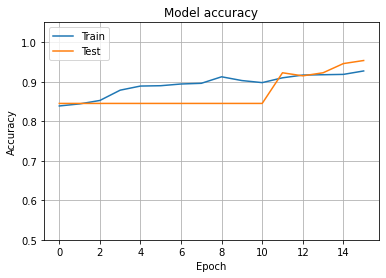

In [ ]:
plt.plot(result_list[study.best_trial.number].history["accuracy"])
plt.plot(result_list[study.best_trial.number].history["val_accuracy"])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Test"], loc="upper left")
plt.ylim(0.5, 1.05)
plt.grid()
plt.show()

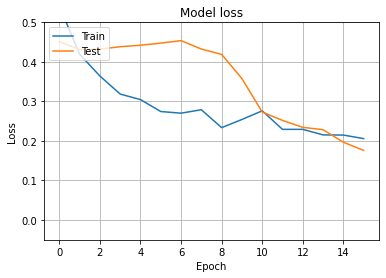

In [ ]:
plt.plot(result_list[study.best_trial.number].history["loss"])
plt.plot(result_list[study.best_trial.number].history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"], loc="upper left")
plt.ylim(-0.05, 0.5)
plt.grid()
plt.show()

In [ ]:
model_list[study.best_trial.number].save("tomii.h5")